# Comp2 结构化数据

主要适配于临床数据以及各种组学和模态提取的结构化数据建模和刻画。典型的应用场景探究rad_score最终临床诊断的作用。

## Onekey步骤

1. 数据校验，检查数据格式是否正确。
3. 查看一些统计信息，检查数据时候存在异常点。
4. 正则化，将数据变化到服从 N~(0, 1)。
5. 通过相关系数，例如spearman、person等筛选出特征。
6. 构建训练集和测试集，这里使用的是随机划分，正常多中心验证，需要大家根据自己的场景构建两份数据。
7. 通过Lasso筛选特征，选取其中的非0项作为后续模型的特征。
8. 使用机器学习算法，例如LR、SVM、RF等进行任务学习。
9. 模型结果可视化，例如AUC、ROC曲线，混淆矩阵等。


### 指定数据

此模块有3个需要自己定义的参数

1. `feature_file`: 特征数据存放的路径。
2. `label_file`: 每个样本的标注信息文件。
3. `labels`: 要让AI系统学习的目标，例如肿瘤的良恶性、T-stage等。

In [1]:
import os
from IPython.display import display
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from onekey_algo import OnekeyDS as okds
import pandas as pd

os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('features', exist_ok=True)
# 设置数据目录
label_file = r"J:\4type\label_multiclass_multicenter2.csv"
feature_file = r"J:\4type\feature_multiclass_multicenter_histogram.csv"
# 对应的标签文件
# label_file = r'你自己标注数据的文件地址'
# label_file = os.path.join(okds.ct, 'label_multiclass_multicenter.csv')
# 读取标签数据列名
labels = ['label']

## 读取数据

数据以csv格式进行存储，这里如果是其他格式，可以使用自定义函数读取出每个样本的结果。

要求label_data为一个`DataFrame`格式，包括ID列以及后续的labels列，可以是多列，支持Multi-Task。

In [6]:
feature_data = pd.read_csv(feature_file,dtype={'ID':str})
display(feature_data)
label_data = pd.read_csv(label_file,dtype={'ID':str})
label_data.head()

group            ID  HP_0.01  HP_0.02  HP_0.03  HP_0.04  HP_0.05  \
0       ZR  201601180059    0.000    0.000    0.000    0.000    0.000   
1       ZR  201601201001    0.481    0.026    0.019    0.008    0.038   
2       ZR  201601220643    0.543    0.023    0.035    0.012    0.008   
3       ZR  201601220716    0.481    0.045    0.023    0.026    0.010   
4       ZR  201601270923    0.726    0.014    0.022    0.014    0.018   
...    ...           ...      ...      ...      ...      ...      ...   
5208    JD      CT873838    0.305    0.020    0.031    0.014    0.020   
5209    JD    CT873838_1    0.547    0.018    0.024    0.018    0.012   
5210    JD      CT878142    0.349    0.025    0.016    0.022    0.006   
5211    JD      CT883444    0.106    0.048    0.026    0.029    0.023   
5212    JD      CT883634    0.352    0.020    0.028    0.006    0.017   

      HP_0.06  HP_0.07  HP_0.08  ...  UIP_0.91  UIP_0.92  UIP_0.93  UIP_0.94  \
0       0.000    0.009    0.000  ...     0.000     0.000     0.000     0.000   
1       0.011    0.015    0.000  ...     0.000     0.000     0.000     0.000   
2       0.012    0.008    0.004  ...     0.008     0.008     0.012     0.000   
3       0.016    0.006    0.013  ...     0.000     0.000     0.000     0.000   
4       0.007    0.004    0.004  ...     0.004     0.007     0.007     0.011   
...       ...      ...      ...  ...       ...       ...       ...       ...   
5208    0.011    0.008    0.031  ...     0.011     0.008     0.006     0.006   
5209    0.012    0.012    0.009  ...     0.003     0.006     0.015     0.024   
5210    0.003    0.016    0.000  ...     0.000     0.000     0.006     0.000   
5211    0.016    0.023    0.013  ...     0.000     0.000     0.003     0.000   
5212    0.008    0.011    0.014  ...     0.006     0.020     0.014     0.011   

      UIP_0.95  UIP_0.96  UIP_0.97  UIP_0.98  UIP_0.99  UIP_1.0  
0        0.000     0.000     0.000     0.000     0.000    0.000  
1        0.000     0.000     0.000     0.000     0.000    0.000  
2        0.031     0.012     0.027     0.020     0.090    0.254  
3        0.000     0.000     0.000     0.000     0.000    0.000  
4        0.014     0.004     0.022     0.040     0.069    0.556  
...        ...       ...       ...       ...       ...      ...  
5208     0.011     0.000     0.014     0.014     0.028    0.028  
5209     0.015     0.030     0.045     0.045     0.060    0.180  
5210     0.010     0.013     0.016     0.025     0.044    0.095  
5211     0.000     0.000     0.000     0.003     0.003    0.000  
5212     0.020     0.017     0.025     0.031     0.065    0.118  

[5213 rows x 402 columns]

group            ID  label  Age  Gender Smoke     BMI  FEV1percent  \
0       train  201601180059      0   58  Female    No  33.333        119.7   
1  validation  201601201001      1   62  Female    No  20.415        122.1   
2       train  201601220643      3   59  Female    No  27.885        106.4   
3  validation  201601220716      2   51    Male   Yes  24.859         79.8   
4       train  201601270923      3   61    Male   Yes  19.568         39.4   

   FVCpercent  DLCOpercent   DM  CVD  HBP  
0       141.1         93.8  Yes   No  Yes  
1       117.8         78.7   No  Yes  Yes  
2        91.2         65.8   No   No  Yes  
3        68.0         59.6  Yes   No   No  
4        40.7         20.1   No   No   No

## 特征拼接 

将标注数据`label_data`与`rad_data`进行合并，得到训练数据。

**注意：** 
1. 需要删掉ID这一列
2. 如果发现数据少了，需要自行检查数据是否匹配。

In [7]:
from onekey_algo.custom.utils import print_join_info
# 删掉ID这一列。
print_join_info(feature_data, label_data)
feature_data.drop("group",axis=1,inplace=True)
combined_data = pd.merge(feature_data, label_data, on=['ID'], how='inner')
ids = combined_data['ID']
combined_data = combined_data.drop(['ID'], axis=1)
print(combined_data[labels].value_counts())
combined_data.columns

[2024-09-18 13:04:53 - <frozen onekey_algo.custom.utils>:  55]	INFO	ID特征完全匹配！


label
3        2250
1        1568
0        1015
2         380
dtype: int64


Index(['HP_0.01', 'HP_0.02', 'HP_0.03', 'HP_0.04', 'HP_0.05', 'HP_0.06',
       'HP_0.07', 'HP_0.08', 'HP_0.09', 'HP_0.1',
       ...
       'Age', 'Gender', 'Smoke', 'BMI', 'FEV1percent', 'FVCpercent',
       'DLCOpercent', 'DM', 'CVD', 'HBP'],
      dtype='object', length=412)

## 获取到数据的统计信息

1. count，统计样本个数。
2. mean、std, 对应特征的均值、方差
3. min, 25%, 50%, 75%, max，对应特征的最小值，25,50,75分位数，最大值。

In [8]:
combined_data.describe()

HP_0.01   HP_0.02   HP_0.03   HP_0.04   HP_0.05   HP_0.06   HP_0.07  \
count  5213.000  5213.000  5213.000  5213.000  5213.000  5213.000  5213.000   
mean      0.450     0.020     0.014     0.011     0.009     0.008     0.007   
std       0.241     0.014     0.010     0.008     0.007     0.006     0.006   
min       0.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%       0.370     0.009     0.006     0.004     0.003     0.003     0.003   
50%       0.531     0.020     0.013     0.010     0.008     0.007     0.006   
75%       0.619     0.029     0.021     0.016     0.014     0.012     0.010   
max       0.898     0.068     0.061     0.059     0.056     0.039     0.038   

        HP_0.08   HP_0.09    HP_0.1  ...  UIP_0.97  UIP_0.98  UIP_0.99  \
count  5213.000  5213.000  5213.000  ...  5213.000  5213.000  5213.000   
mean      0.007     0.006     0.006  ...     0.008     0.012     0.026   
std       0.006     0.005     0.005  ...     0.010     0.015     0.031   
min       0.000     0.000     0.000  ...     0.000     0.000     0.000   
25%       0.003     0.003     0.003  ...     0.000     0.000     0.000   
50%       0.006     0.005     0.006  ...     0.003     0.003     0.003   
75%       0.010     0.009     0.009  ...     0.016     0.024     0.052   
max       0.111     0.036     0.037  ...     0.055     0.073     0.134   

        UIP_1.0     label       Age       BMI  FEV1percent  FVCpercent  \
count  5213.000  5213.000  5213.000  5213.000     5213.000     5213.00   
mean      0.170     1.741    61.735    25.325       85.362       85.14   
std       0.213     1.202    10.841     3.311       21.923       22.51   
min       0.000     0.000    15.000    14.473        2.190        2.34   
25%       0.000     1.000    56.000    23.095       70.020       68.70   
50%       0.000     2.000    63.000    25.153       86.000       84.60   
75%       0.373     3.000    69.000    27.429      101.300       99.40   
max       0.780     3.000    92.000    43.852      160.300      160.30   

       DLCOpercent  
count     5213.000  
mean        58.552  
std         21.171  
min          6.840  
25%         42.300  
50%         57.900  
75%         73.900  
max        142.000  

[8 rows x 406 columns]

## 正则化

`normalize_df` 为onekey中正则化的API，将数据变化到0均值1方差。正则化的方法为

$column = \frac{column - mean}{std}$

In [9]:
from onekey_algo.custom.components.comp1 import normalize_df
data = normalize_df(combined_data, not_norm=labels+["Age","Gender","Smoke","BMI","FEV1percent","FVCpercent","DLCOpercent","DM","CVD","HBP"], group='group')
data = data.dropna(axis=1)
data.describe()

HP_0.01    HP_0.02    HP_0.03   HP_0.04    HP_0.05    HP_0.06  \
count  5.213e+03  5.213e+03  5.213e+03  5213.000  5.213e+03  5.213e+03   
mean   1.240e-16 -2.072e-16 -3.544e-17     0.000  2.453e-16 -4.907e-17   
std    9.997e-01  9.997e-01  9.997e-01     1.000  9.997e-01  9.997e-01   
min   -2.333e+00 -1.765e+00 -1.581e+00    -1.454 -1.404e+00 -1.348e+00   
25%   -3.624e-01 -7.700e-01 -7.594e-01    -0.875 -7.947e-01 -7.377e-01   
50%    3.387e-01 -8.266e-03 -6.662e-02    -0.110 -1.709e-01 -1.811e-01   
75%    7.022e-01  6.821e-01  6.652e-01     0.655  6.193e-01  6.042e-01   
max    1.963e+00  3.572e+00  4.670e+00     4.971  6.392e+00  5.199e+00   

         HP_0.07    HP_0.08    HP_0.09     HP_0.1  ...   UIP_0.97   UIP_0.98  \
count  5.213e+03  5.213e+03  5.213e+03  5.213e+03  ...  5.213e+03  5.213e+03   
mean   6.134e-17 -6.134e-18 -7.633e-17 -7.088e-17  ... -8.178e-18  2.726e-18   
std    9.997e-01  9.997e-01  9.997e-01  9.997e-01  ...  9.997e-01  9.997e-01   
min   -1.266e+00 -1.202e+00 -1.145e+00 -1.219e+00  ... -1.286e+00 -1.360e+00   
25%   -6.730e-01 -6.195e-01 -5.820e-01 -5.965e-01  ... -7.347e-01 -7.591e-01   
50%   -1.115e-01 -7.575e-02 -2.244e-01 -6.163e-02  ... -7.239e-01 -7.304e-01   
75%    5.624e-01  5.650e-01  6.084e-01  6.504e-01  ...  6.712e-01  7.581e-01   
max    4.904e+00  1.784e+01  5.579e+00  6.075e+00  ...  4.615e+00  4.087e+00   

        UIP_0.99    UIP_1.0     label       Age       BMI  FEV1percent  \
count  5.213e+03  5.213e+03  5213.000  5213.000  5213.000     5213.000   
mean   3.816e-17  7.633e-17     1.741    61.735    25.325       85.362   
std    9.997e-01  9.997e-01     1.202    10.841     3.311       21.923   
min   -1.324e+00 -9.262e-01     0.000    15.000    14.473        2.190   
25%   -7.875e-01 -7.973e-01     1.000    56.000    23.095       70.020   
50%   -7.720e-01 -7.796e-01     2.000    63.000    25.153       86.000   
75%    8.770e-01  9.432e-01     3.000    69.000    27.429      101.300   
max    3.764e+00  3.122e+00     3.000    92.000    43.852      160.300   

       FVCpercent  DLCOpercent  
count     5213.00     5213.000  
mean        85.14       58.552  
std         22.51       21.171  
min          2.34        6.840  
25%         68.70       42.300  
50%         84.60       57.900  
75%         99.40       73.900  
max        160.30      142.000  

[8 rows x 406 columns]

### 相关系数

计算相关系数的方法有3种可供选择
1. pearson （皮尔逊相关系数）: standard correlation coefficient

2. kendall (肯德尔相关性系数) : Kendall Tau correlation coefficient

3. spearman (斯皮尔曼相关性系数): Spearman rank correlation

三种相关系数参考：https://blog.csdn.net/zmqsdu9001/article/details/82840332

In [10]:
pearson_corr = data[data['group'] == 'train'][[c for c in data.columns if c not in labels+["Age","Gender","Smoke","BMI","FEV1percent","FVCpercent","DLCOpercent","DM","CVD","HBP"]]].corr('pearson')
# kendall_corr = data[[c for c in data.columns if c not in labels]].corr('kendall')
# spearman_corr = data[[c for c in data.columns if c not in labels]].corr('spearman')

### 相关系数可视化

通过修改变量名，可以可视化不同相关系数下的相关矩阵。

**注意**：当特征特别多的时候（大于100），尽量不要可视化，否则运行时间会特别长。

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from onekey_algo.custom.components.comp1 import draw_matrix

if combined_data.shape[1] < 50:
    plt.figure(figsize=(50.0, 40.0))
    # 选择可视化的相关系数
    draw_matrix(pearson_corr, annot=True, cmap='YlGnBu', cbar=False)
    plt.savefig(f'img/feature_corr.svg', bbox_inches = 'tight')

### 聚类分析

通过修改变量名，可以可视化不同相关系数下的相聚类分析矩阵。

注意：当特征特别多的时候（大于100），尽量不要可视化，否则运行时间会特别长。

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

if combined_data.shape[1] < 100:
    pp = sns.clustermap(pearson_corr, linewidths=.5, figsize=(50.0, 40.0), cmap='YlGnBu')
    plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
    plt.savefig(f'img/feature_cluster.svg', bbox_inches = 'tight')

### 特征筛选 -- 相关系数

根据相关系数，对于相关性比较高的特征（一般文献取corr>0.9），两者保留其一。

```python
def select_feature(corr, threshold: float = 0.9, keep: int = 1, topn=10, verbose=False):
    """
    * corr, 相关系数矩阵。
    * threshold，筛选的相关系数的阈值，大于阈值的两者保留其一（可以根据keep修改，可以是其二...）。默认阈值为0.9
    * keep，可以选择大于相关系数，保留几个，默认只保留一个。
    * topn, 每次去掉多少重复特征。
    * verbose，是否打印日志
    """
```

In [13]:
from onekey_algo.custom.components.comp1 import select_feature
sel_feature = select_feature(pearson_corr, threshold=0.9, topn=10, verbose=False)
sel_feature += labels + ['group']
sel_feature

['HP_0.01',
 'HP_0.02',
 'HP_0.03',
 'HP_0.04',
 'HP_0.05',
 'HP_0.06',
 'HP_0.07',
 'HP_0.08',
 'HP_0.09',
 'HP_0.1',
 'HP_0.11',
 'HP_0.12',
 'HP_0.13',
 'HP_0.14',
 'HP_0.15',
 'HP_0.16',
 'HP_0.17',
 'HP_0.18',
 'HP_0.19',
 'HP_0.2',
 'HP_0.21',
 'HP_0.22',
 'HP_0.23',
 'HP_0.24',
 'HP_0.25',
 'HP_0.26',
 'HP_0.27',
 'HP_0.28',
 'HP_0.29',
 'HP_0.3',
 'HP_0.31',
 'HP_0.32',
 'HP_0.33',
 'HP_0.34',
 'HP_0.35',
 'HP_0.36',
 'HP_0.37',
 'HP_0.38',
 'HP_0.39',
 'HP_0.4',
 'HP_0.41',
 'HP_0.42',
 'HP_0.43',
 'HP_0.44',
 'HP_0.45',
 'HP_0.46',
 'HP_0.47',
 'HP_0.48',
 'HP_0.49',
 'HP_0.5',
 'HP_0.51',
 'HP_0.52',
 'HP_0.53',
 'HP_0.54',
 'HP_0.55',
 'HP_0.56',
 'HP_0.57',
 'HP_0.58',
 'HP_0.59',
 'HP_0.6',
 'HP_0.61',
 'HP_0.62',
 'HP_0.63',
 'HP_0.64',
 'HP_0.65',
 'HP_0.66',
 'HP_0.67',
 'HP_0.68',
 'HP_0.69',
 'HP_0.7',
 'HP_0.71',
 'HP_0.72',
 'HP_0.73',
 'HP_0.74',
 'HP_0.75',
 'HP_0.76',
 'HP_0.77',
 'HP_0.78',
 'HP_0.79',
 'HP_0.8',
 'HP_0.81',
 'HP_0.82',
 'HP_0.83',
 'HP_0.84',


### 过滤特征

通过`sel_feature`过滤出筛选出来的特征。

In [14]:
sel_data = data[sel_feature]
sel_data.describe()

HP_0.01    HP_0.02    HP_0.03   HP_0.04    HP_0.05    HP_0.06  \
count  5.213e+03  5.213e+03  5.213e+03  5213.000  5.213e+03  5.213e+03   
mean   1.240e-16 -2.072e-16 -3.544e-17     0.000  2.453e-16 -4.907e-17   
std    9.997e-01  9.997e-01  9.997e-01     1.000  9.997e-01  9.997e-01   
min   -2.333e+00 -1.765e+00 -1.581e+00    -1.454 -1.404e+00 -1.348e+00   
25%   -3.624e-01 -7.700e-01 -7.594e-01    -0.875 -7.947e-01 -7.377e-01   
50%    3.387e-01 -8.266e-03 -6.662e-02    -0.110 -1.709e-01 -1.811e-01   
75%    7.022e-01  6.821e-01  6.652e-01     0.655  6.193e-01  6.042e-01   
max    1.963e+00  3.572e+00  4.670e+00     4.971  6.392e+00  5.199e+00   

         HP_0.07    HP_0.08    HP_0.09     HP_0.1  ...   UIP_0.92   UIP_0.93  \
count  5.213e+03  5.213e+03  5.213e+03  5.213e+03  ...  5.213e+03  5.213e+03   
mean   6.134e-17 -6.134e-18 -7.633e-17 -7.088e-17  ... -4.771e-17 -2.453e-17   
std    9.997e-01  9.997e-01  9.997e-01  9.997e-01  ...  9.997e-01  9.997e-01   
min   -1.266e+00 -1.202e+00 -1.145e+00 -1.219e+00  ... -1.126e+00 -1.130e+00   
25%   -6.730e-01 -6.195e-01 -5.820e-01 -5.965e-01  ... -6.696e-01 -6.781e-01   
50%   -1.115e-01 -7.575e-02 -2.244e-01 -6.163e-02  ... -6.696e-01 -6.562e-01   
75%    5.624e-01  5.650e-01  6.084e-01  6.504e-01  ...  5.981e-01  5.497e-01   
max    4.904e+00  1.784e+01  5.579e+00  6.075e+00  ...  7.029e+00  5.463e+00   

        UIP_0.94   UIP_0.95   UIP_0.96   UIP_0.97   UIP_0.98   UIP_0.99  \
count  5.213e+03  5.213e+03  5.213e+03  5.213e+03  5.213e+03  5.213e+03   
mean  -8.451e-17 -7.088e-17  3.544e-17 -8.178e-18  2.726e-18  3.816e-17   
std    9.997e-01  9.997e-01  9.997e-01  9.997e-01  9.997e-01  9.997e-01   
min   -1.170e+00 -1.289e+00 -1.213e+00 -1.286e+00 -1.360e+00 -1.324e+00   
25%   -6.967e-01 -7.033e-01 -7.208e-01 -7.347e-01 -7.591e-01 -7.875e-01   
50%   -6.487e-01 -6.931e-01 -7.027e-01 -7.239e-01 -7.304e-01 -7.720e-01   
75%    4.541e-01  6.012e-01  5.910e-01  6.712e-01  7.581e-01  8.770e-01   
max    5.364e+00  4.745e+00  4.166e+00  4.615e+00  4.087e+00  3.764e+00   

         UIP_1.0     label  
count  5.213e+03  5213.000  
mean   7.633e-17     1.741  
std    9.997e-01     1.202  
min   -9.262e-01     0.000  
25%   -7.973e-01     1.000  
50%   -7.796e-01     2.000  
75%    9.432e-01     3.000  
max    3.122e+00     3.000  

[8 rows x 399 columns]

## 构建数据

将样本的训练数据X与监督信息y分离出来，并且对训练数据进行划分，一般的划分原则为80%-20%

**注意：**这个地方做交叉验证以及筛选特征的时候，使用的是全部数据，如果数据量大可以使用`X_train`和`y_train`。

In [15]:
import numpy as np
import onekey_algo.custom.components as okcomp

n_classes = len(np.unique(label_data['label']))
train_data = sel_data[(sel_data['group'] == 'train')]
train_ids = ids[train_data.index]
train_data = train_data.reset_index()
train_data = train_data.drop('index', axis=1)
y_data = train_data[labels]
X_data = train_data.drop(labels + ['group'], axis=1)

test_data = sel_data[sel_data['group'] == 'validation']
test_ids = ids[test_data.index]
test_data = test_data.reset_index()
test_data = test_data.drop('index', axis=1)
y_test_data = test_data[labels]
X_test_data = test_data.drop(labels + ['group'], axis=1)

y_all_data = sel_data[labels]
X_all_data = sel_data.drop(labels + ['group'], axis=1)

column_names = X_data.columns
print(f"训练集样本数：{X_data.shape}, 验证集样本数：{X_test_data.shape}")

训练集样本数：(3585, 398), 验证集样本数：(932, 398)


### Lasso

初始化Lasso模型，alpha为惩罚系数。具体的参数文档可以参考：[文档](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso)

### 交叉验证

不同Lambda下的，特征的的权重大小。
```python
def lasso_cv_coefs(X_data, y_data, points=50, column_names: List[str] = None, **kwargs):
    """

    Args:
        X_data: 训练数据
        y_data: 监督数据
        points: 打印多少个点。默认50
        column_names: 列名，默认为None，当选择的数据很多的时候，建议不要添加此参数
        **kwargs: 其他用于打印控制的参数。

    """
 ```

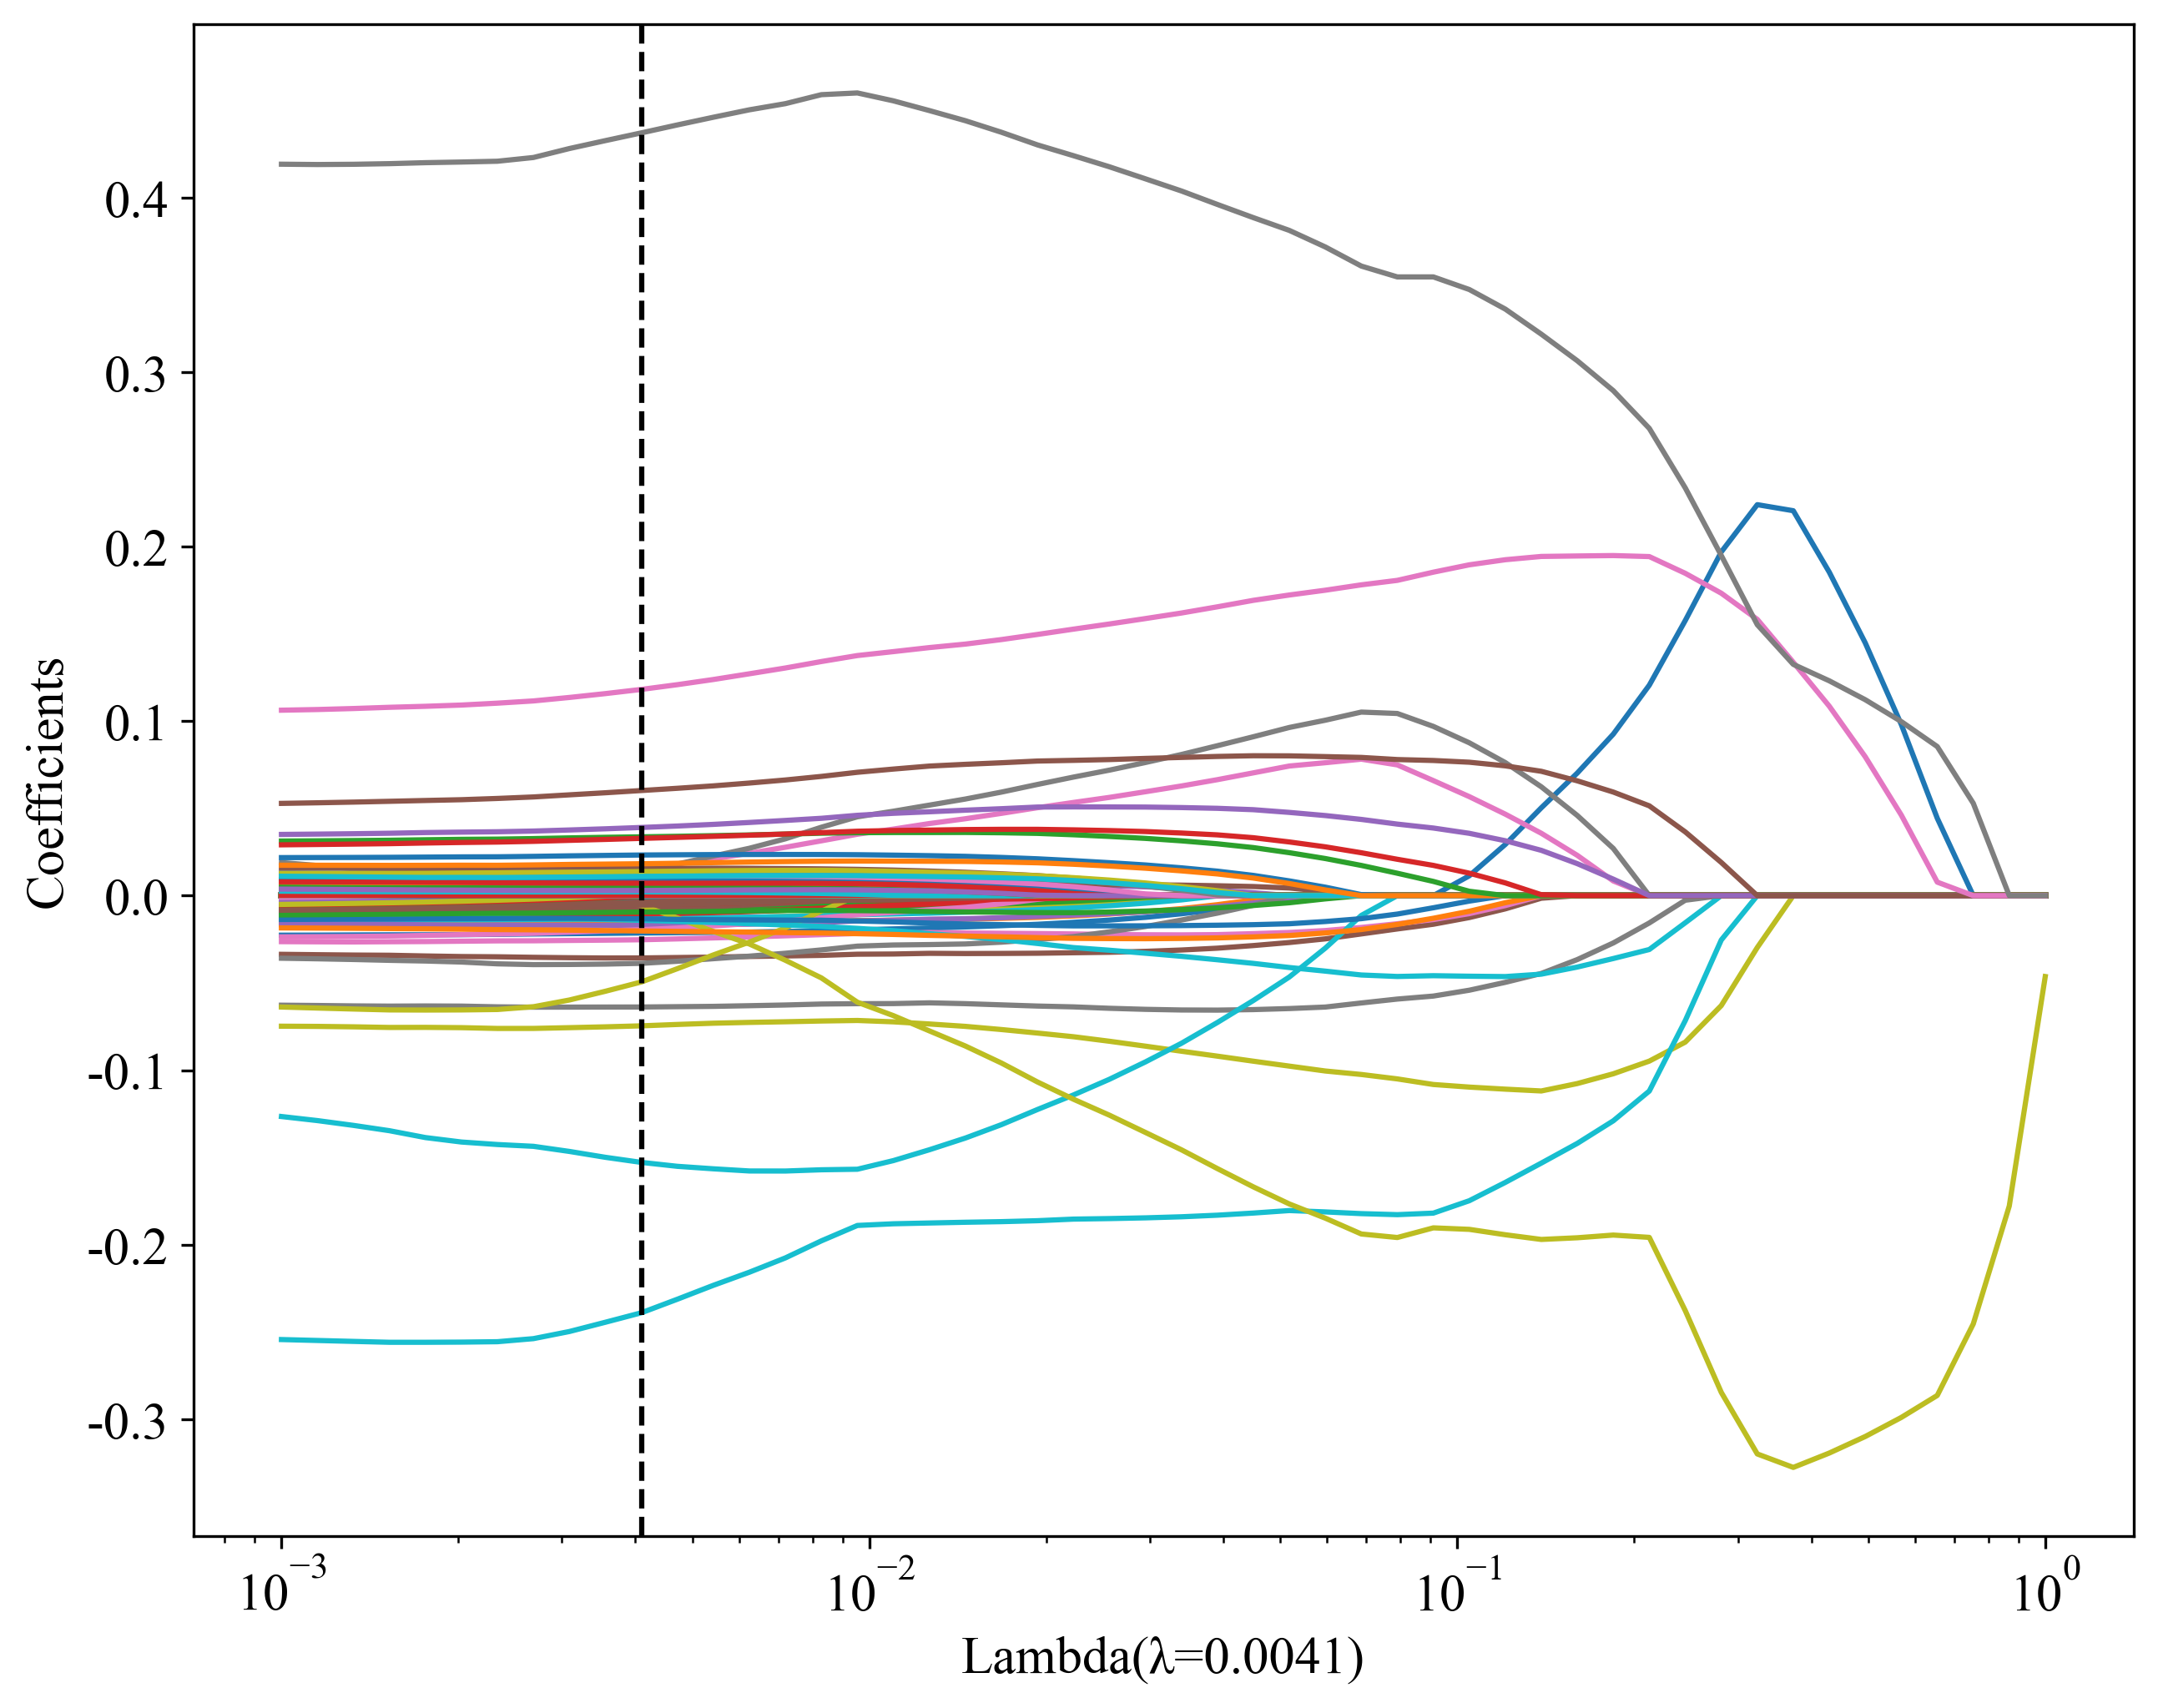

In [16]:
alpha = okcomp.comp1.lasso_cv_coefs(X_data, y_data, column_names=None)
plt.savefig(f'img/feature_lasso.svg', bbox_inches = 'tight')

### 模型效能

```python
def lasso_cv_efficiency(X_data, y_data, points=50, **kwargs):
    """

    Args:
        Xdata: 训练数据
        ydata: 测试数据
        points: 打印的数据密度
        **kwargs: 其他的图像样式
            # 数据点标记, fmt="o"
            # 数据点大小, ms=3
            # 数据点颜色, mfc="r"
            # 数据点边缘颜色, mec="r"
            # 误差棒颜色, ecolor="b"
            # 误差棒线宽, elinewidth=2
            # 误差棒边界线长度, capsize=2
            # 误差棒边界厚度, capthick=1
    Returns:
    """
 ```

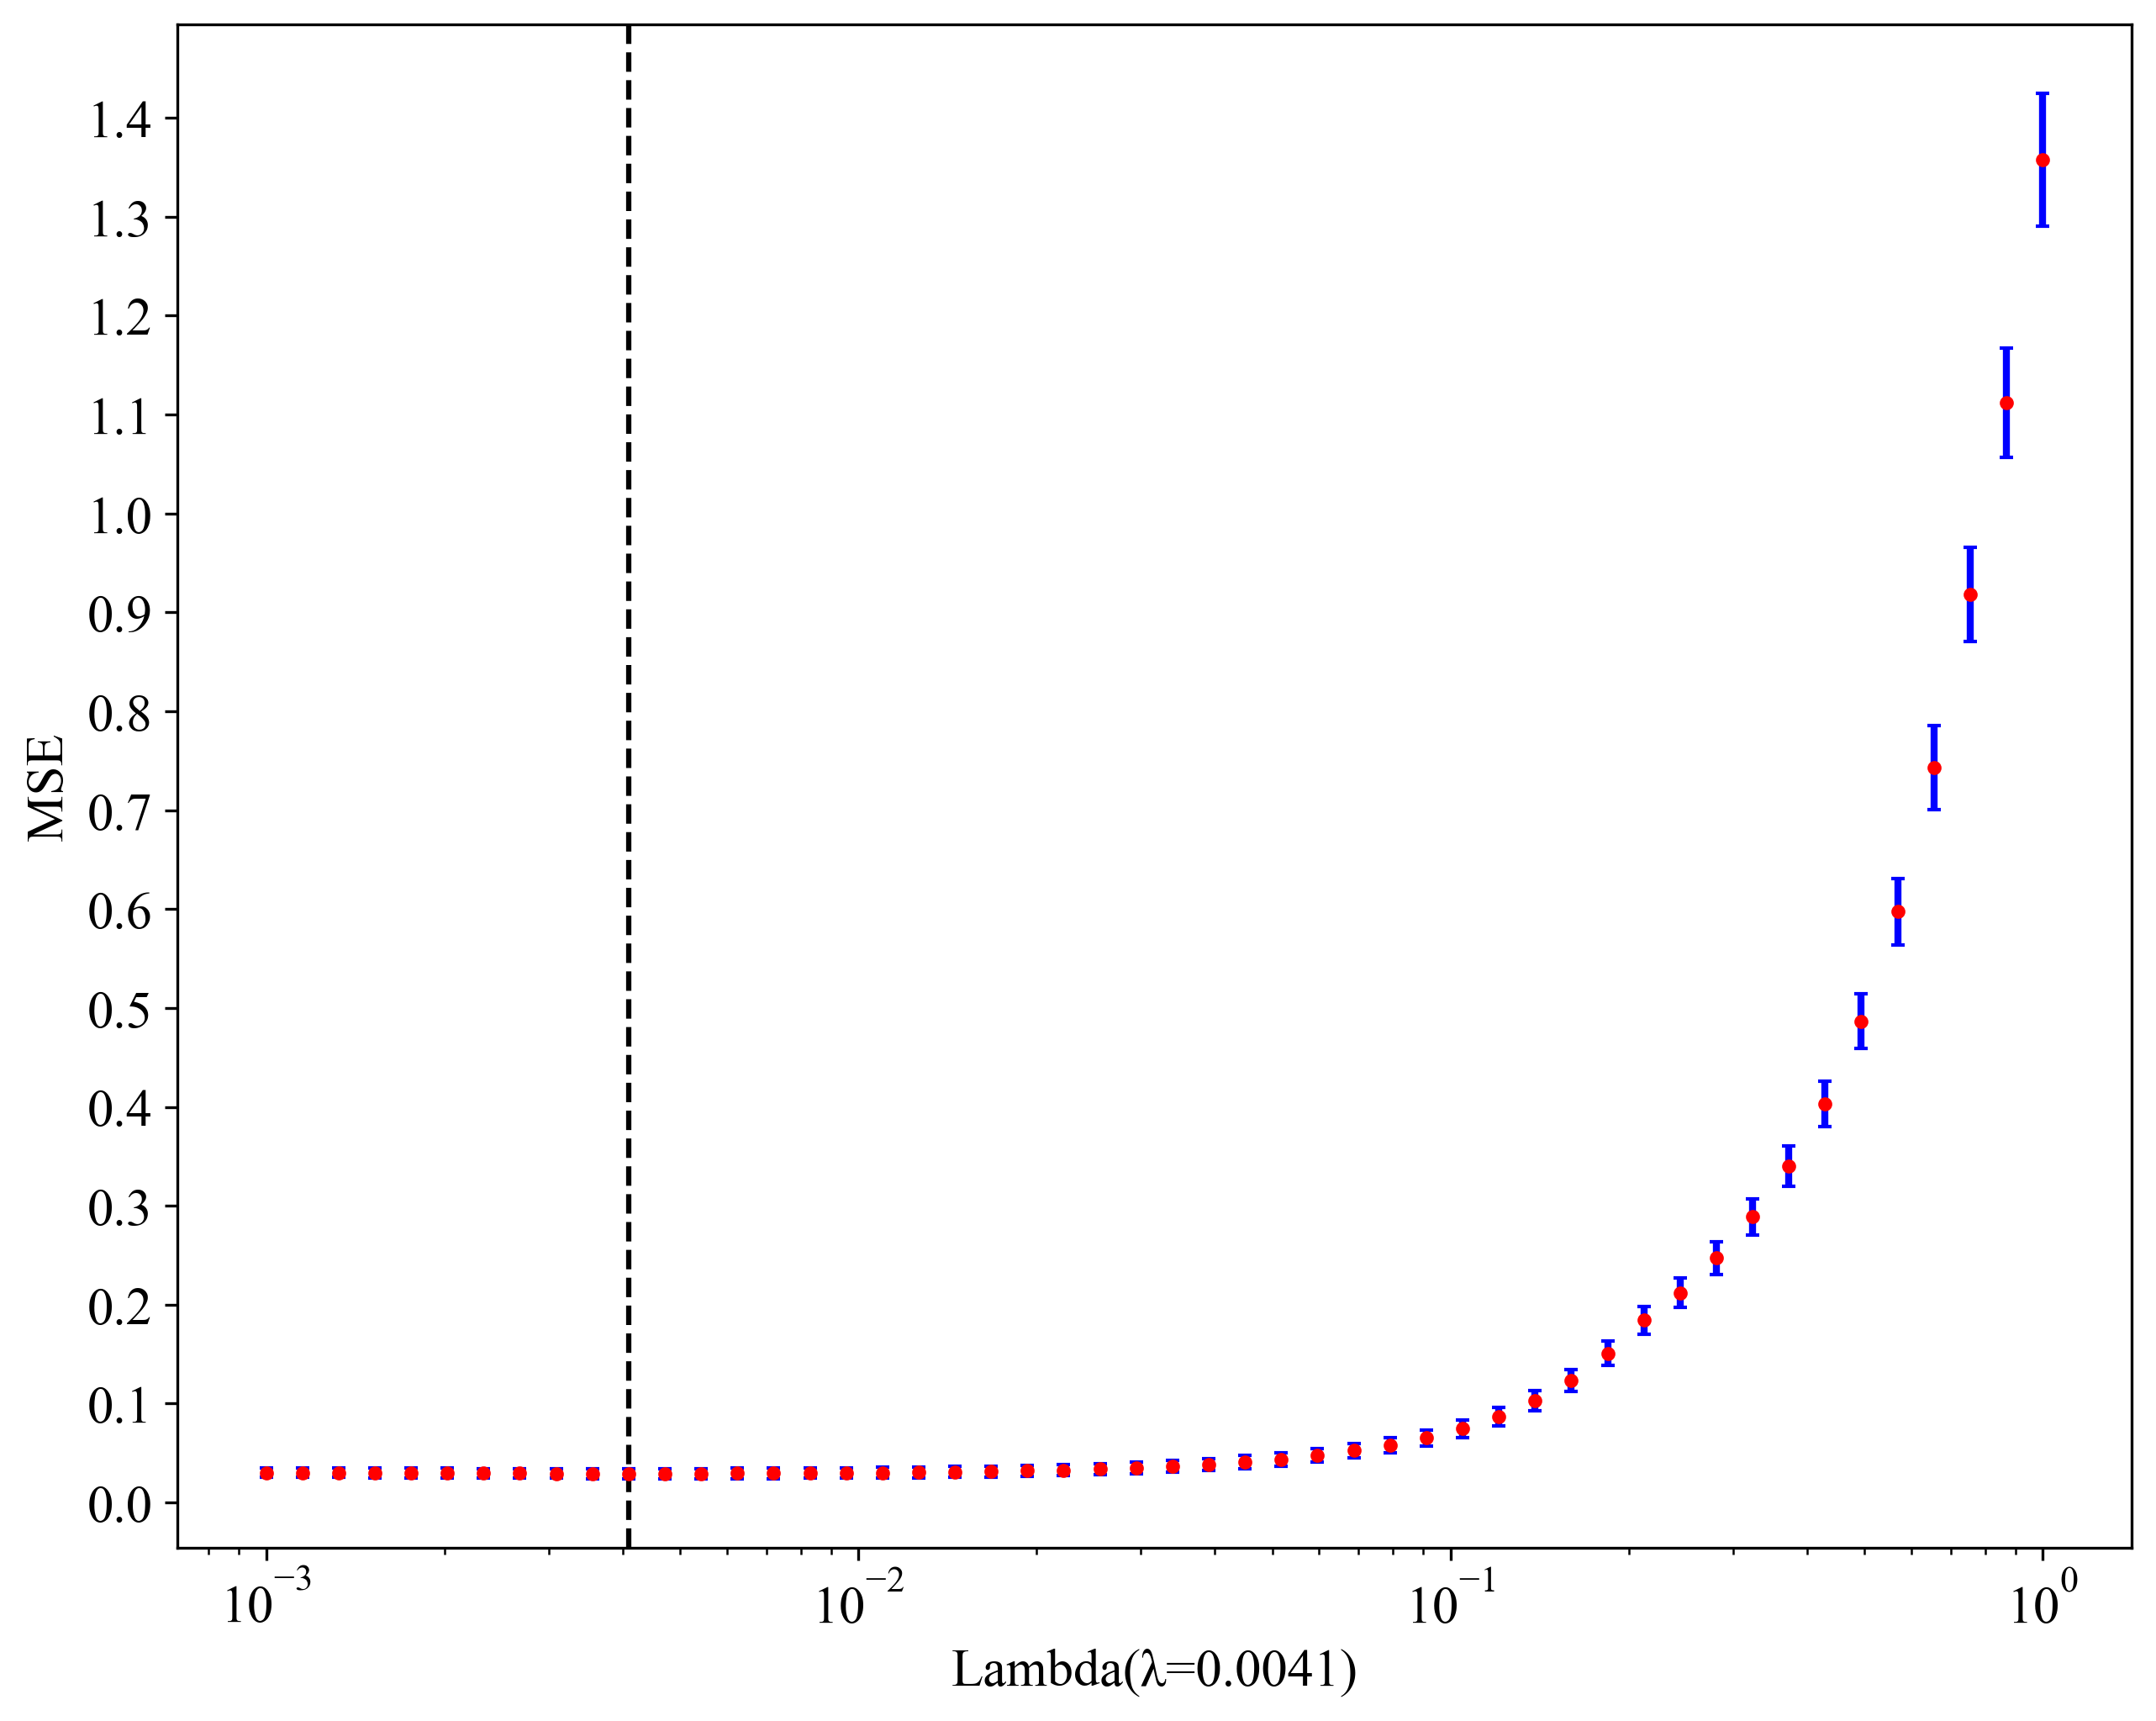

In [17]:
okcomp.comp1.lasso_cv_efficiency(X_data, y_data, points=50)
plt.savefig(f'img/feature_mse.svg', bbox_inches = 'tight')

### 惩罚系数

使用交叉验证的惩罚系数作为模型训练的基础。

In [18]:
from sklearn import linear_model

models = []
for label in labels:
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X_data, y_data[label])
    models.append(clf)

### 特征筛选

筛选出其中coef > 0的特征。并且打印出相应的公式。

In [19]:
COEF_THRESHOLD = 1e-6 # 筛选的特征阈值
scores = []
selected_features = []
for label, model in zip(labels, models):
    feat_coef = [(feat_name, coef) for feat_name, coef in zip(column_names, model.coef_) 
                 if COEF_THRESHOLD is None or abs(coef) > COEF_THRESHOLD]
    selected_features.append([feat for feat, _ in feat_coef])
    formula = ' '.join([f"{coef:+.6f} * {feat_name}" for feat_name, coef in feat_coef])
    score = f"{label} = {model.intercept_} {'+' if formula[0] != '-' else ''} {formula}"
    scores.append(score)
    
print(scores[0])

label = 1.715481171548117 + +0.007754 * HP_0.02 +0.003571 * HP_0.04 +0.000246 * HP_0.05 +0.000571 * HP_0.09 +0.000606 * HP_0.1 -0.002318 * HP_0.17 +0.000548 * HP_0.24 +0.006298 * HP_0.28 -0.002122 * HP_0.35 +0.000069 * HP_0.42 -0.004130 * HP_0.48 +0.000562 * HP_0.52 -0.001566 * HP_0.6 -0.000469 * HP_0.63 -0.000439 * HP_0.64 -0.003177 * HP_0.65 -0.004224 * HP_0.67 -0.002984 * HP_0.73 -0.003017 * HP_0.74 -0.001378 * HP_0.75 -0.006845 * HP_0.77 -0.003126 * HP_0.78 -0.010149 * HP_0.79 -0.001503 * HP_0.81 -0.005665 * HP_0.82 -0.003095 * HP_0.83 -0.006628 * HP_0.84 -0.002559 * HP_0.85 -0.003510 * HP_0.86 -0.008481 * HP_0.87 -0.006834 * HP_0.88 -0.013832 * HP_0.89 -0.013005 * HP_0.9 -0.021435 * HP_0.91 -0.016157 * HP_0.92 -0.009226 * HP_0.93 -0.006734 * HP_0.94 -0.017040 * HP_0.95 -0.035722 * HP_0.96 -0.025311 * HP_0.97 -0.063866 * HP_0.98 -0.074703 * HP_0.99 -0.239463 * HP_1.0 +0.008717 * NSIP_0.02 +0.003910 * NSIP_0.03 +0.000495 * NSIP_0.06 +0.001256 * NSIP_0.09 +0.004704 * NSIP_0.13 +0.001

### 特征权重

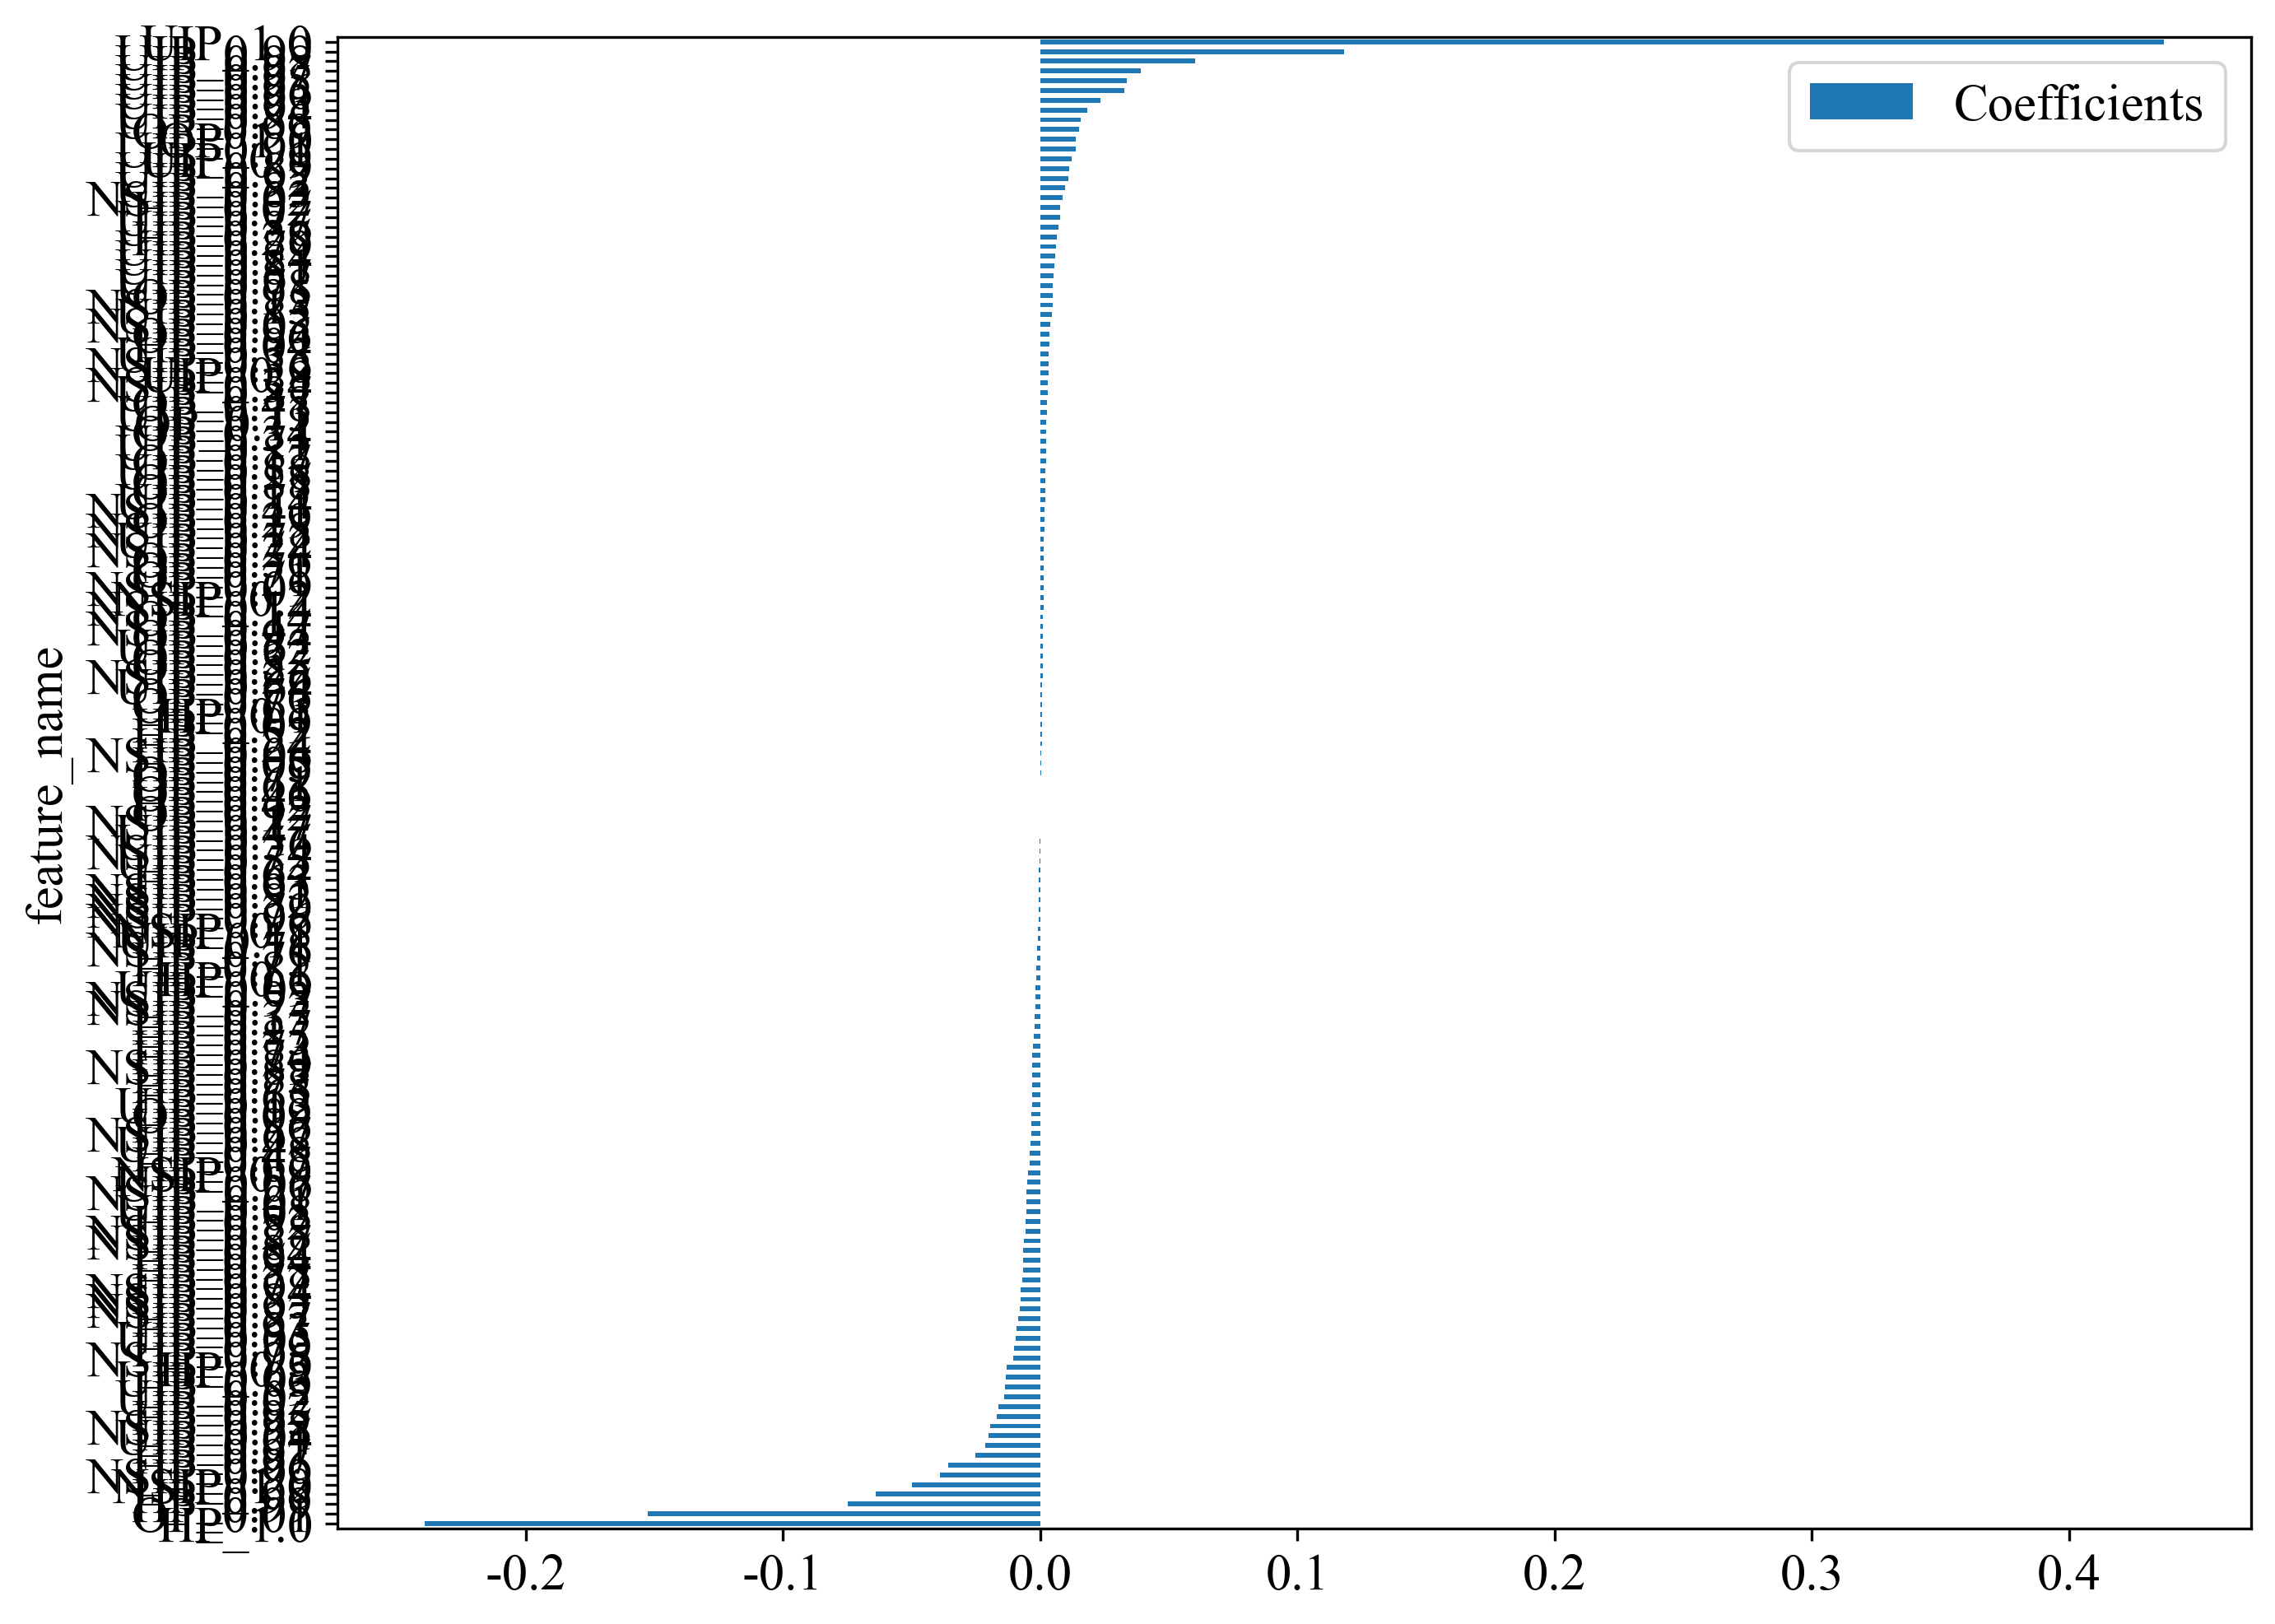

In [20]:
feat_coef = sorted(feat_coef, key=lambda x: x[1])
feat_coef_df = pd.DataFrame(feat_coef, columns=['feature_name', 'Coefficients'])
feat_coef_df.plot(x='feature_name', y='Coefficients', kind='barh')
plt.savefig(f'img/feature_weights.svg', bbox_inches = 'tight')

### 进一步筛选特征

使用Lasso筛选出来的Coefficients比较高的特征作为训练数据。

In [21]:
X_data = X_data[selected_features[0]]
X_test_data = X_test_data[selected_features[0]]
X_data.columns

Index(['HP_0.02', 'HP_0.04', 'HP_0.05', 'HP_0.09', 'HP_0.1', 'HP_0.17',
       'HP_0.24', 'HP_0.28', 'HP_0.35', 'HP_0.42',
       ...
       'UIP_0.91', 'UIP_0.92', 'UIP_0.93', 'UIP_0.94', 'UIP_0.95', 'UIP_0.96',
       'UIP_0.97', 'UIP_0.98', 'UIP_0.99', 'UIP_1.0'],
      dtype='object', length=153)

## 模型筛选

根据筛选出来的数据，做模型的初步选择。当前主要使用到的是Onekey中的

1. SVM，支持向量机，引用参考。
2. KNN，K紧邻，引用参考。
3. Decision Tree，决策树，引用参考。
4. Random Forests, 随机森林，引用参考。
5. XGBoost, bosting方法。引用参考。
6. LightGBM, bosting方法，引用参考。

In [22]:
model_names = ['SVM', 'KNN', 'RandomForest', 'ExtraTrees', 'XGBoost', 'LightGBM', 'NaiveBayes', 'GradientBoosting', 'MLP']
models = okcomp.comp1.create_clf_model(model_names)
model_names = list(models.keys())

### 交叉验证

`n_trails`指定随机次数，每次采用的是80%训练，随机20%进行测试，找到最好的模型，以及对应的最好的数据划分。


```python
def get_bst_split(X_data: pd.DataFrame, y_data: pd.DataFrame,
            models: dict, test_size=0.2, metric_fn=accuracy_score, n_trails=10,
            cv: bool = False, shuffle: bool = False, metric_cut_off: float = None, random_state=None):
    """
    寻找数据集中最好的数据划分。
    Args:
        X_data: 训练数据
        y_data: 监督数据
        models: 模型名称，Dict类型、
        test_size: 测试集比例
        metric_fn: 评价模型好坏的函数，默认准确率，可选roc_auc_score。
        n_trails: 尝试多少次寻找最佳数据集划分。
        cv: 是否是交叉验证，默认是False，当为True时，n_trails为交叉验证的n_fold
        shuffle: 是否进行随机打乱
        metric_cut_off: 当metric_fn的值达到多少时进行截断。
        random_state: 随机种子

    Returns: {'max_idx': max_idx, "max_model": max_model, "max_metric": max_metric, "results": results}

    """
```

**注意：这里采用了【挑数据】，如果想要严谨，请修改`n_trails=1`。**

[2024-09-18 13:08:08 - <frozen onekey_algo.custom.components.comp1>: 487]	WARNING	当cv=True的时候，采用的是交叉验证的模式，此时test_size的参数是不生效的，我们将忽略这个test_size设置。如果需要手动指定测试集比例，请修改cv=False。


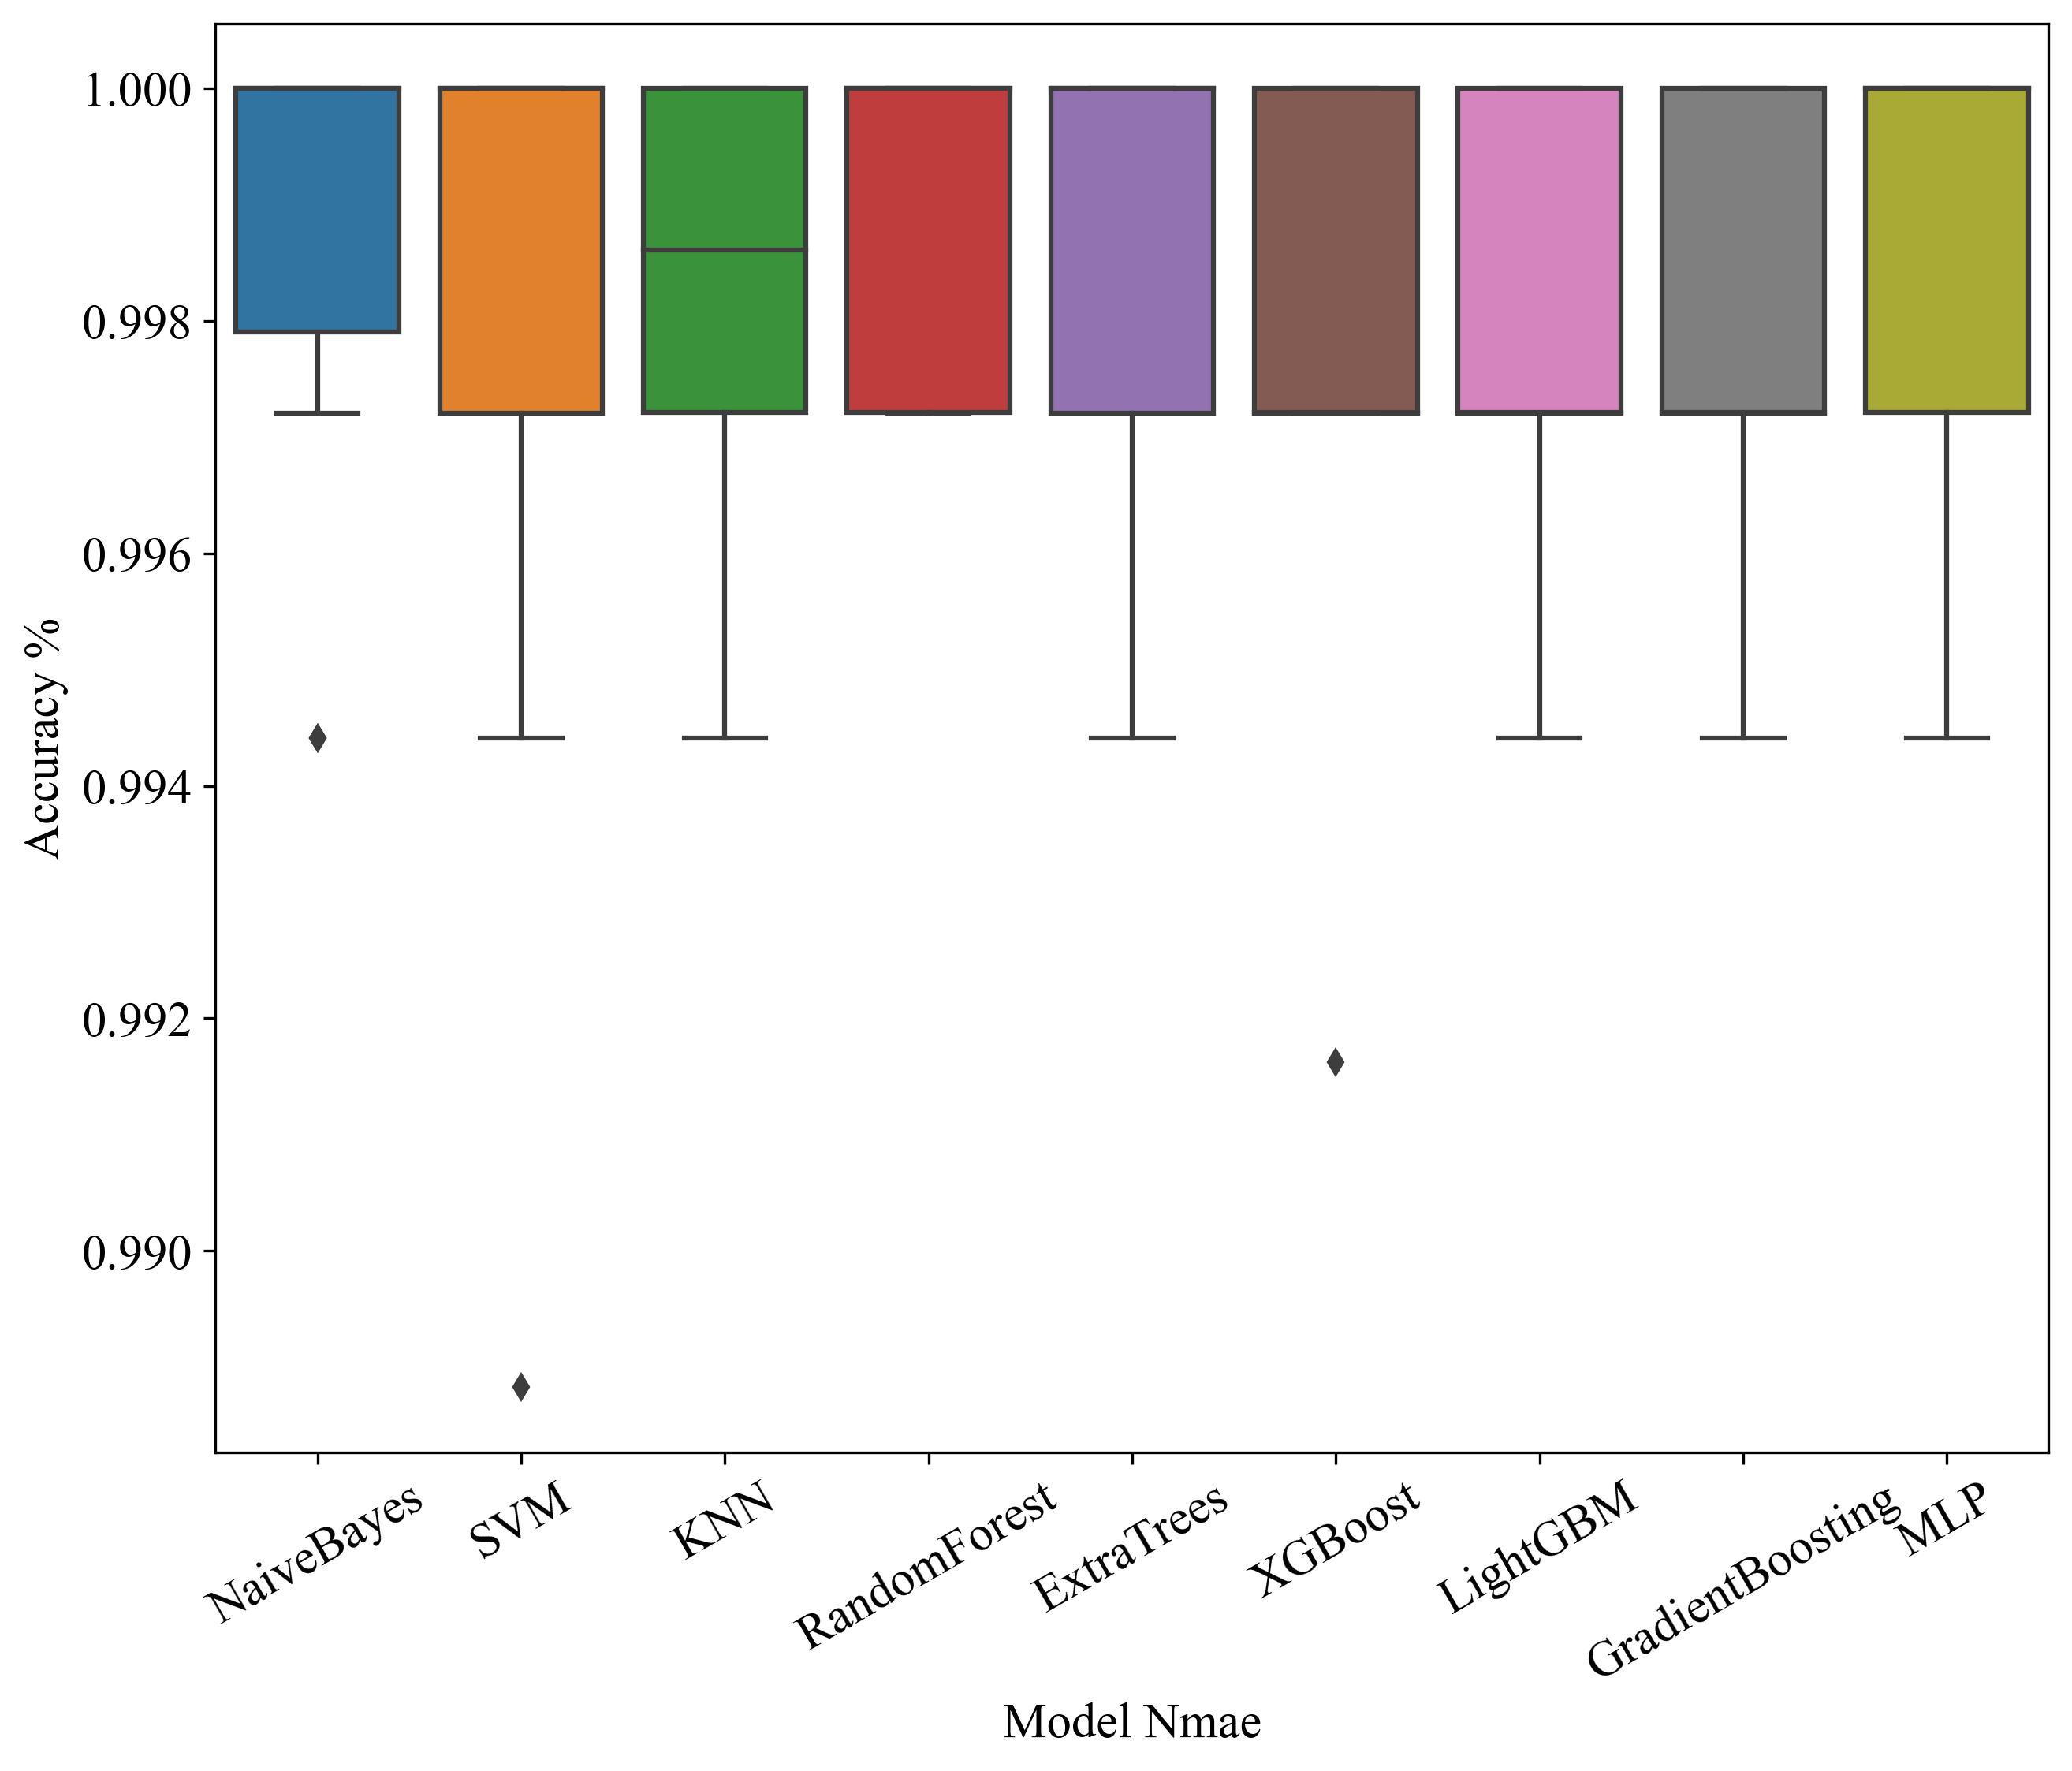

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

# 随机使用n_trails次数据划分，找到最好的一次划分方法，并且保存在results中。
results = okcomp.comp1.get_bst_split(X_data, y_data, models, test_size=0.2, metric_fn=accuracy_score, n_trails=10, cv=True, random_state=0)
_, (X_train_sel, X_test_sel, y_train_sel, y_test_sel) = results['results'][results['max_idx']]
X_train_sel, X_test_sel, y_train_sel, y_test_sel = X_data, X_test_data, y_data, y_test_data
trails, _ = zip(*results['results'])
cv_results = pd.DataFrame(trails, columns=model_names)
# 可视化每个模型在不同的数据划分中的效果。
sns.boxplot(data=cv_results)
plt.ylabel('Accuracy %')
plt.xticks(rotation=30)
plt.xlabel('Model Nmae')
plt.savefig(f'img/model_csv.svg', bbox_inches = 'tight')

## 模型筛选

使用最好的数据划分，进行后续的模型研究。

**注意**: 一般情况下论文使用的是随机划分的数据，但也有些论文使用【刻意】筛选的数据划分。

In [24]:
targets = []
for l in labels:
    new_models = list(okcomp.comp1.create_clf_model(model_names).values())
    for m in new_models:
        m.fit(X_train_sel, y_train_sel[l])
        y_pred = m.predict(X_test_sel)
    targets.append(new_models)

## 预测结果

* predictions，二维数据，每个label对应的每个模型的预测结果。
* pred_scores，二维数据，每个label对应的每个模型的预测概率值。

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from onekey_algo.custom.components.delong import calc_95_CI
from onekey_algo.custom.components.metrics import calc_sens_spec

predictions = [[(model.predict(X_train_sel), model.predict(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]
pred_scores = [[(model.predict_proba(X_train_sel), model.predict_proba(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]

metric = []
pred_sel_idx = []
for label, prediction, scores in zip(labels, predictions, pred_scores):
    pred_sel_idx_label = []
    for mname, (train_pred, test_pred), (train_score, test_score) in zip(model_names, prediction, scores):
        # 计算训练集指数
        metric.append((mname, accuracy_score(y_train_sel[label], train_pred), f"{label}-train"))
                 
        # 计算验证集指标
        metric.append((mname, accuracy_score(y_test_sel[label], test_pred), f"{label}-test"))
    
    pred_sel_idx.append(pred_sel_idx_label)
metric = pd.DataFrame(metric, index=None, columns=['model_name', 'Accuracy', 'Task'])
metric

model_name  Accuracy         Task
0         NaiveBayes     0.999  label-train
1         NaiveBayes     0.997   label-test
2                SVM     1.000  label-train
3                SVM     0.995   label-test
4                KNN     0.998  label-train
5                KNN     0.995   label-test
6       RandomForest     1.000  label-train
7       RandomForest     0.996   label-test
8         ExtraTrees     1.000  label-train
9         ExtraTrees     0.996   label-test
10           XGBoost     1.000  label-train
11           XGBoost     0.997   label-test
12          LightGBM     1.000  label-train
13          LightGBM     0.994   label-test
14  GradientBoosting     1.000  label-train
15  GradientBoosting     0.998   label-test
16               MLP     1.000  label-train
17               MLP     0.992   label-test

### 绘制曲线

绘制的不同模型的准确率柱状图和折线图曲线。

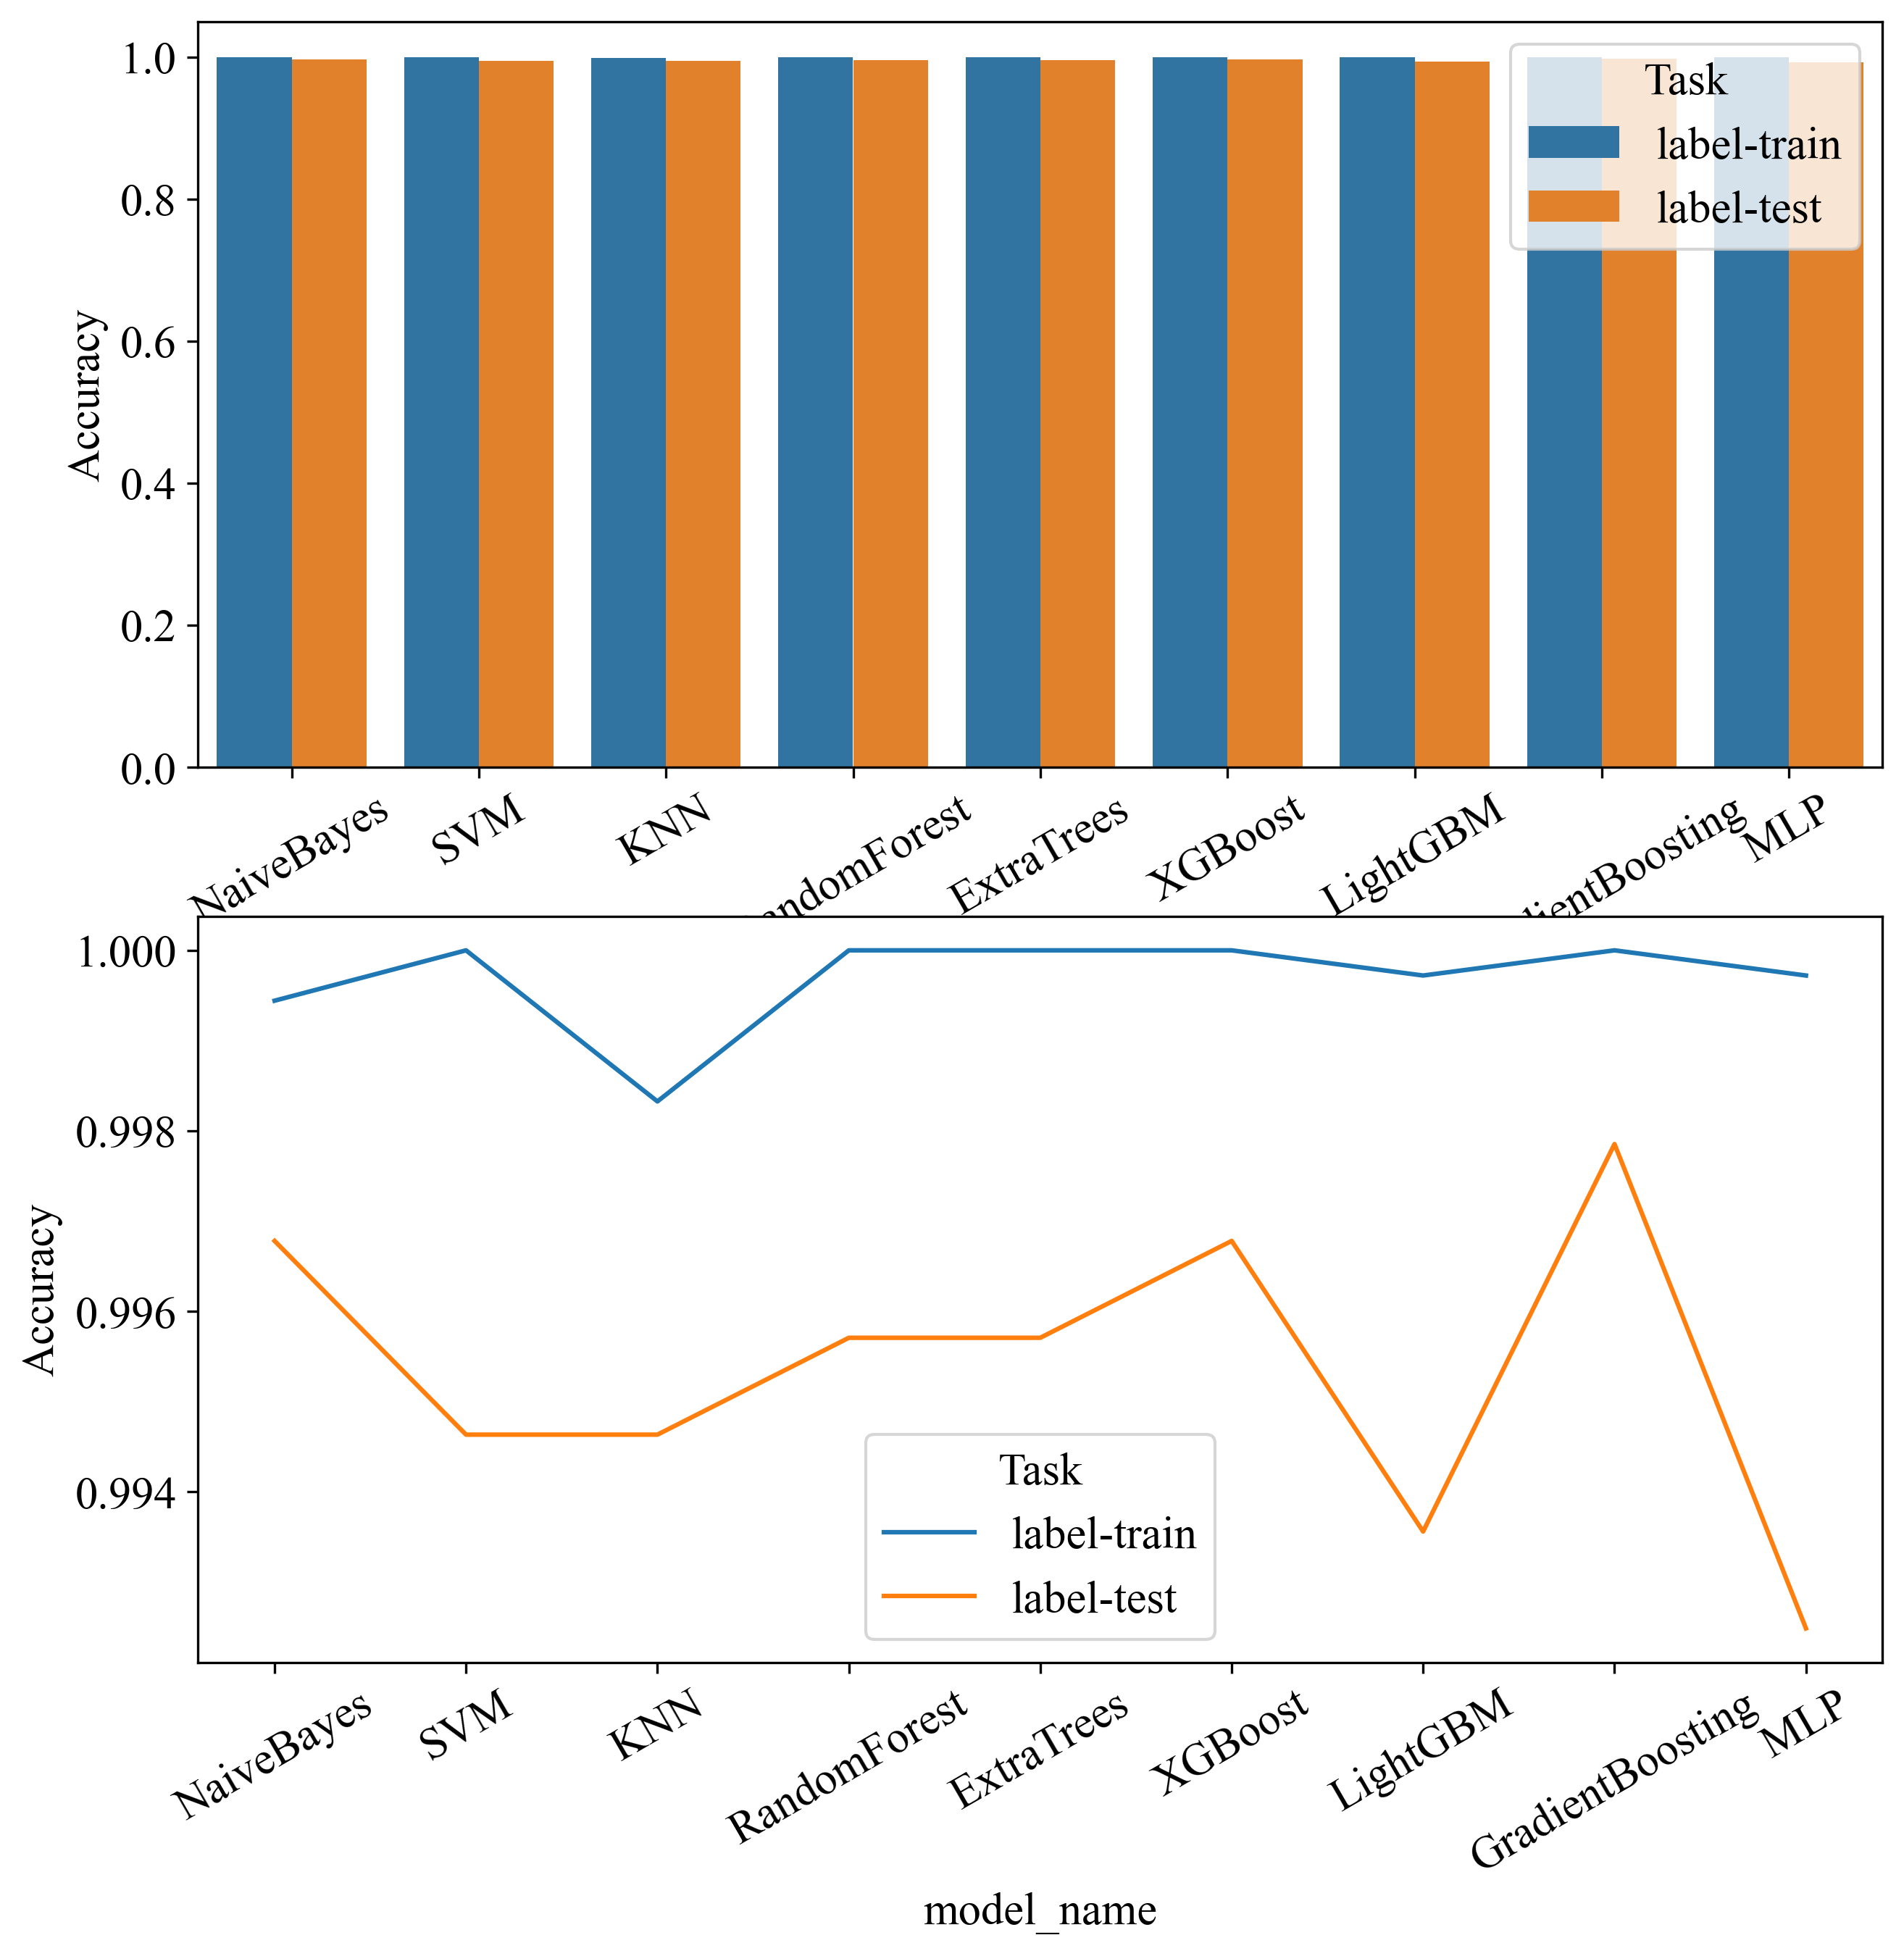

In [26]:
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.xticks(rotation=30)
sns.barplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.subplot(212)
plt.xticks(rotation=30)
sns.lineplot(x='model_name', y='Accuracy', data=metric, hue='Task')
plt.savefig(f'img/model_acc.svg', bbox_inches = 'tight')

### 绘制ROC曲线
确定最好的模型，并且绘制曲线。

```python
def draw_roc_per_class(y_test, y_score, n_classes, title='ROC per Class', include_spec_class: bool = True):
    """
    
    Args:
        y_test: 真实标签
        y_score: 预测标签
        n_classes: 类别数
        title: 标题
        include_spec_class: 是否包括每个细分标签的ROC曲线。

    Returns:

    """
```

`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

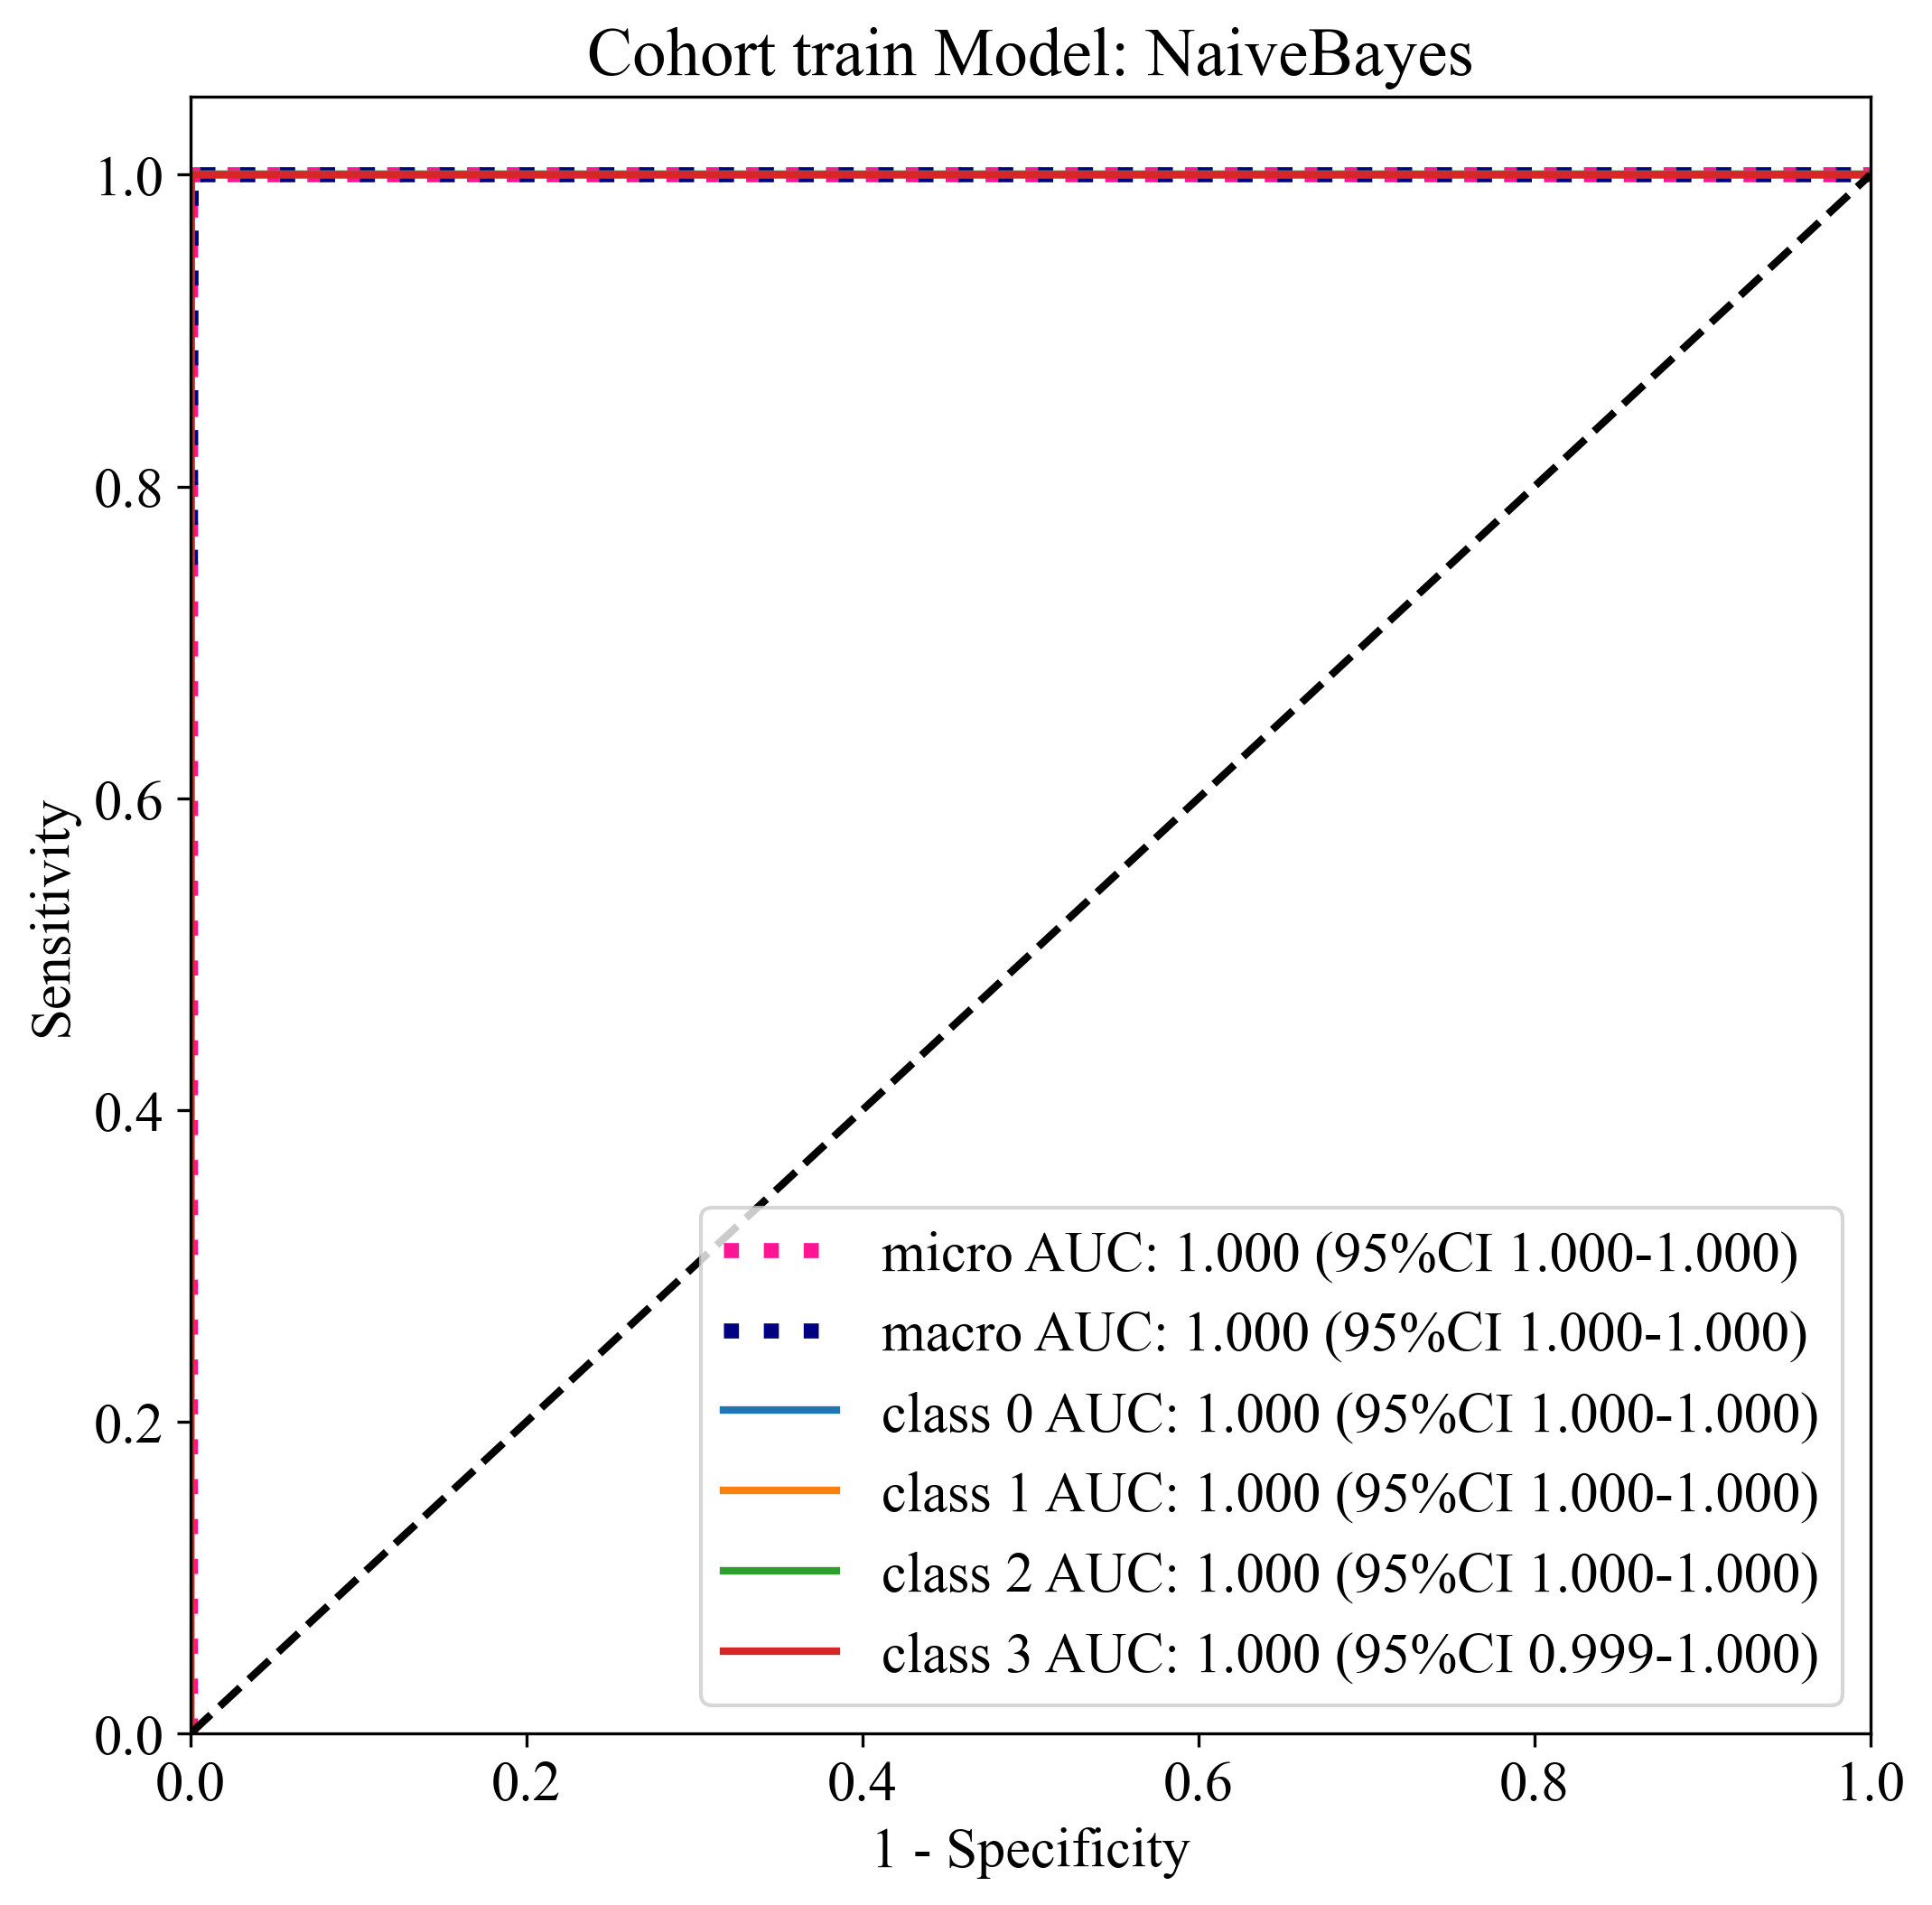

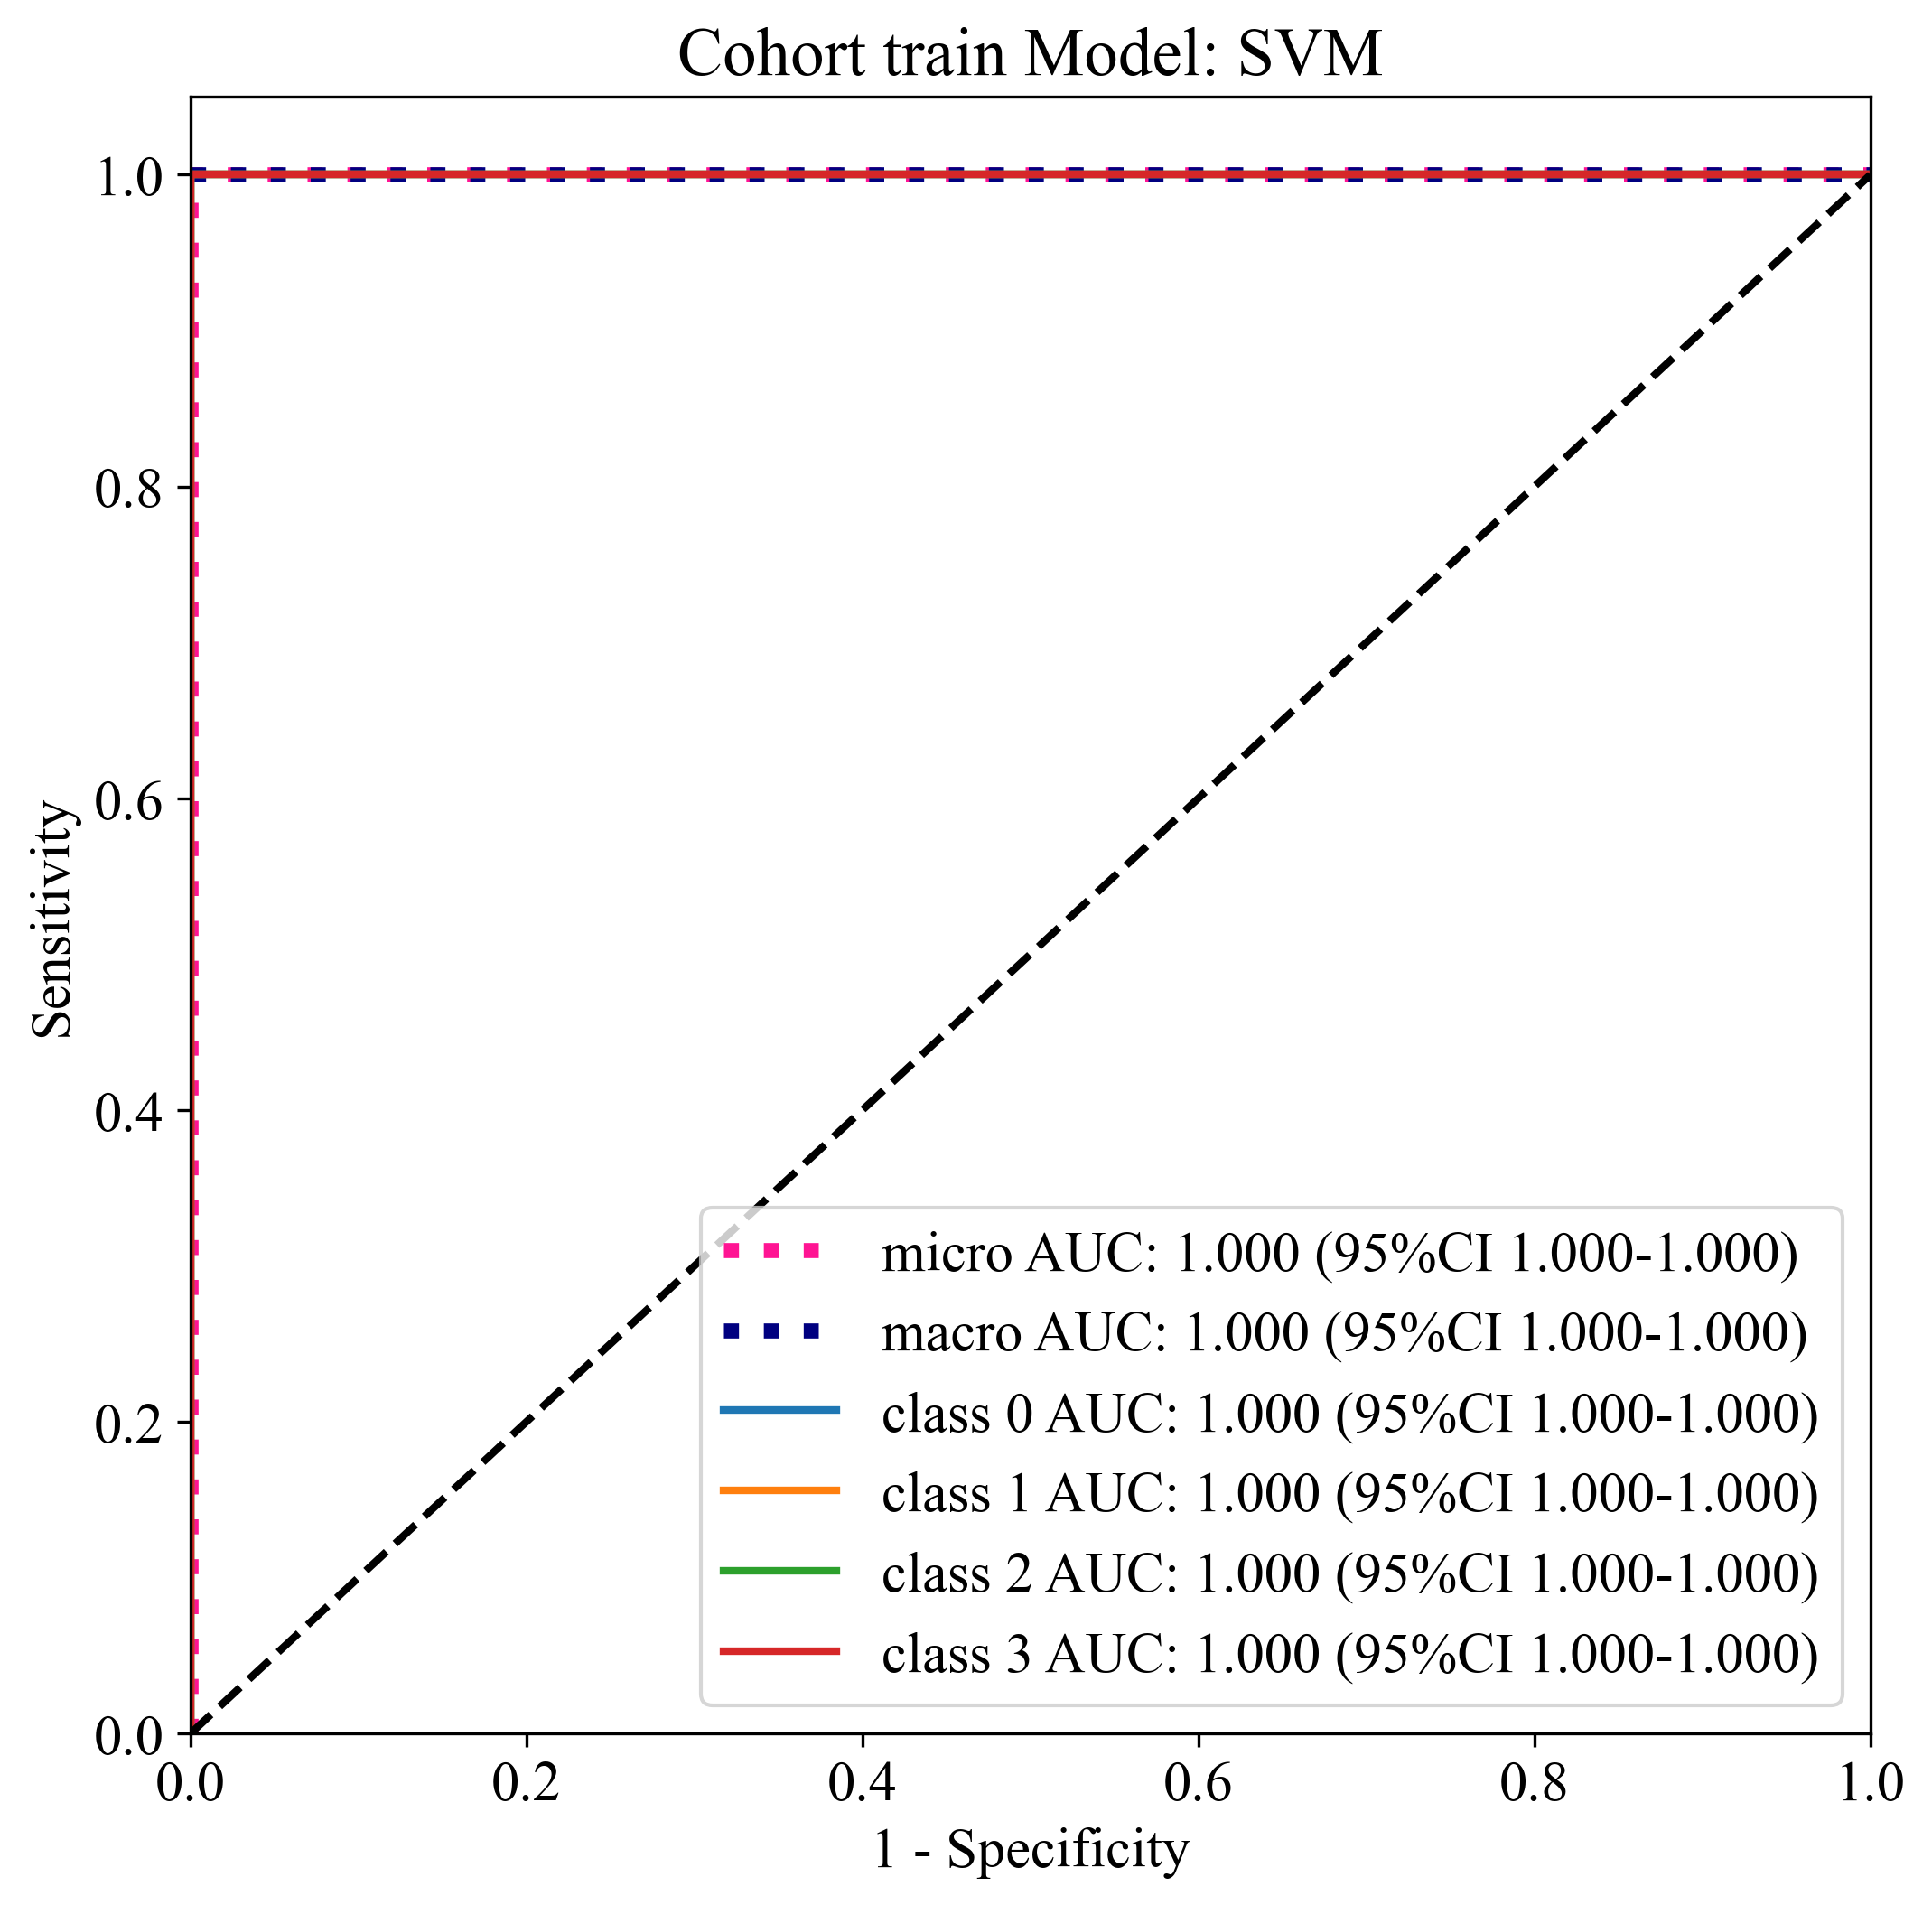

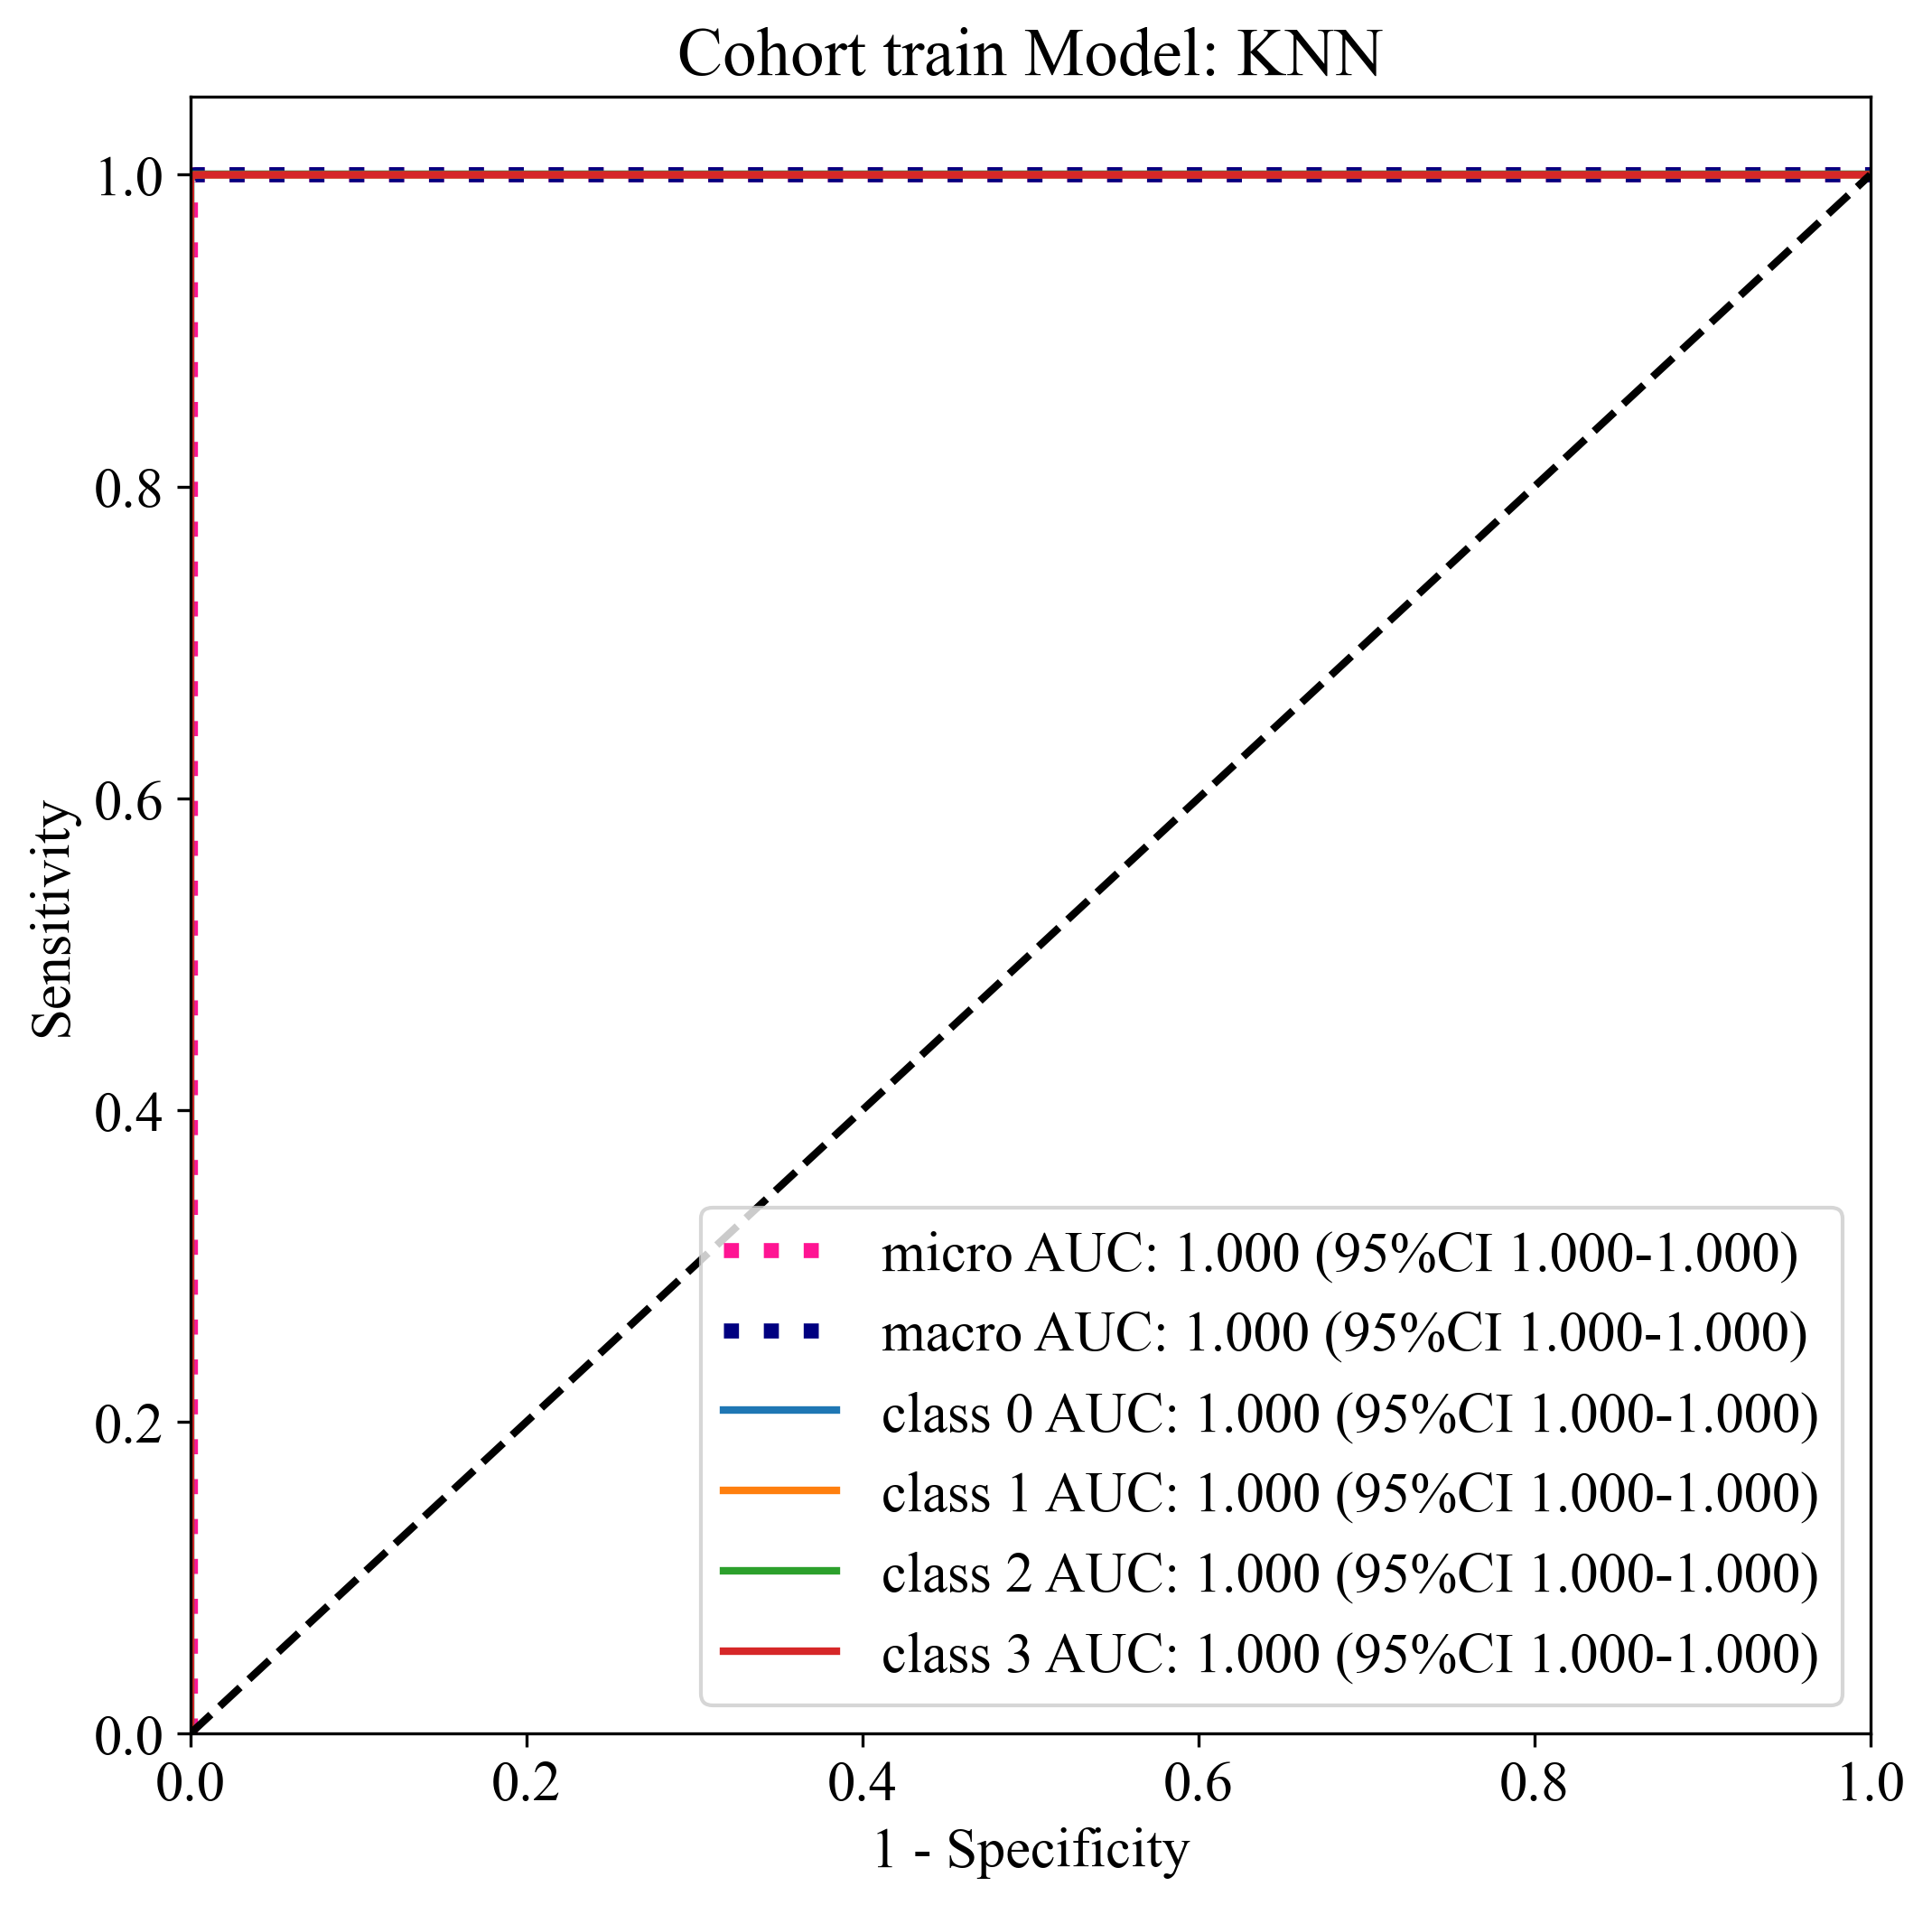

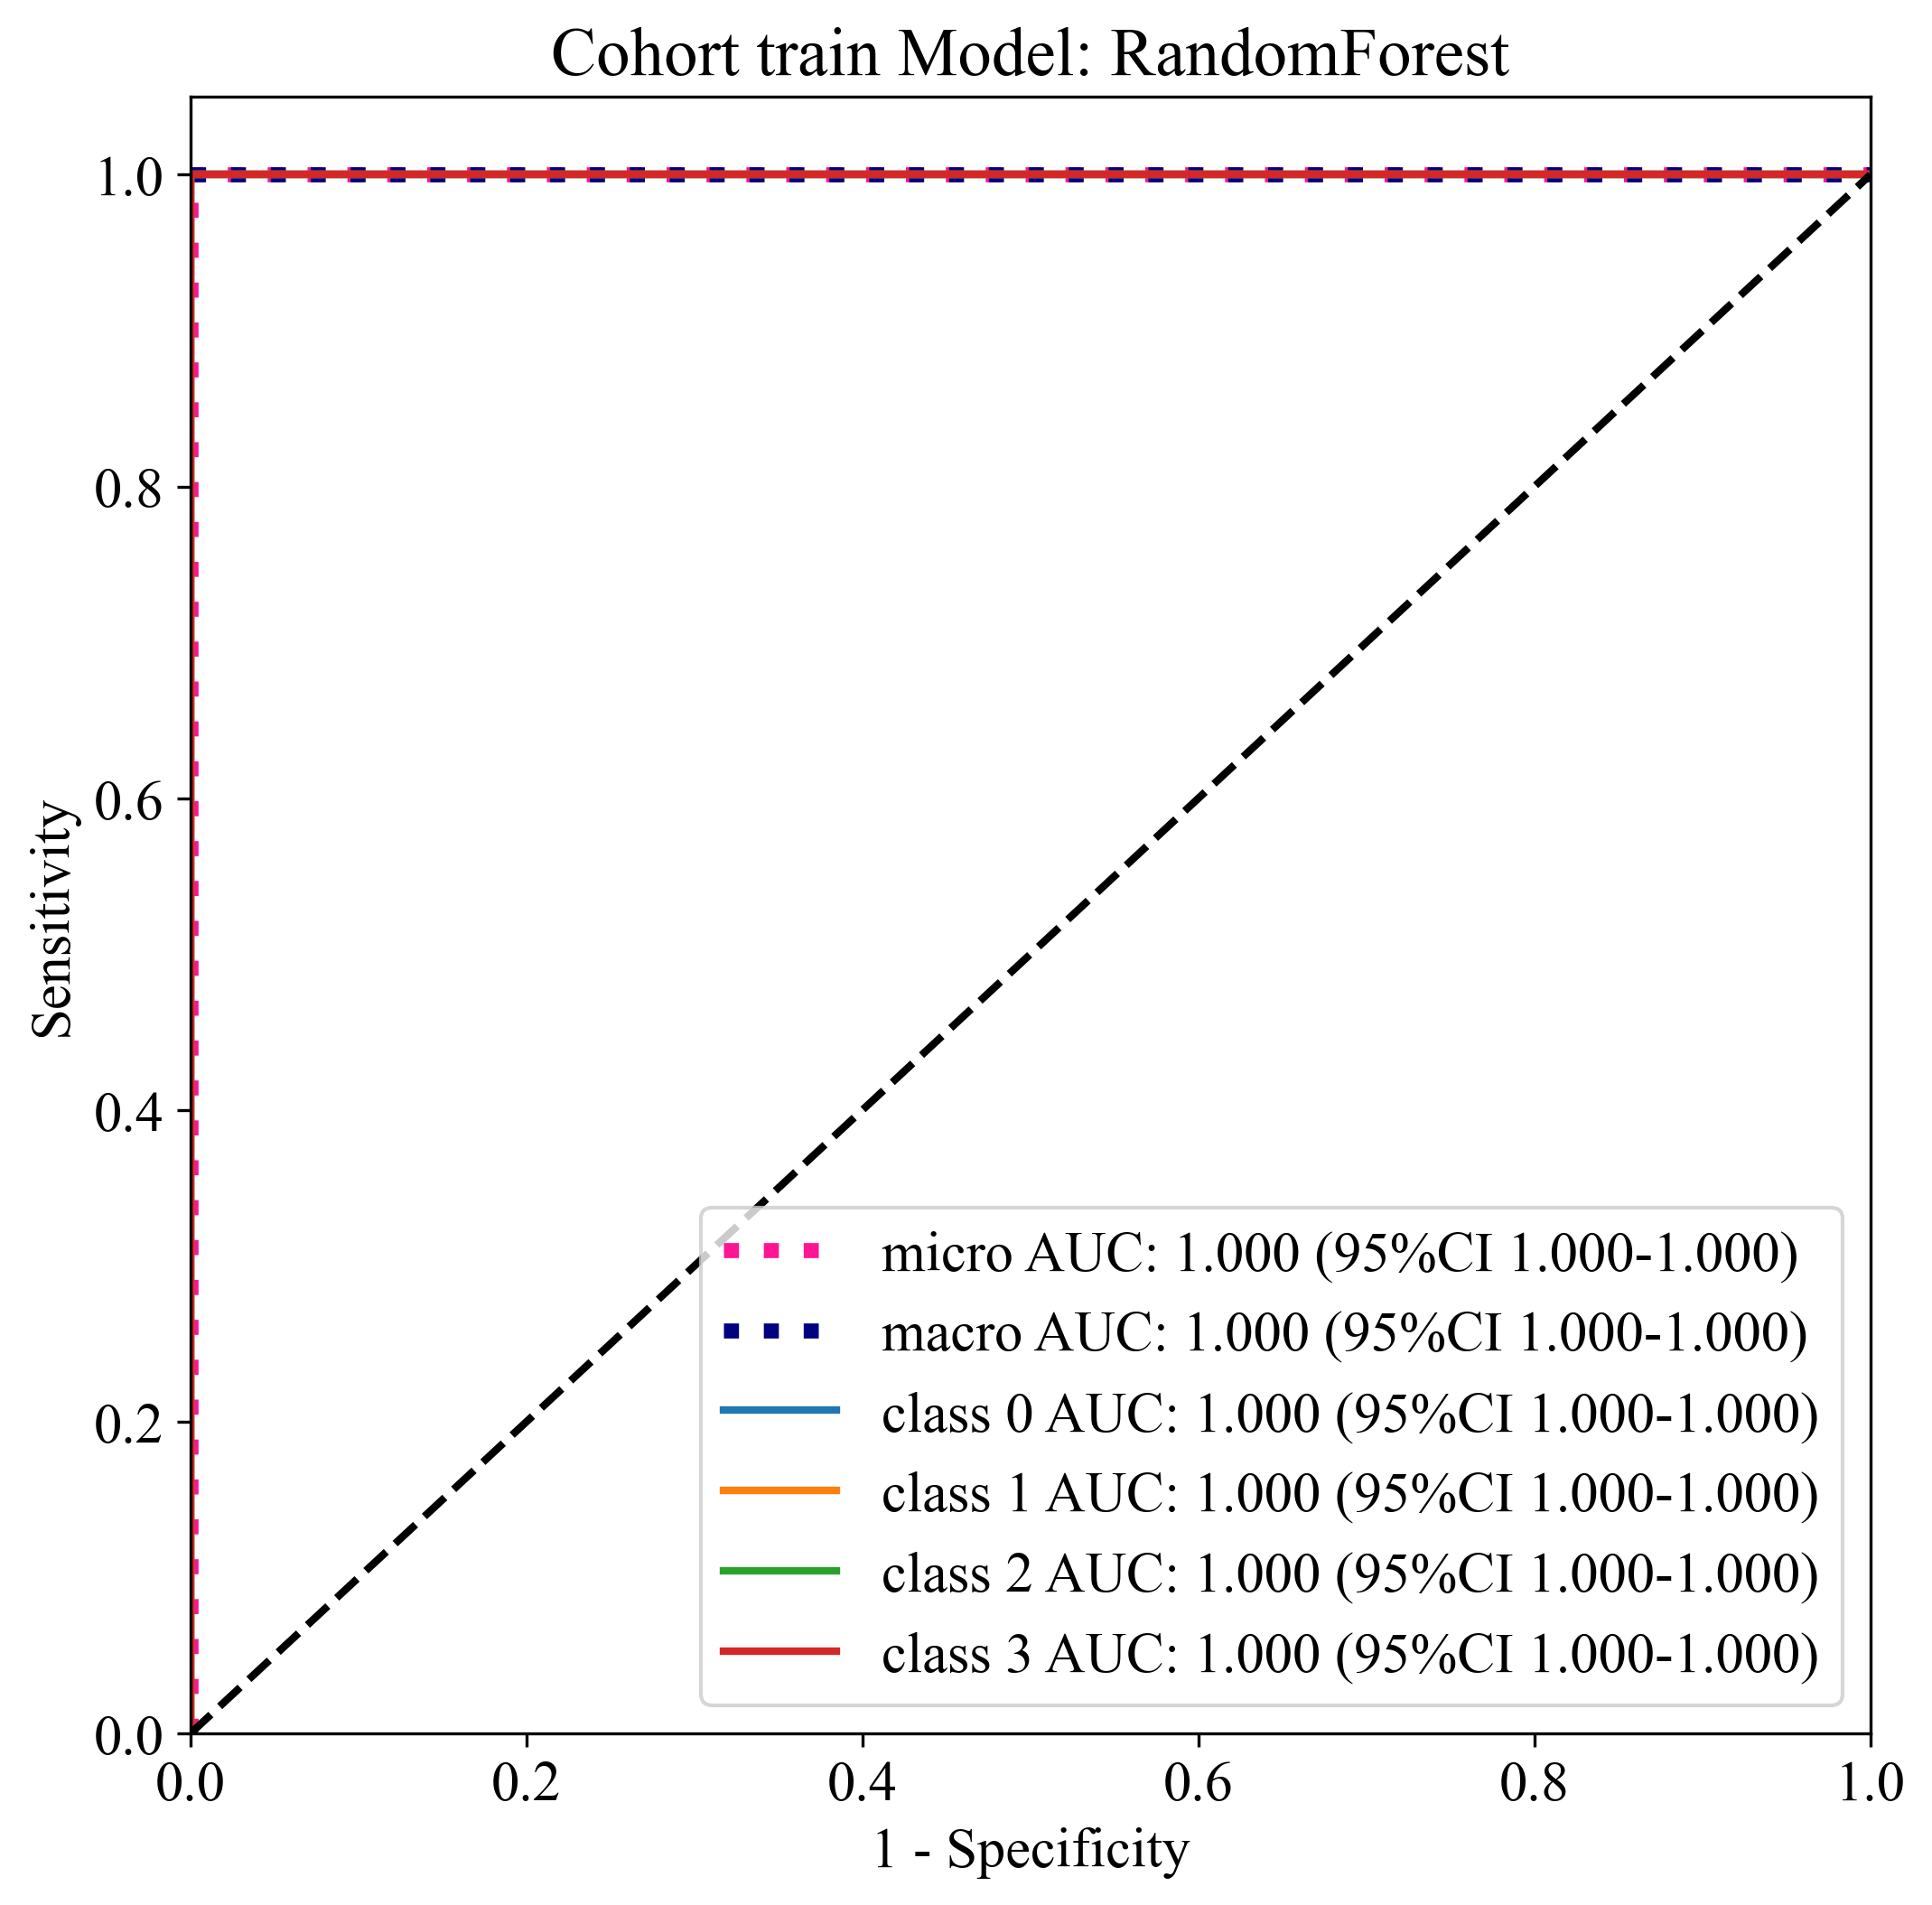

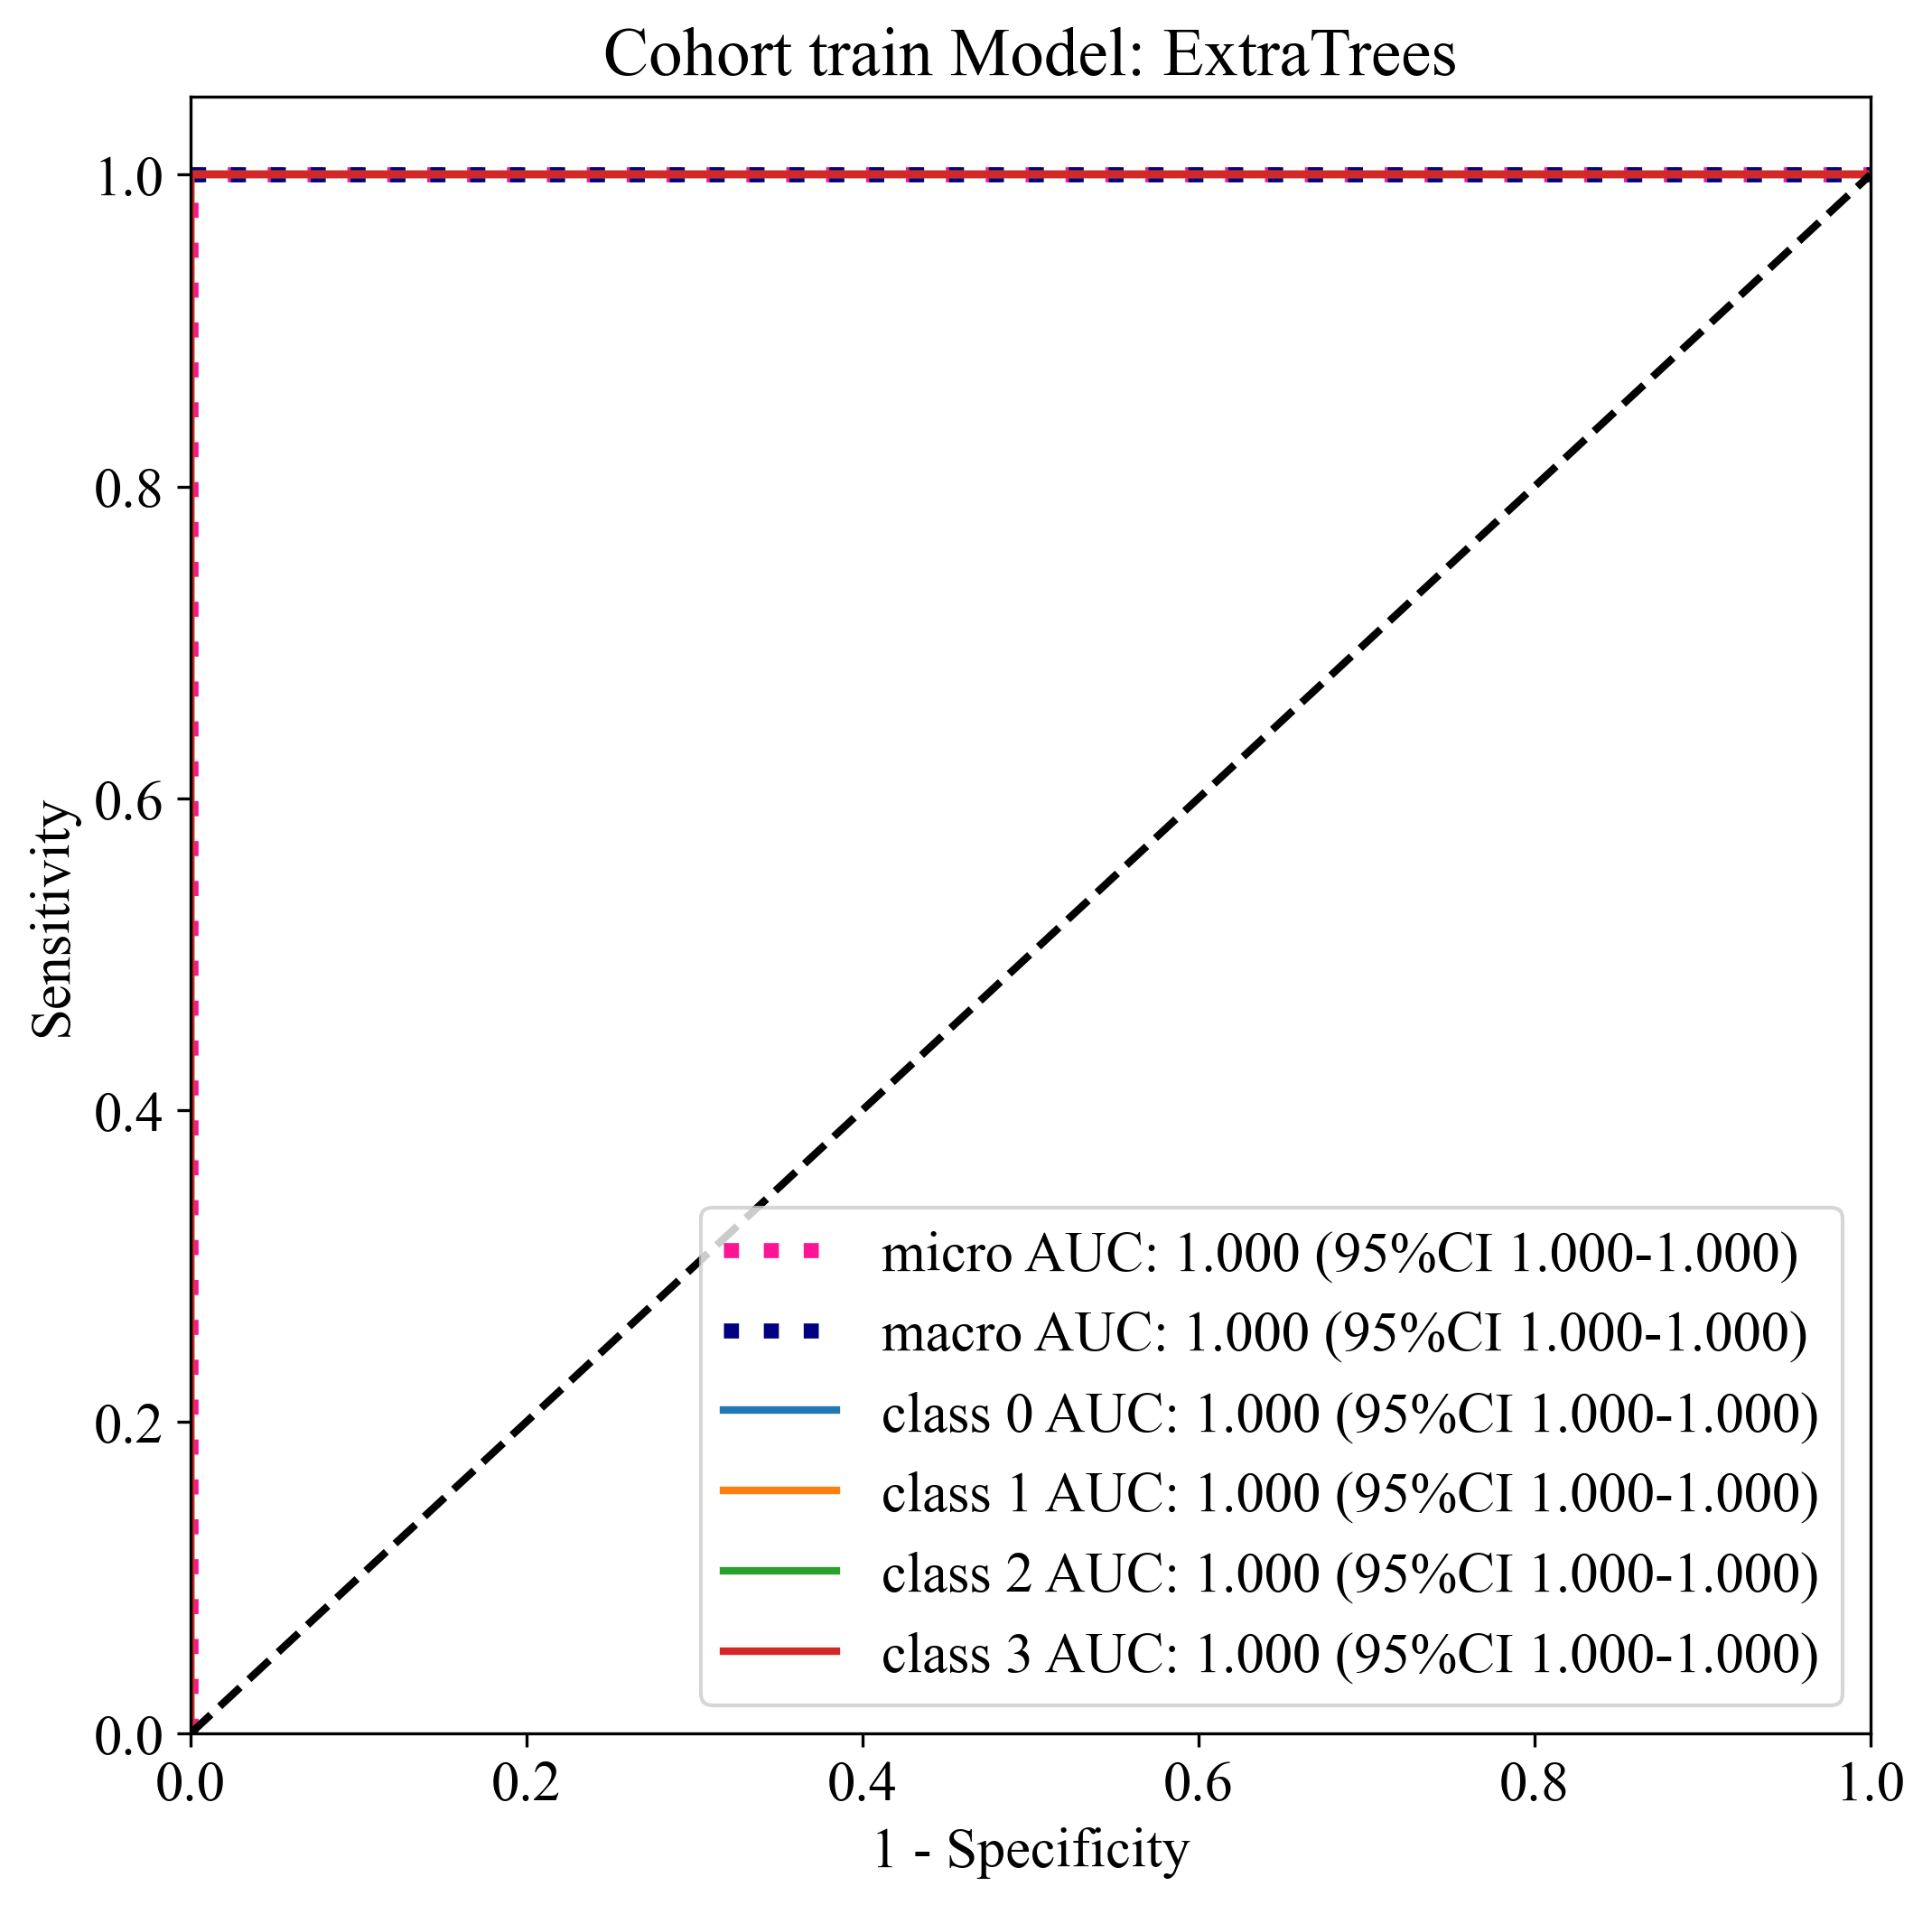

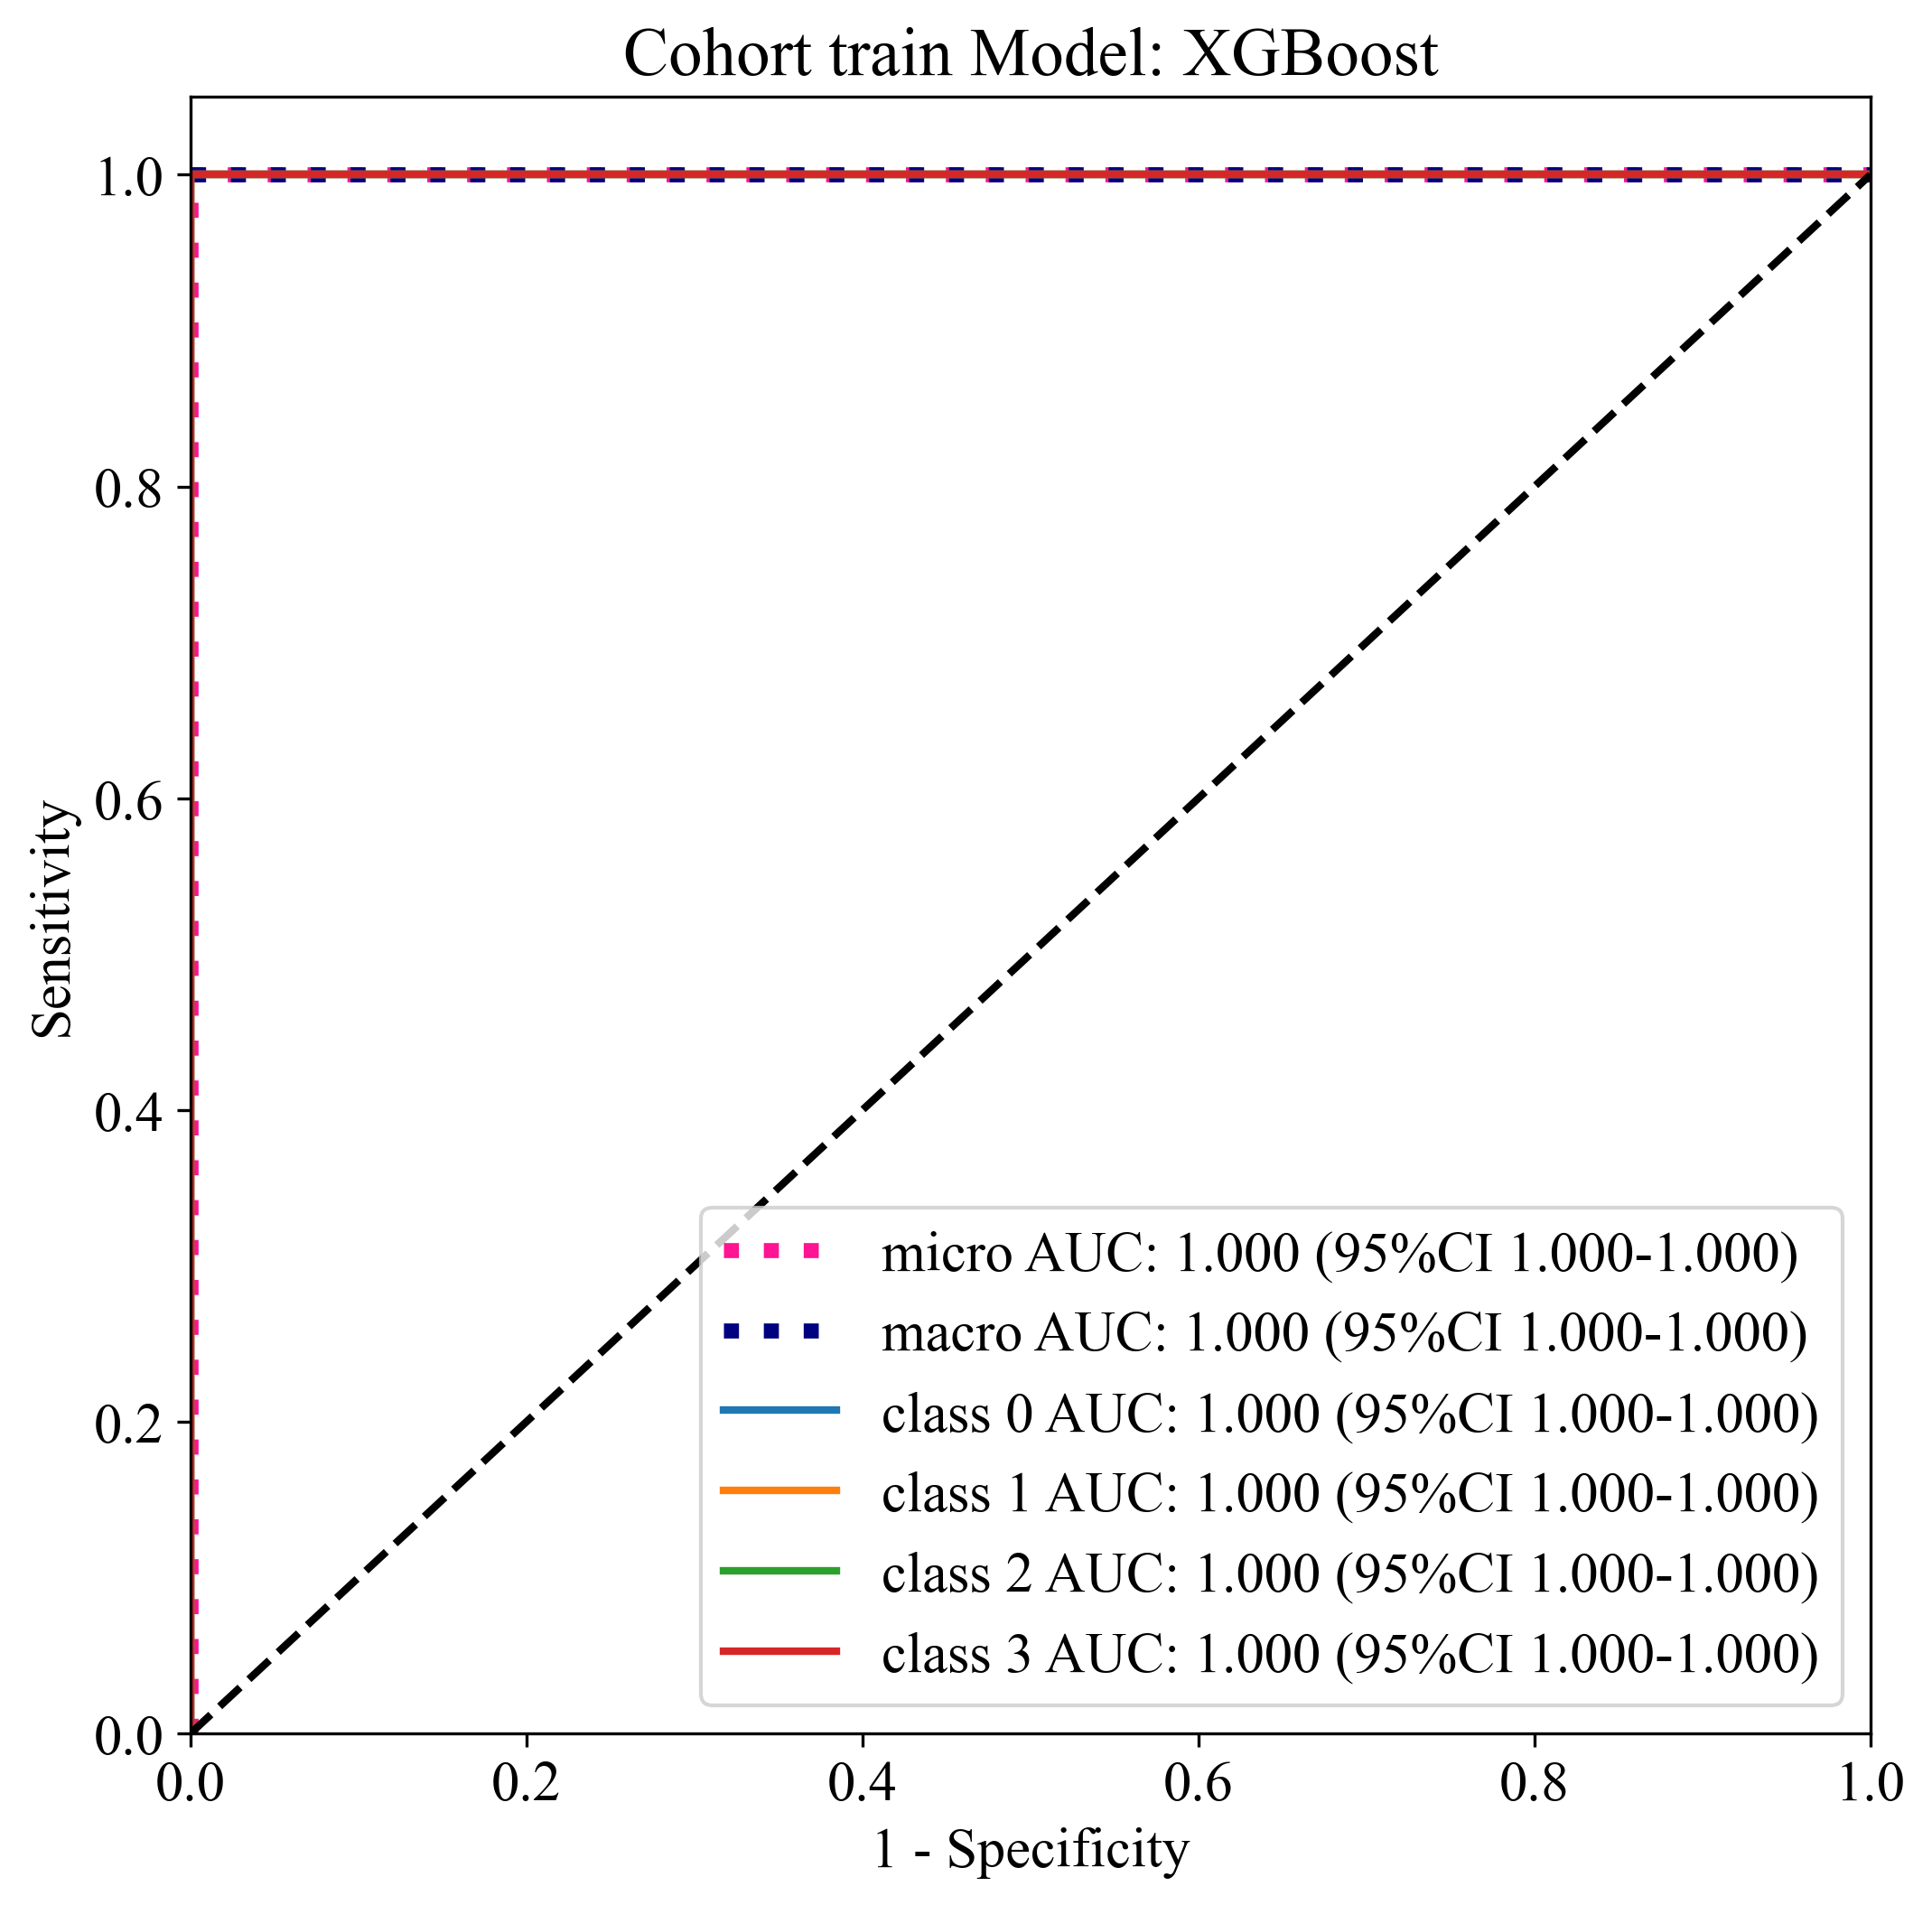

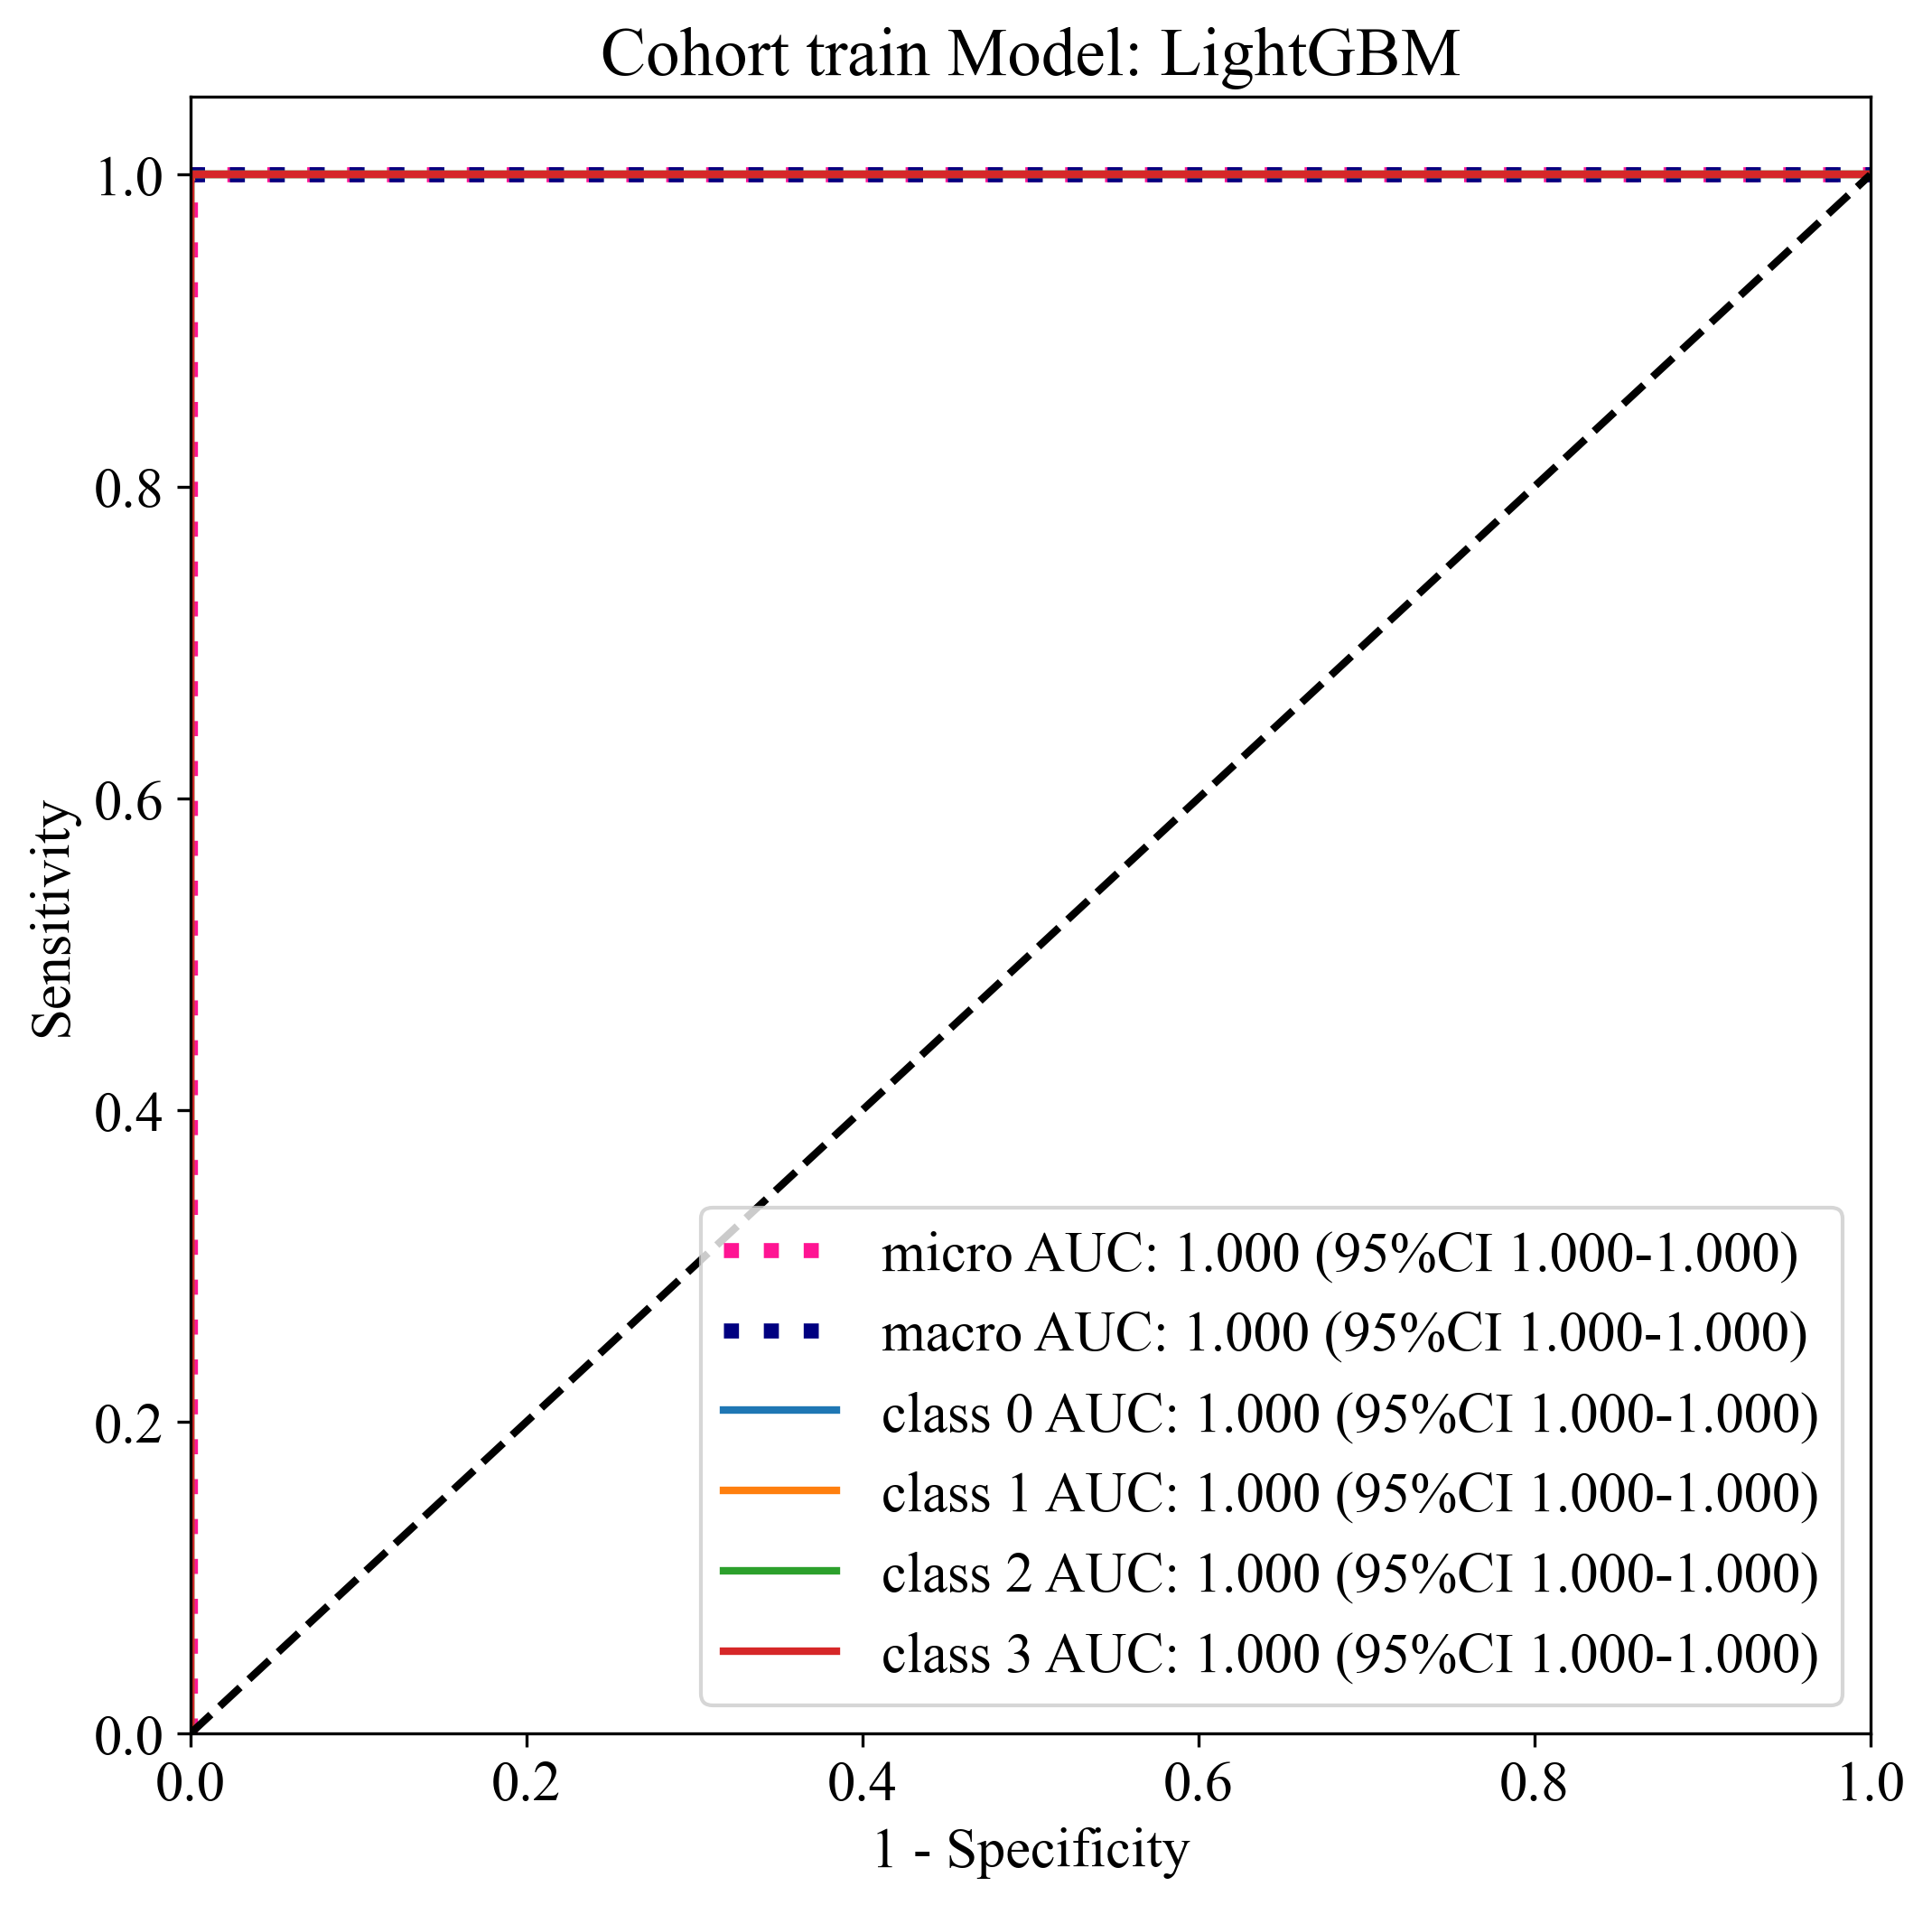

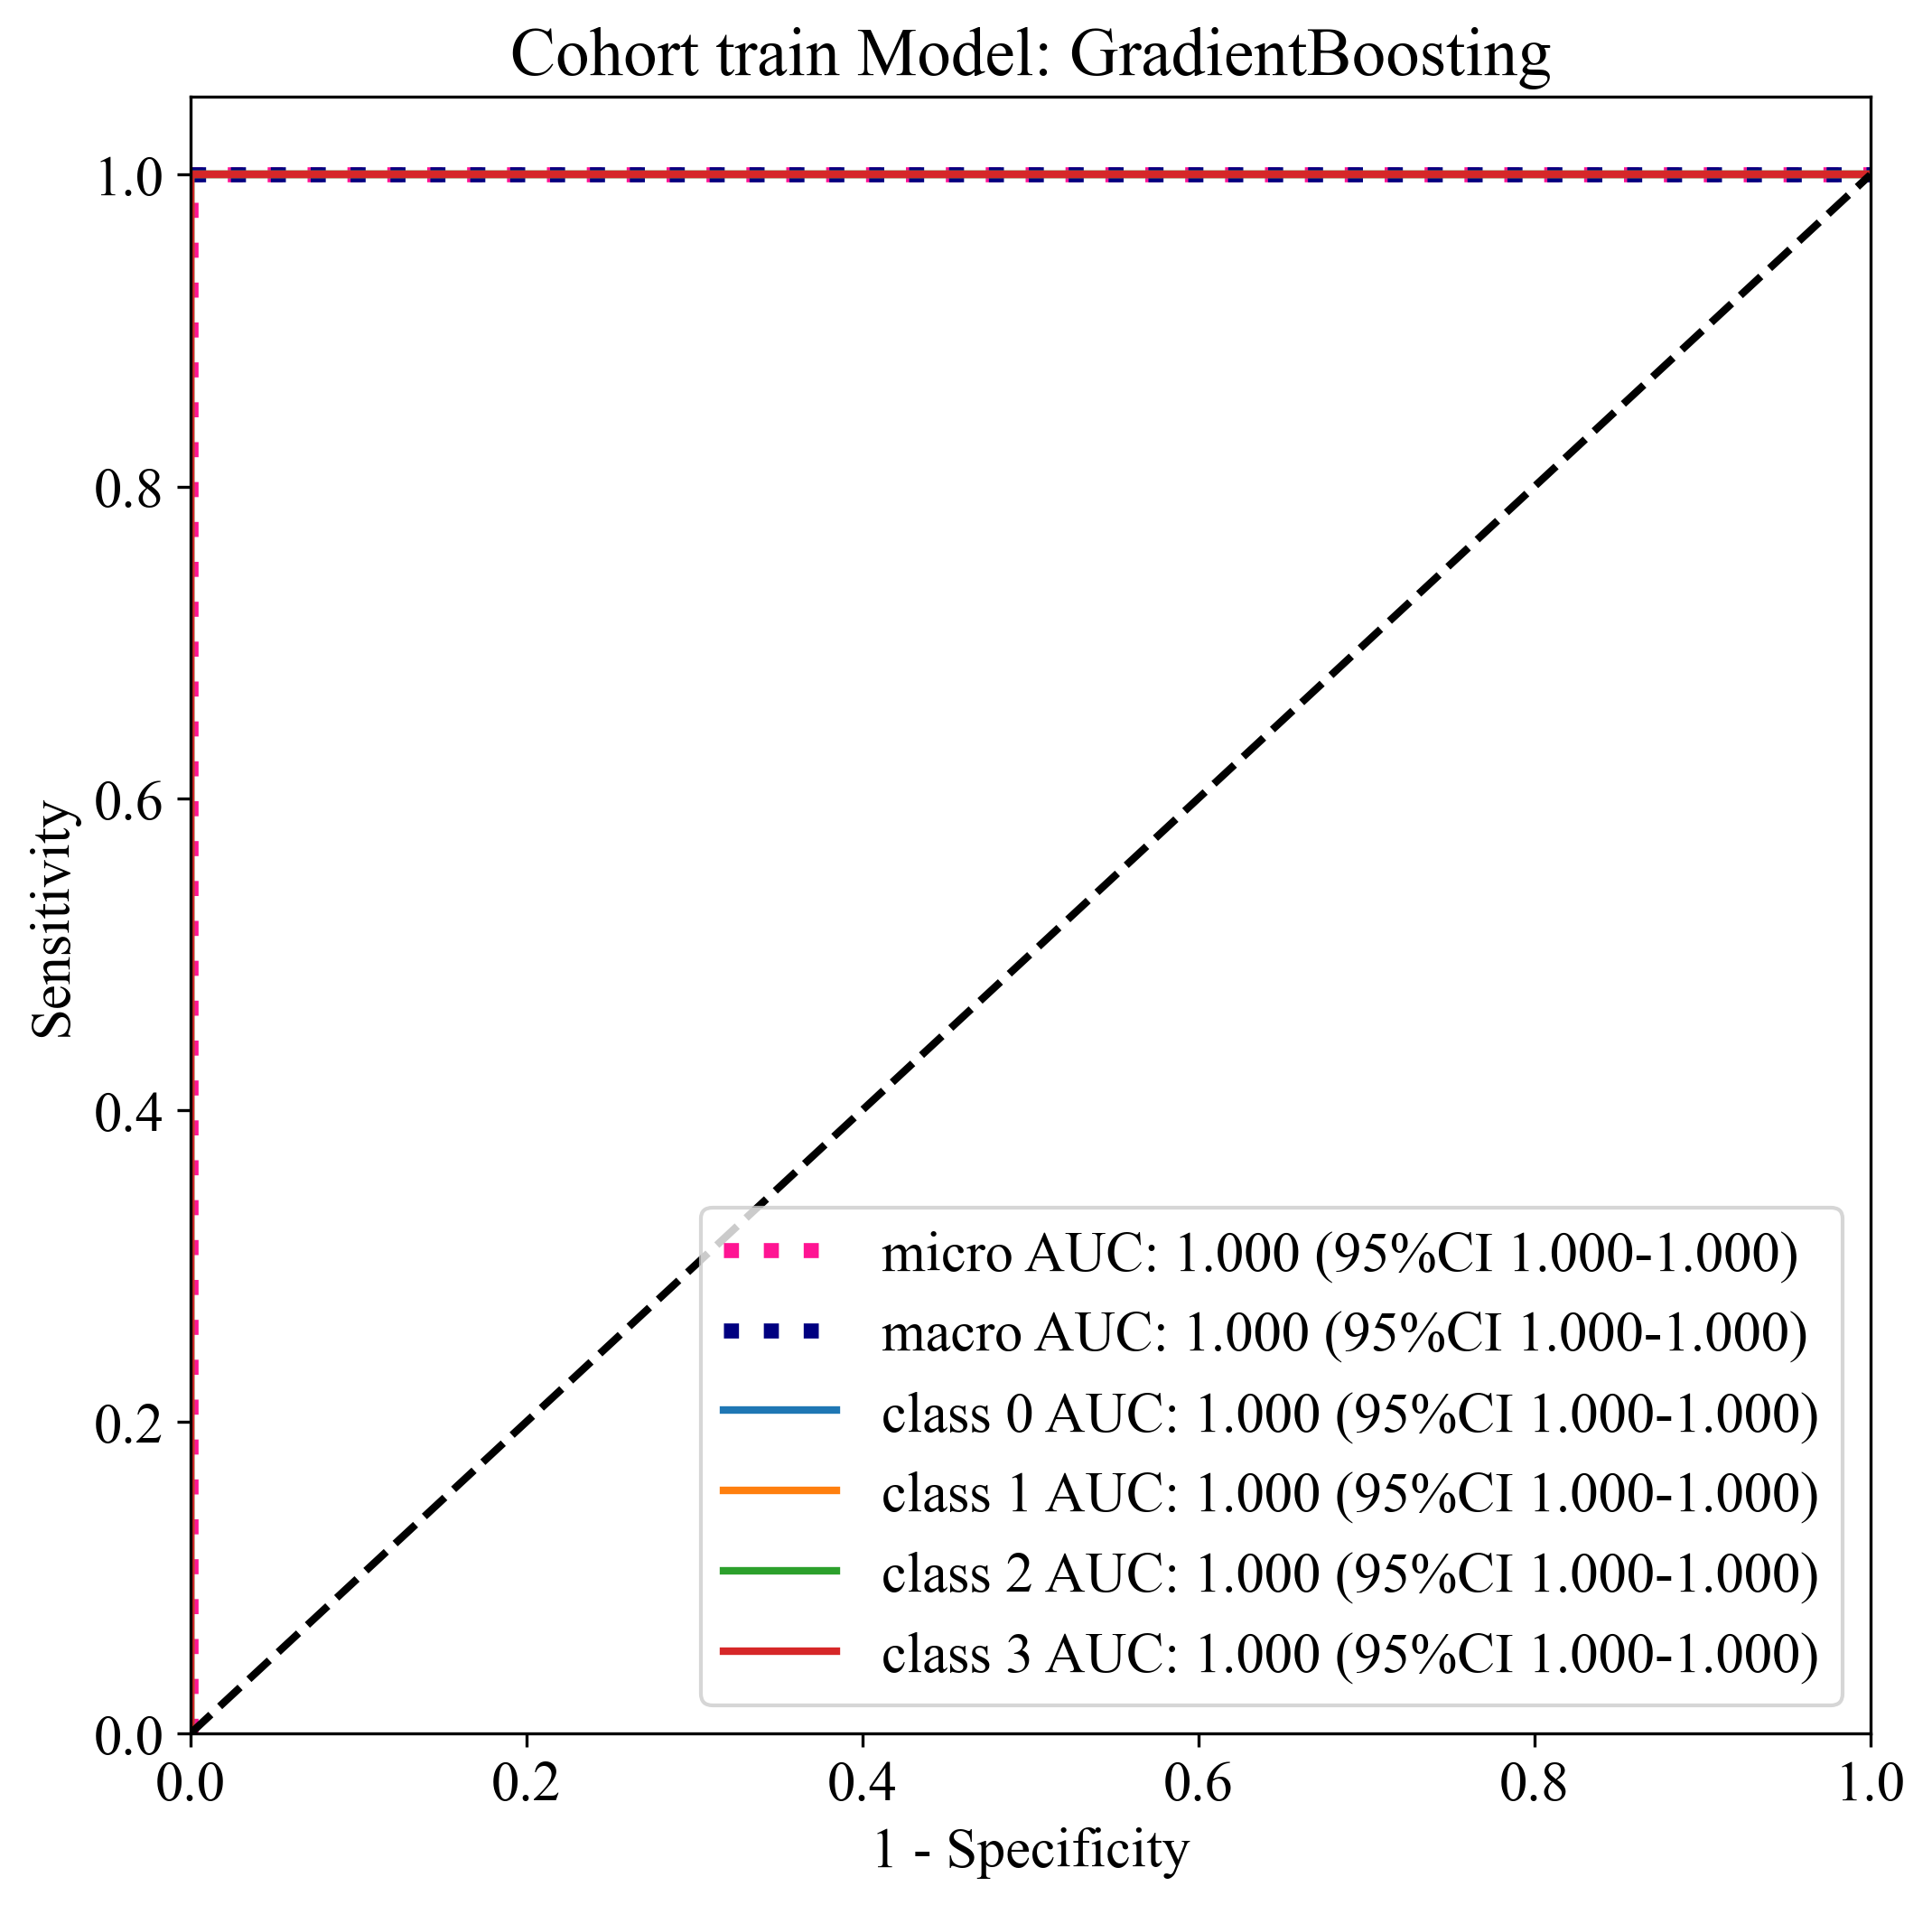

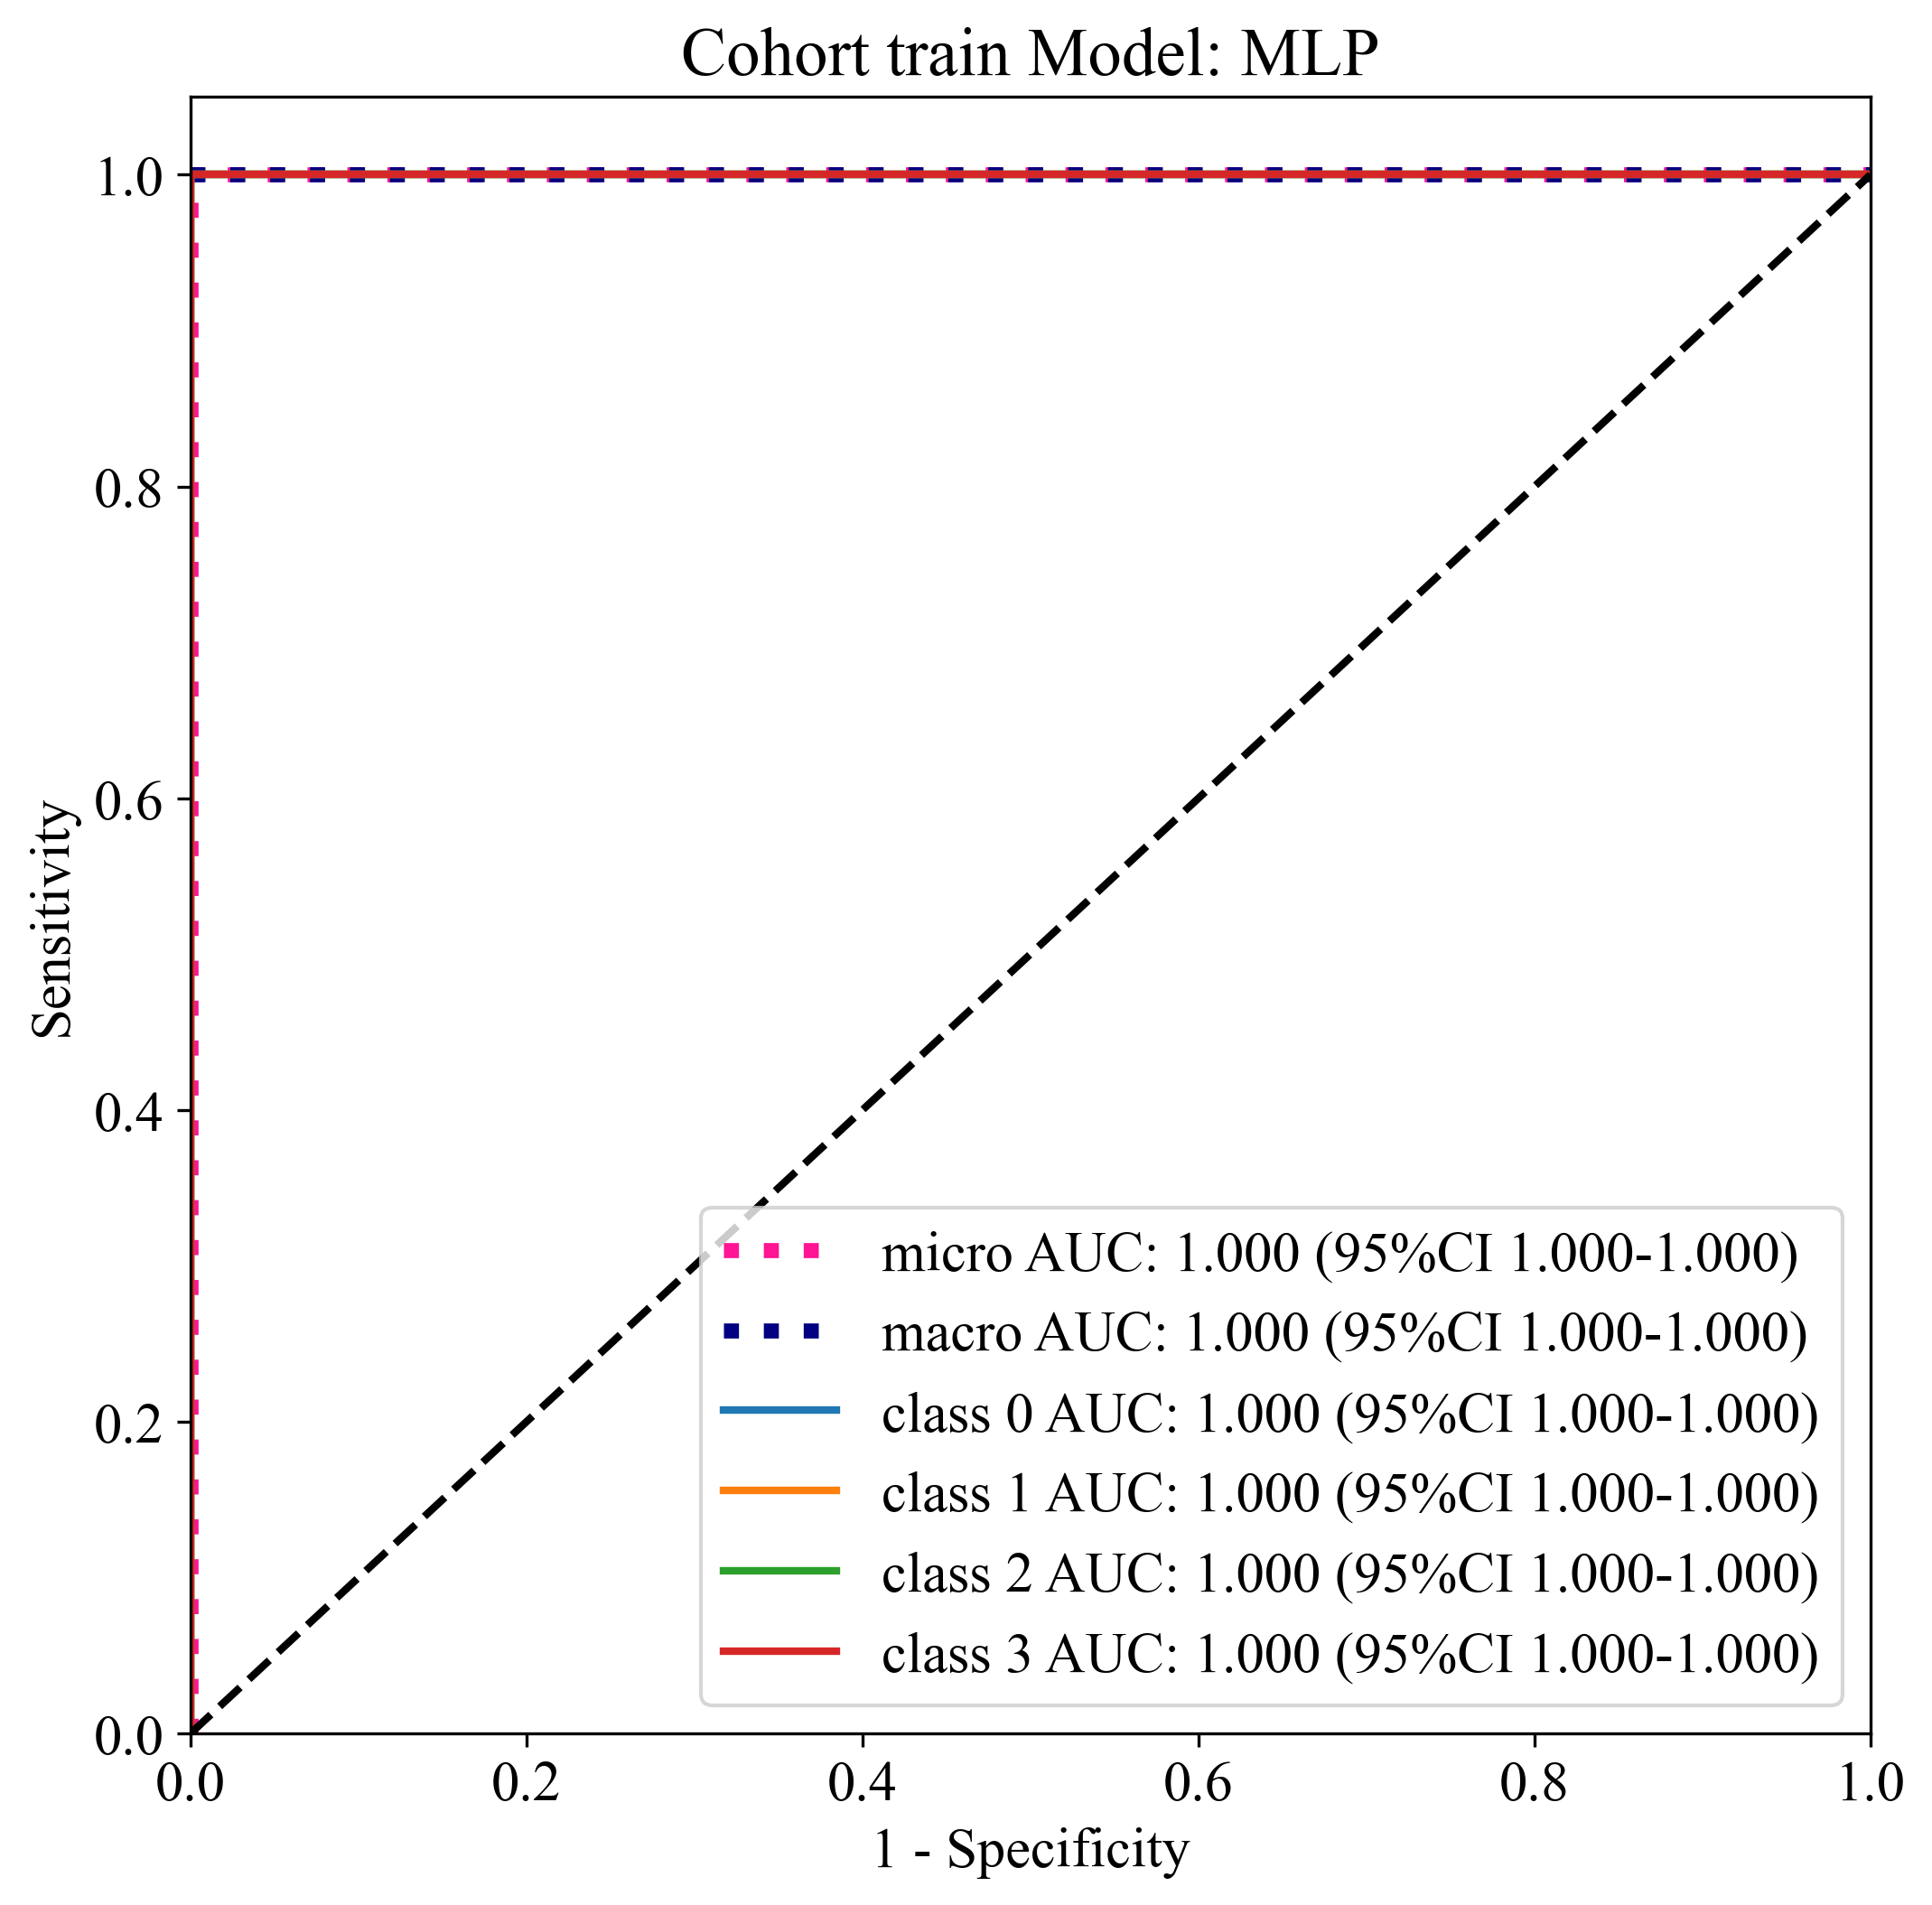

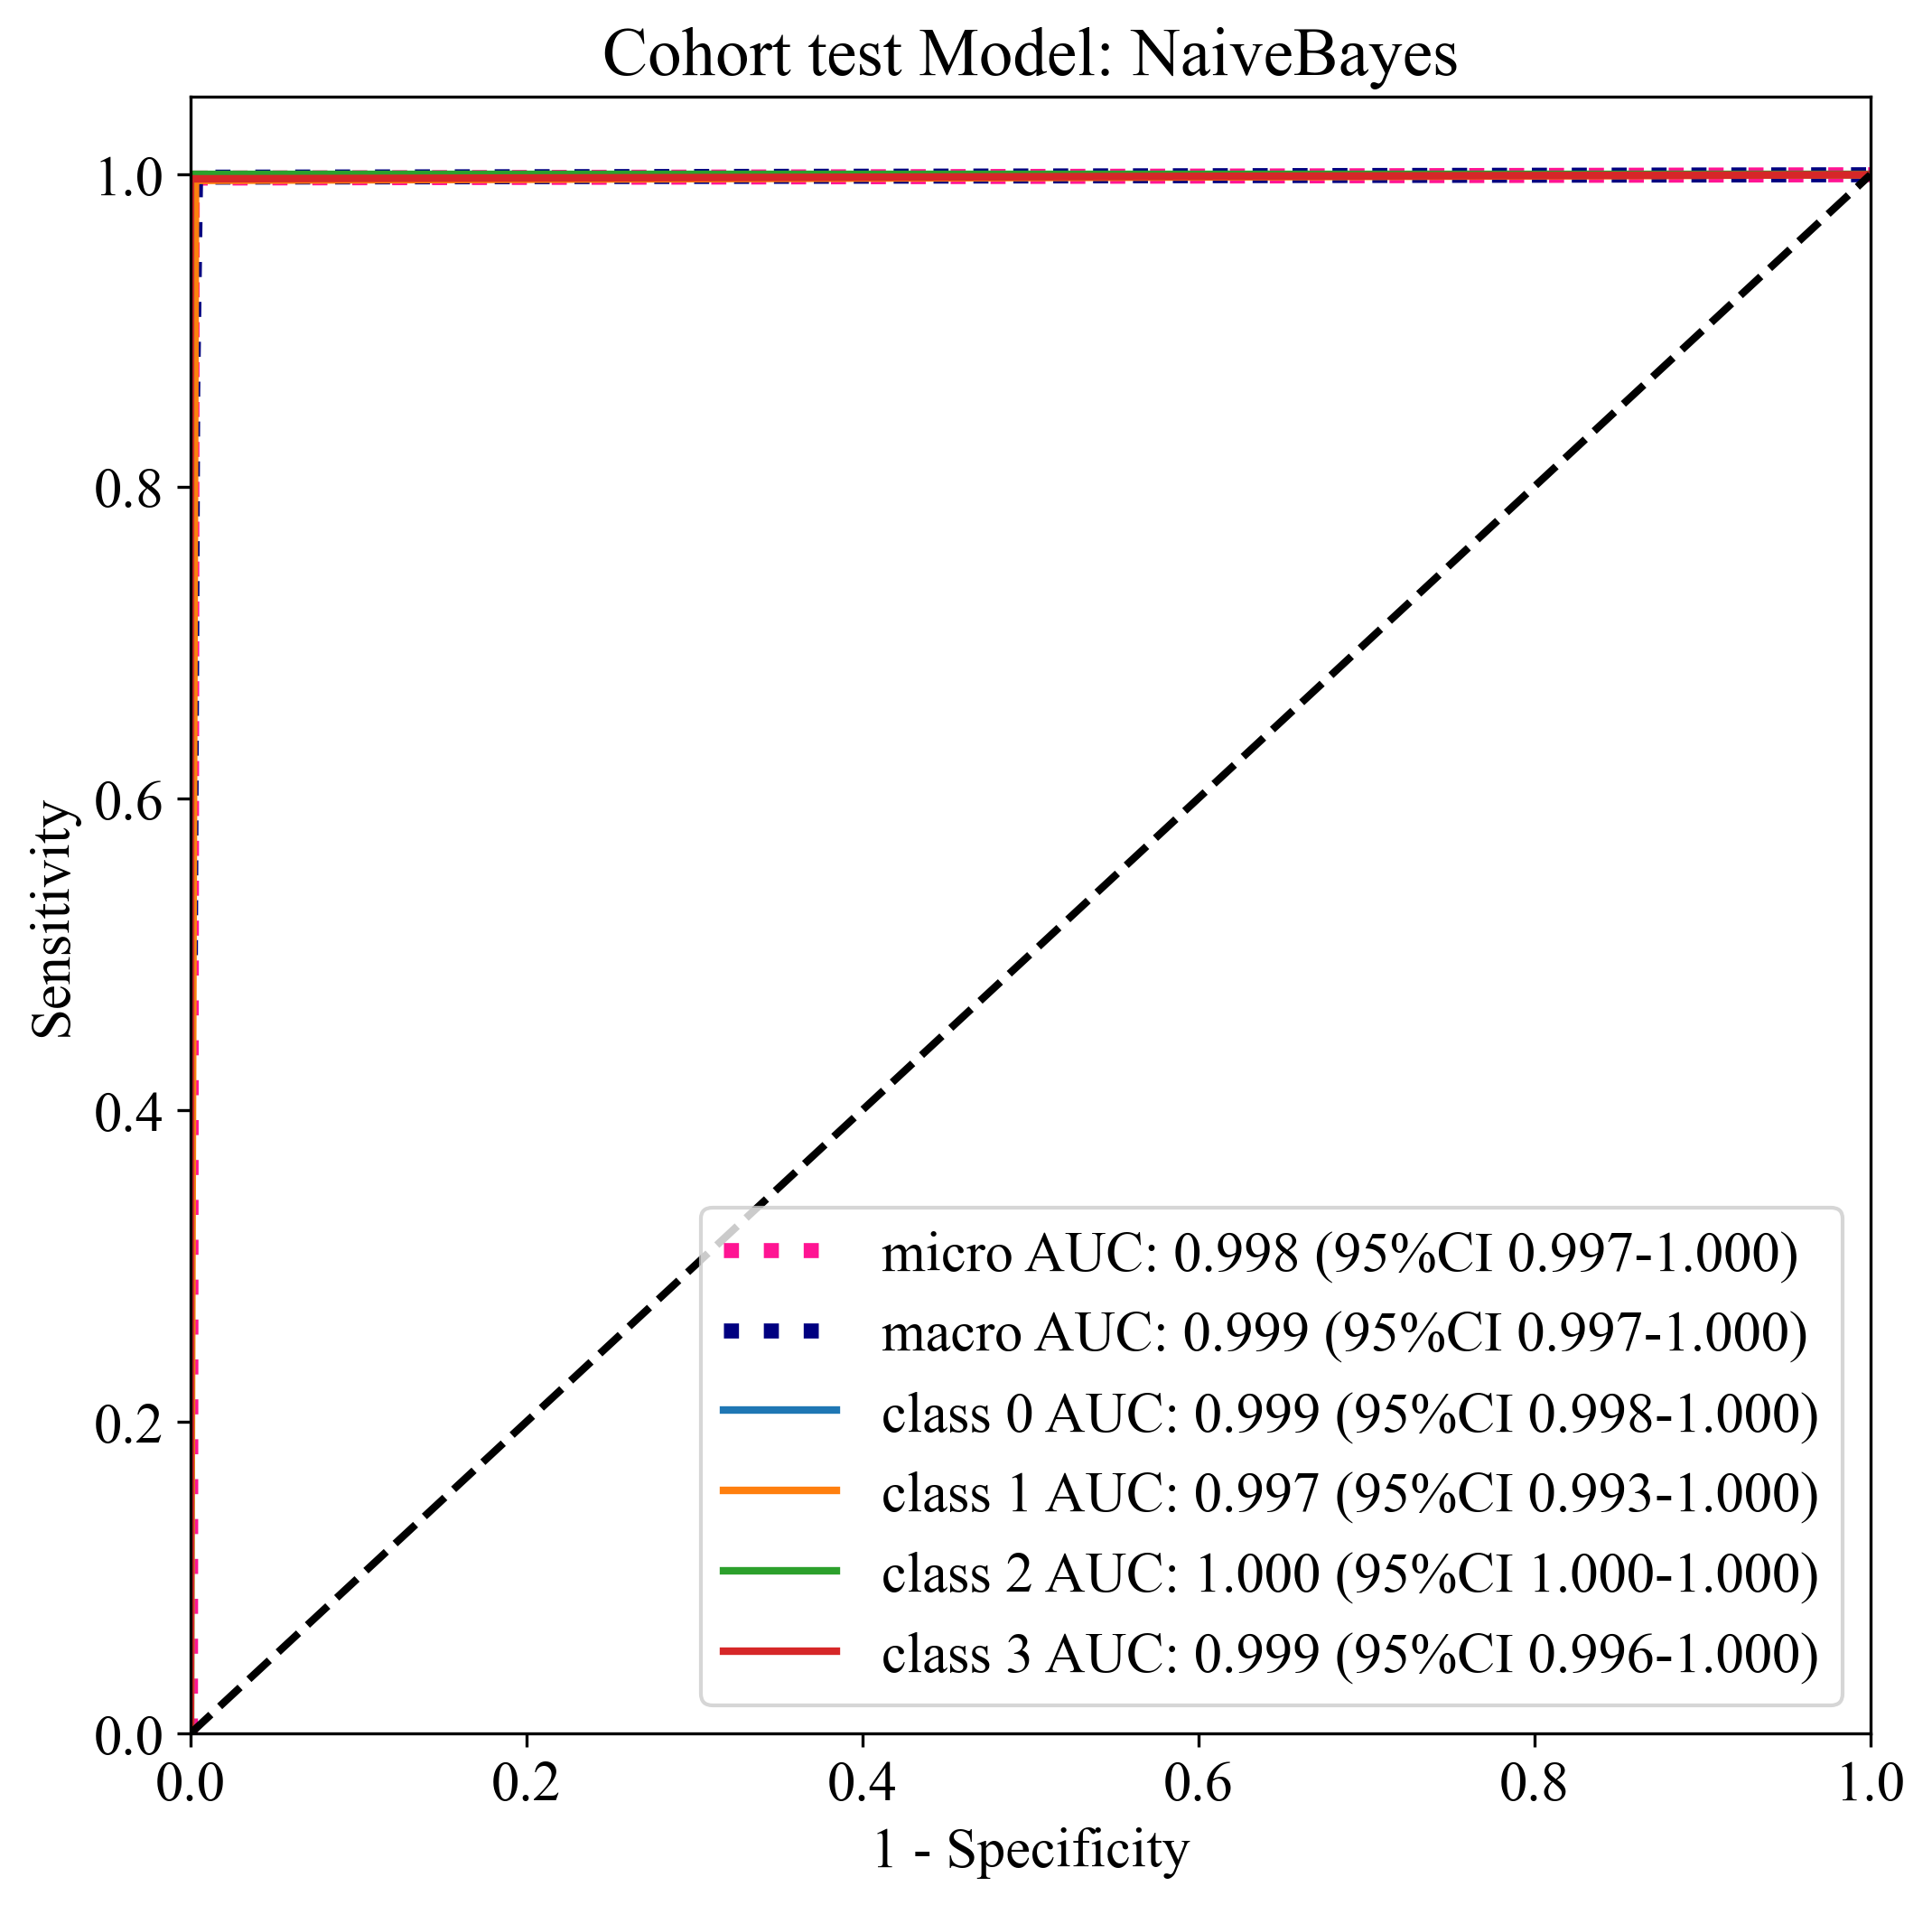

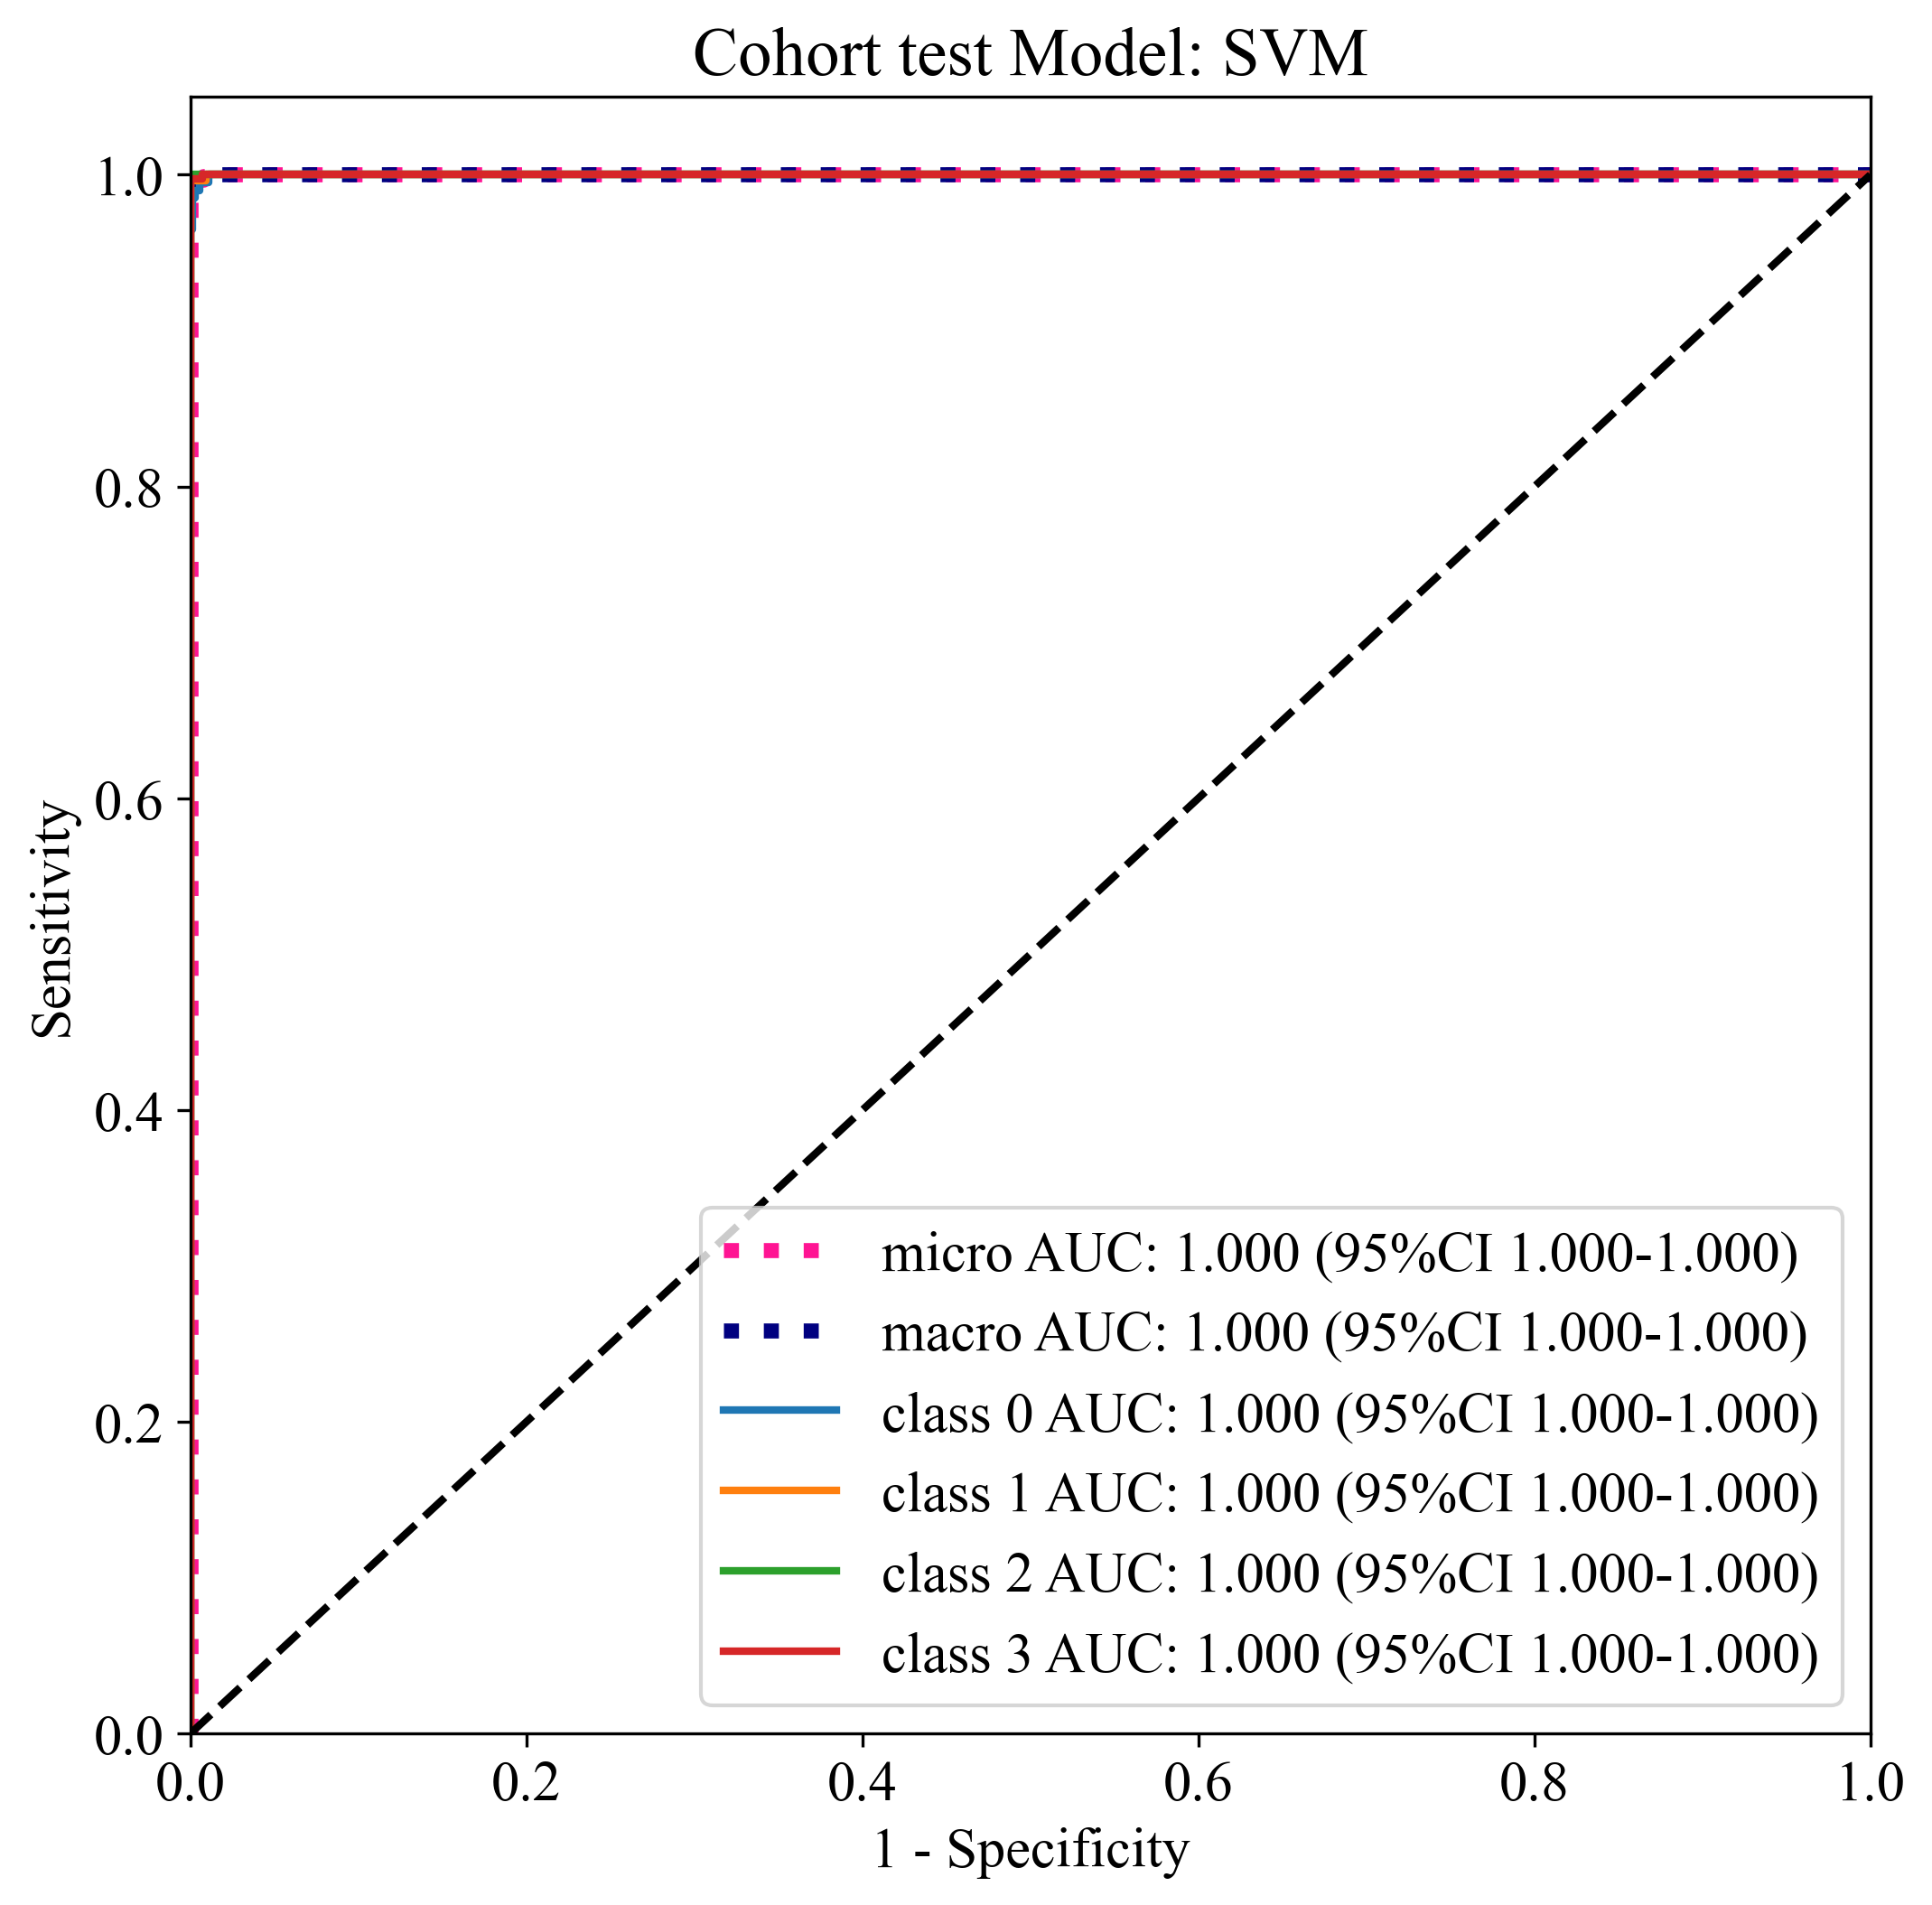

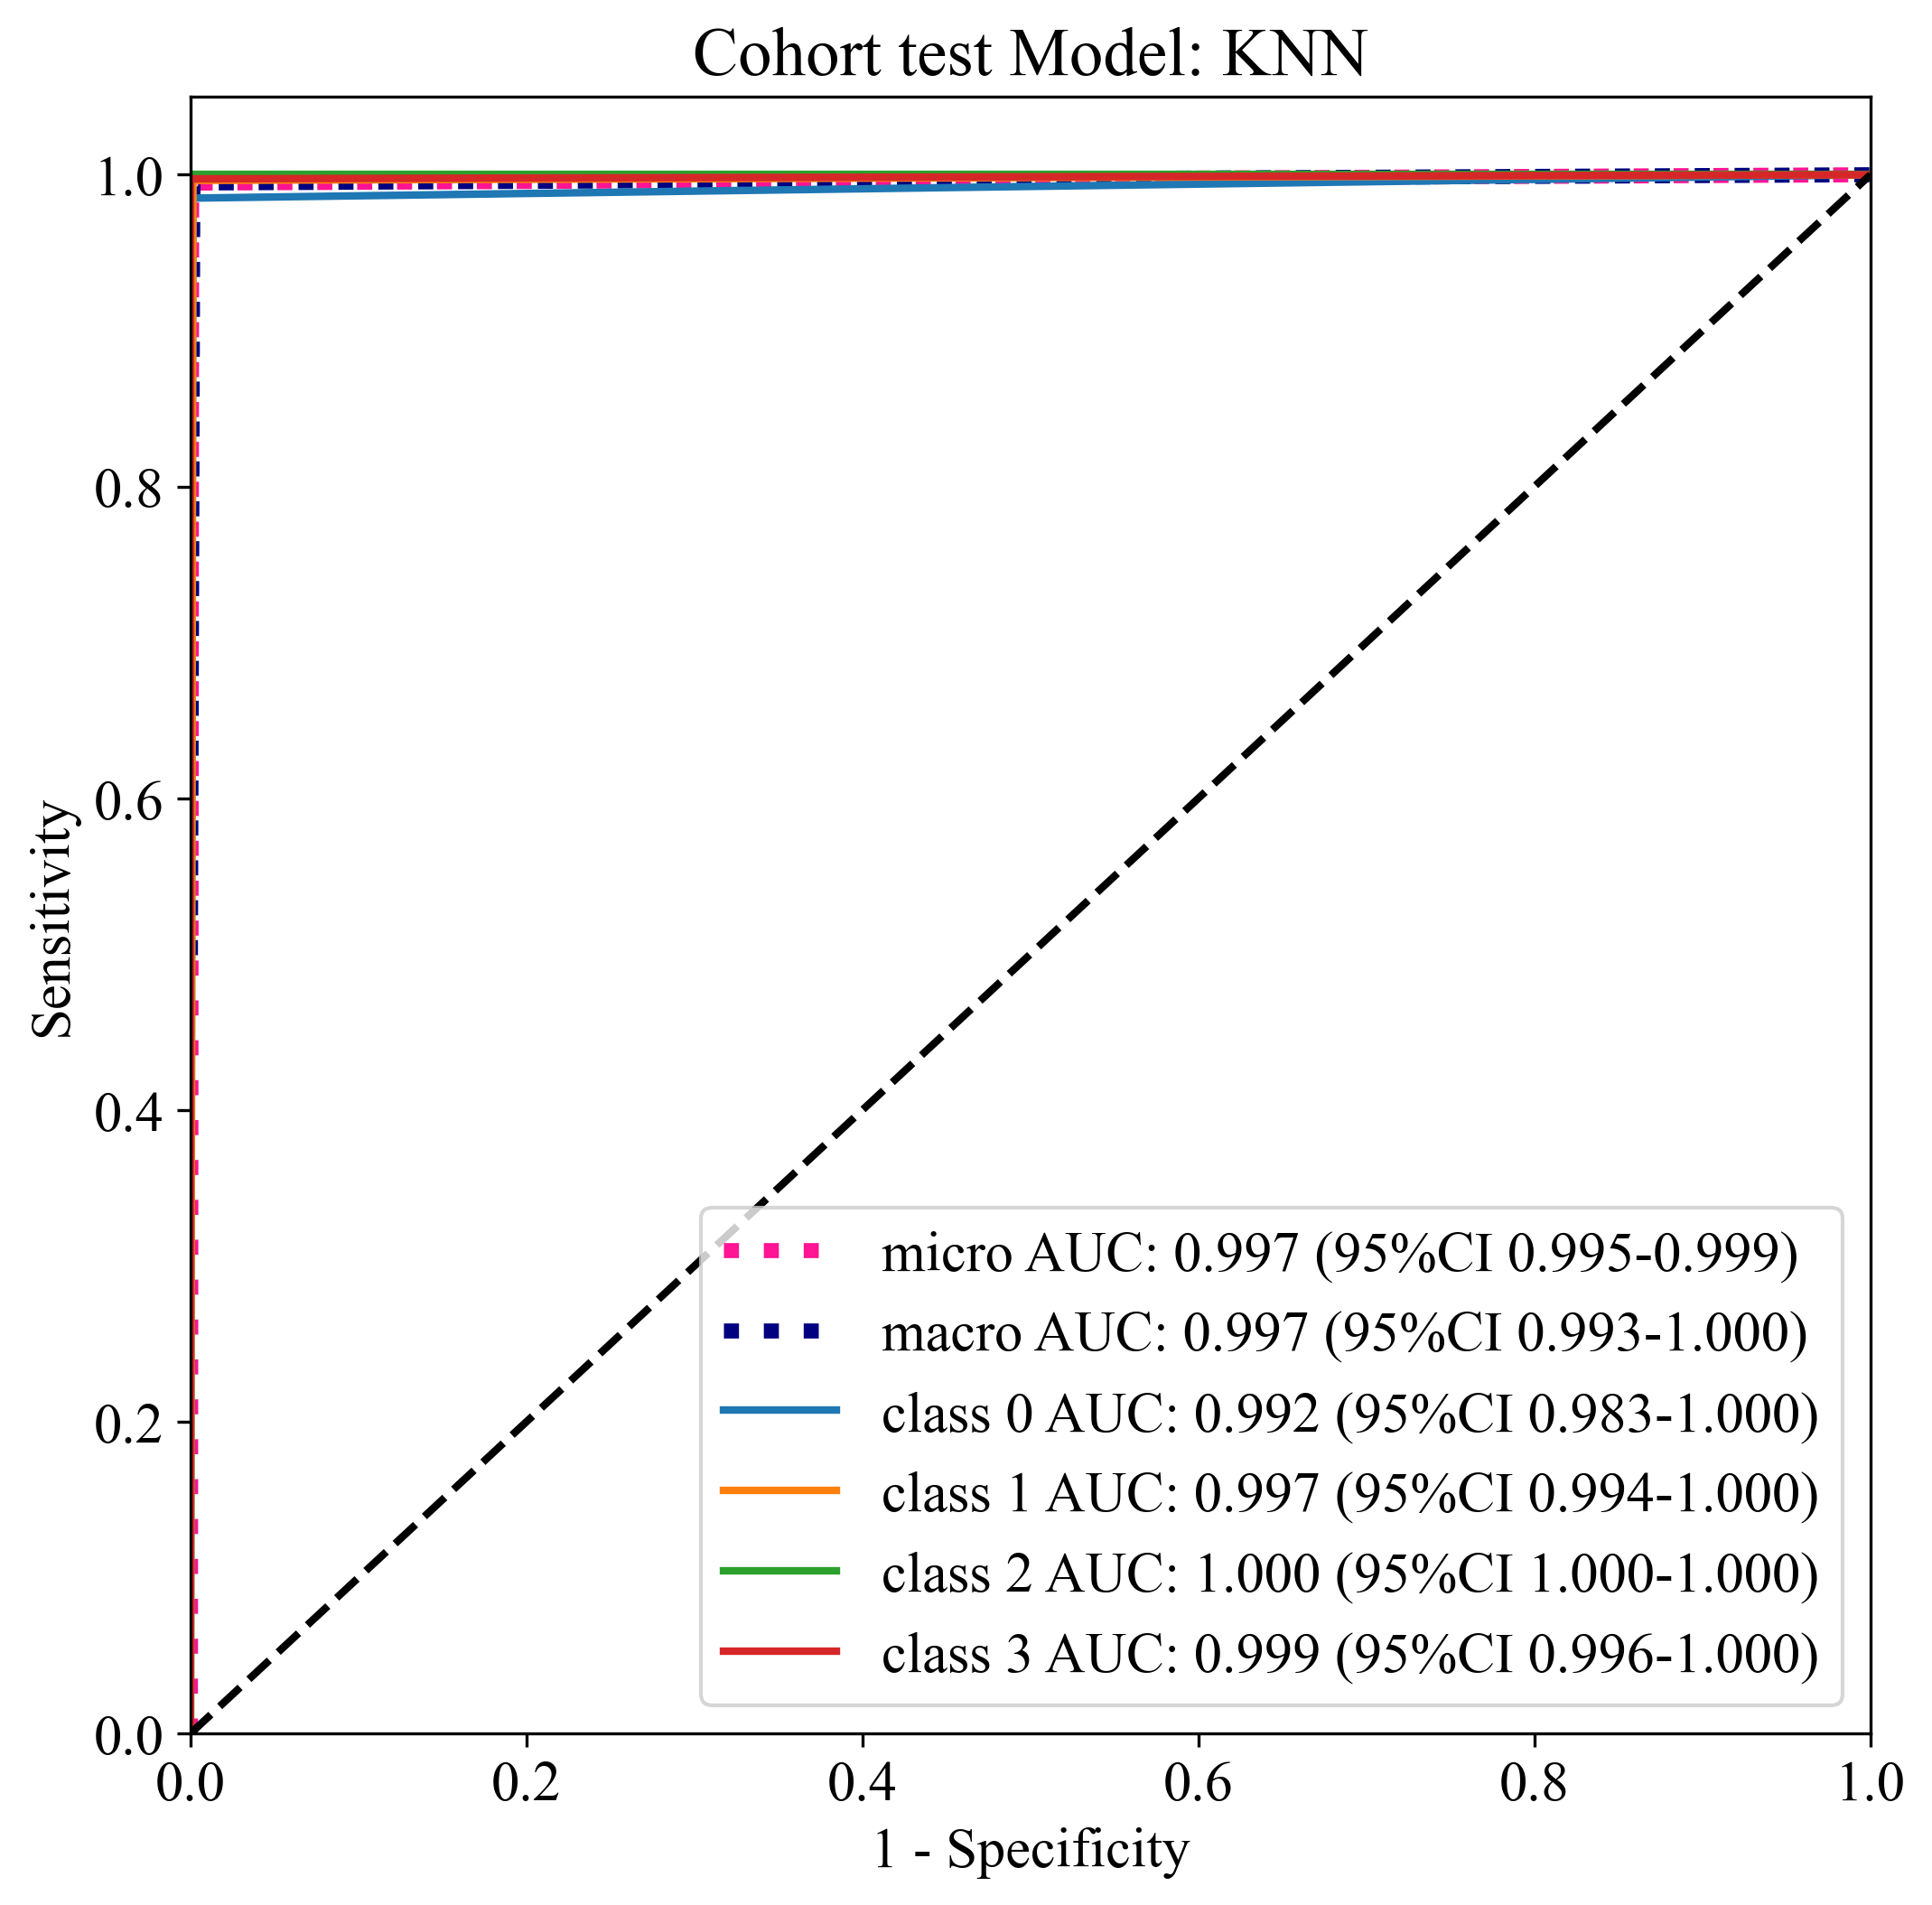

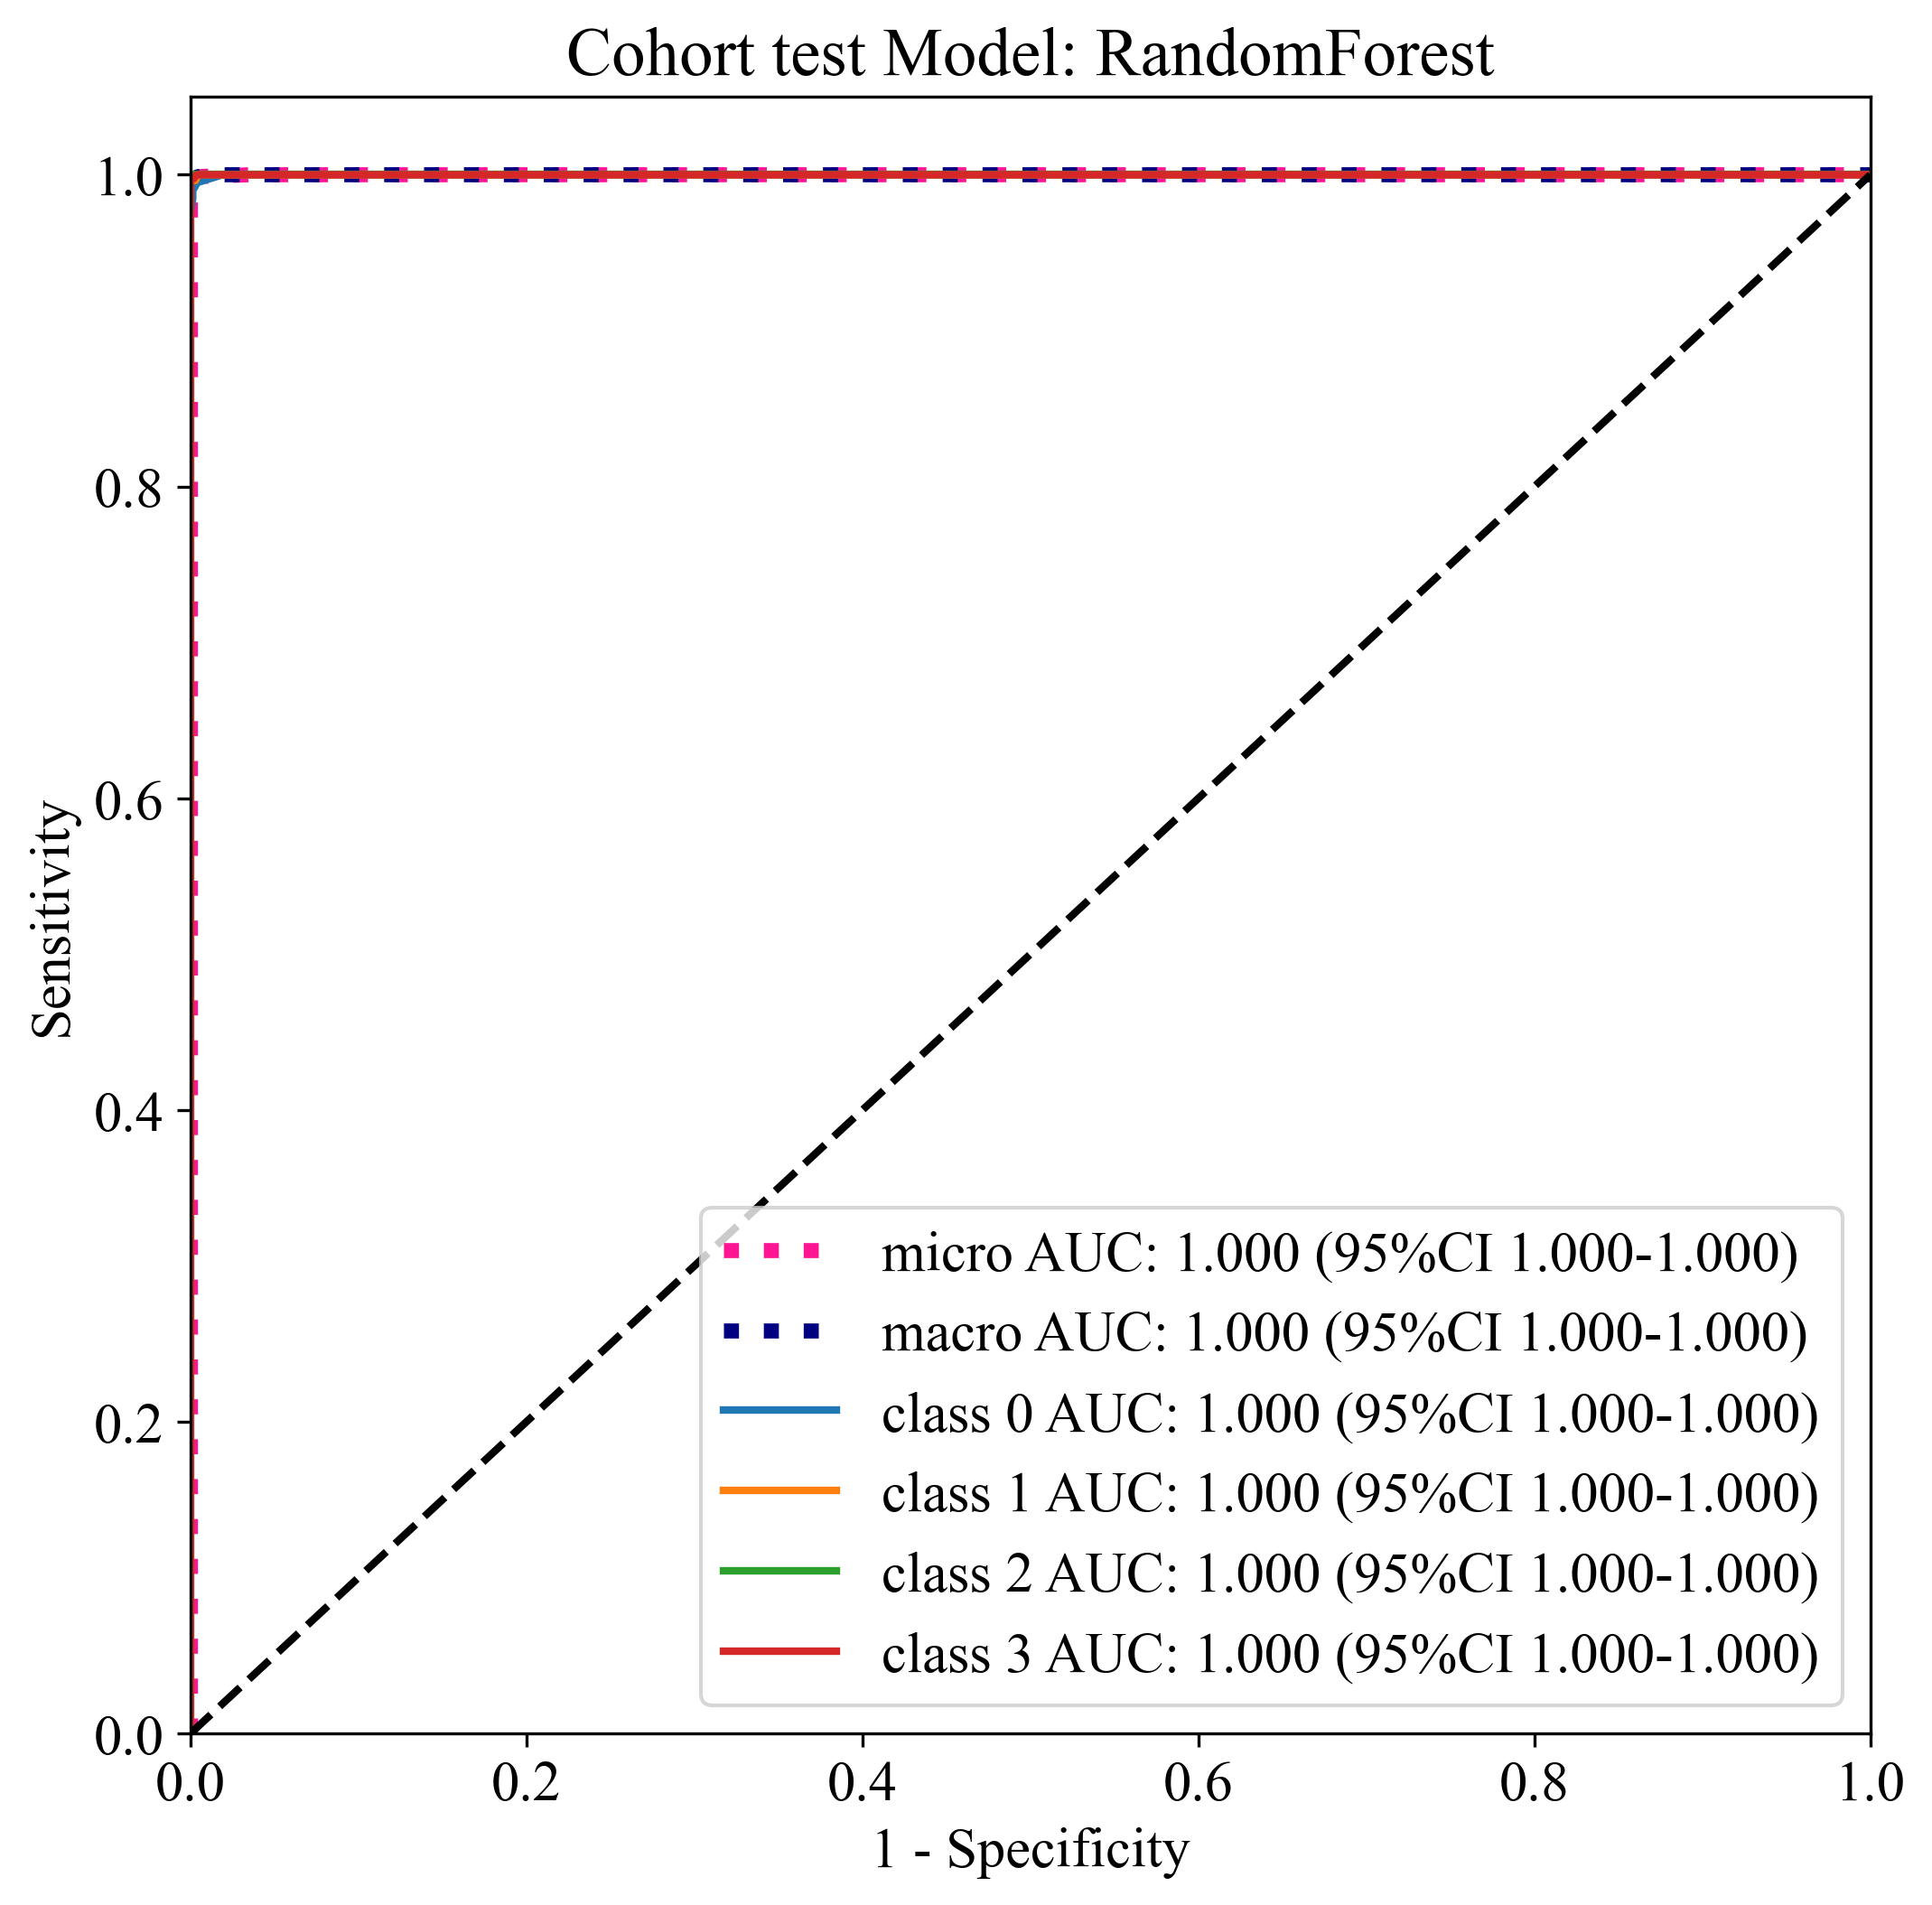

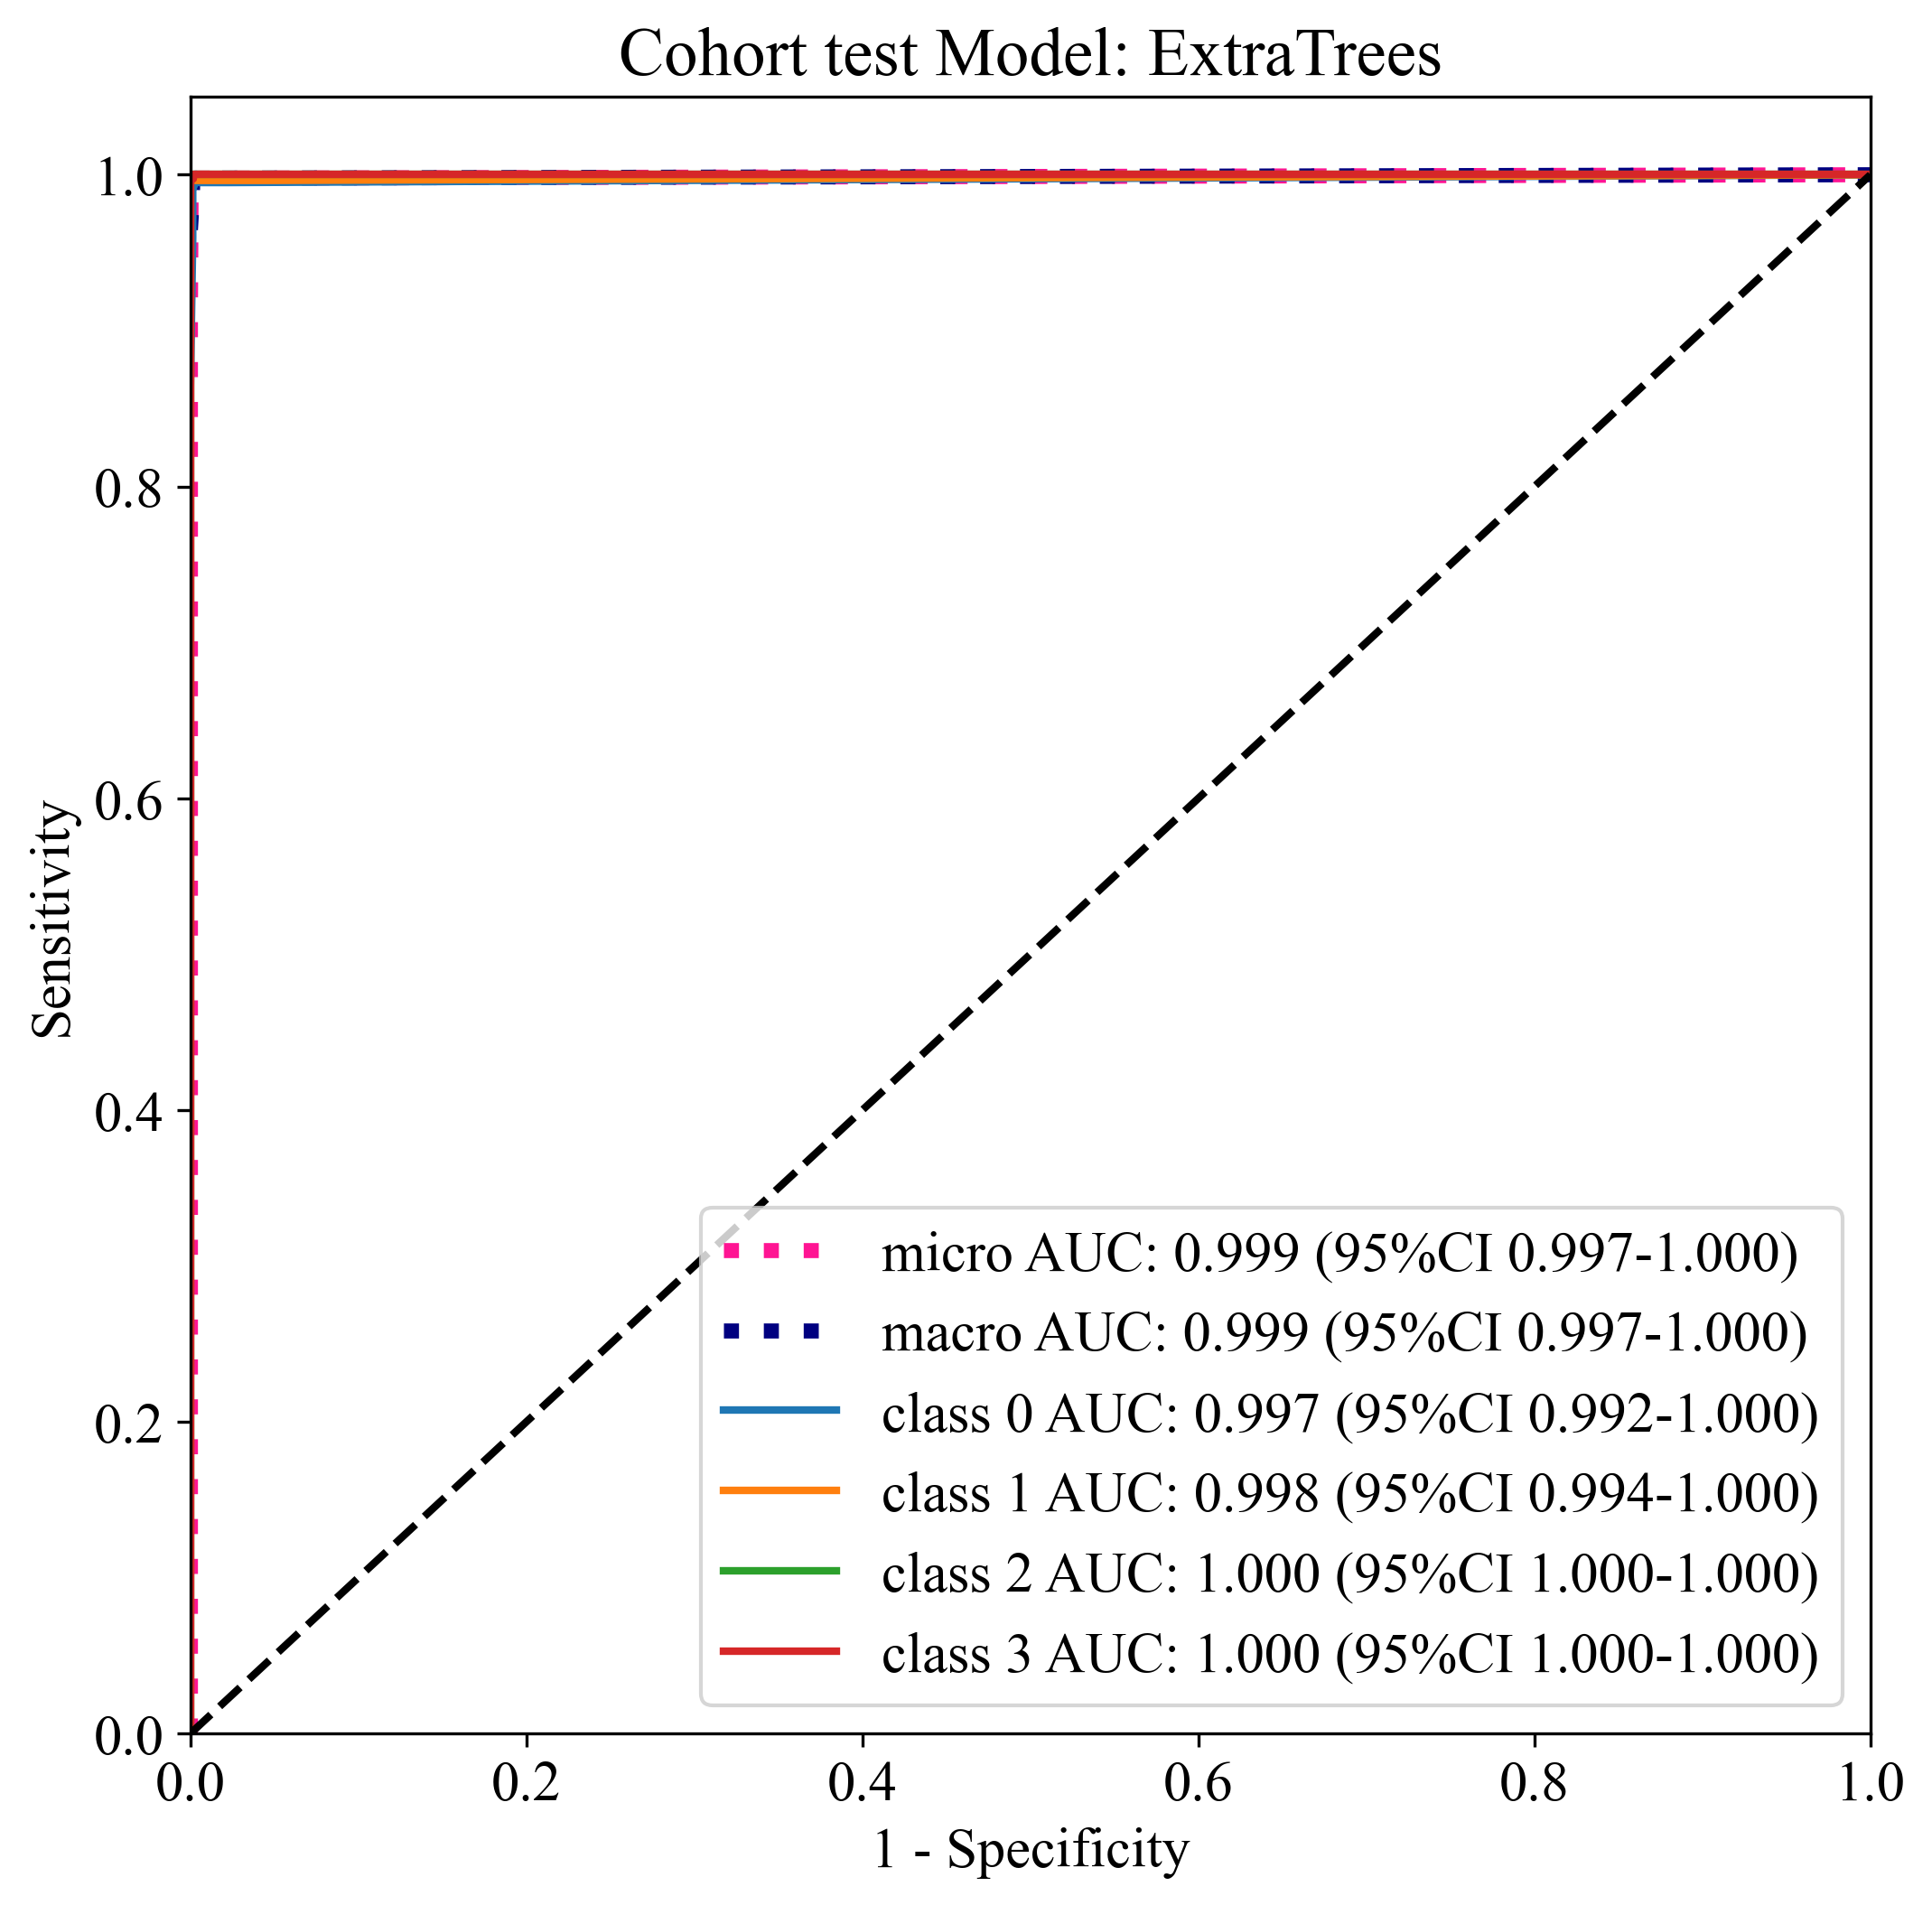

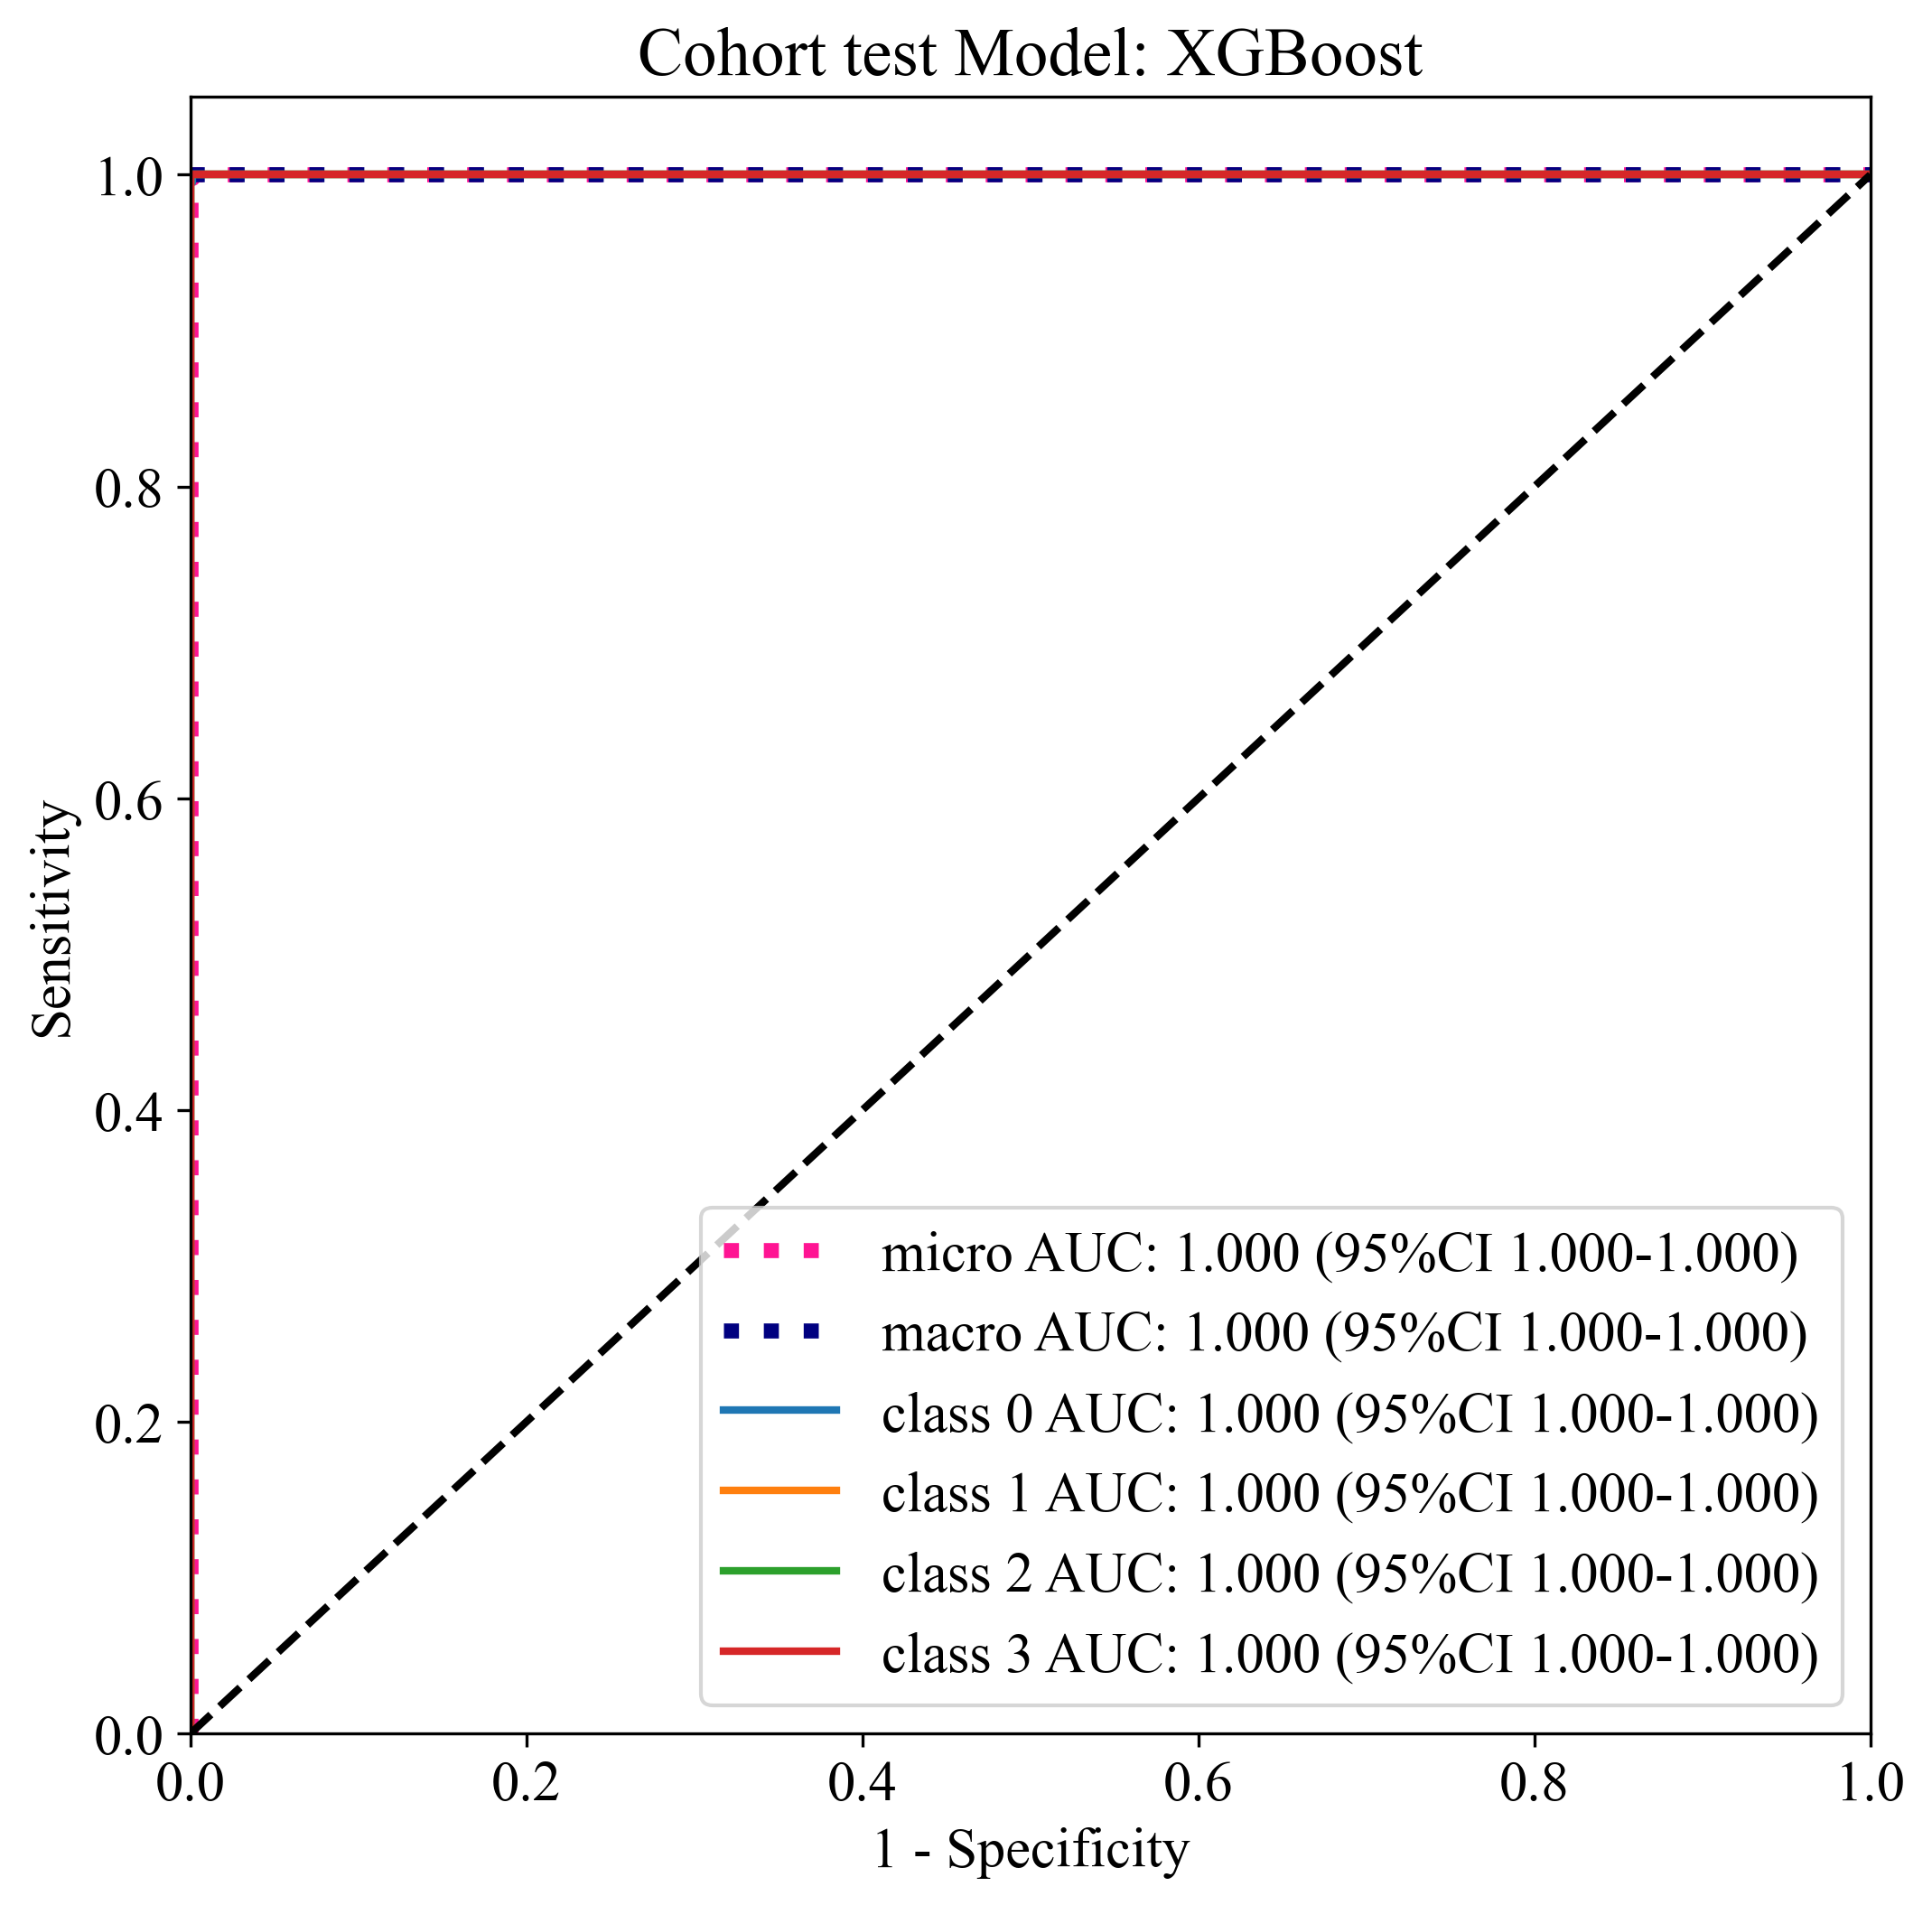

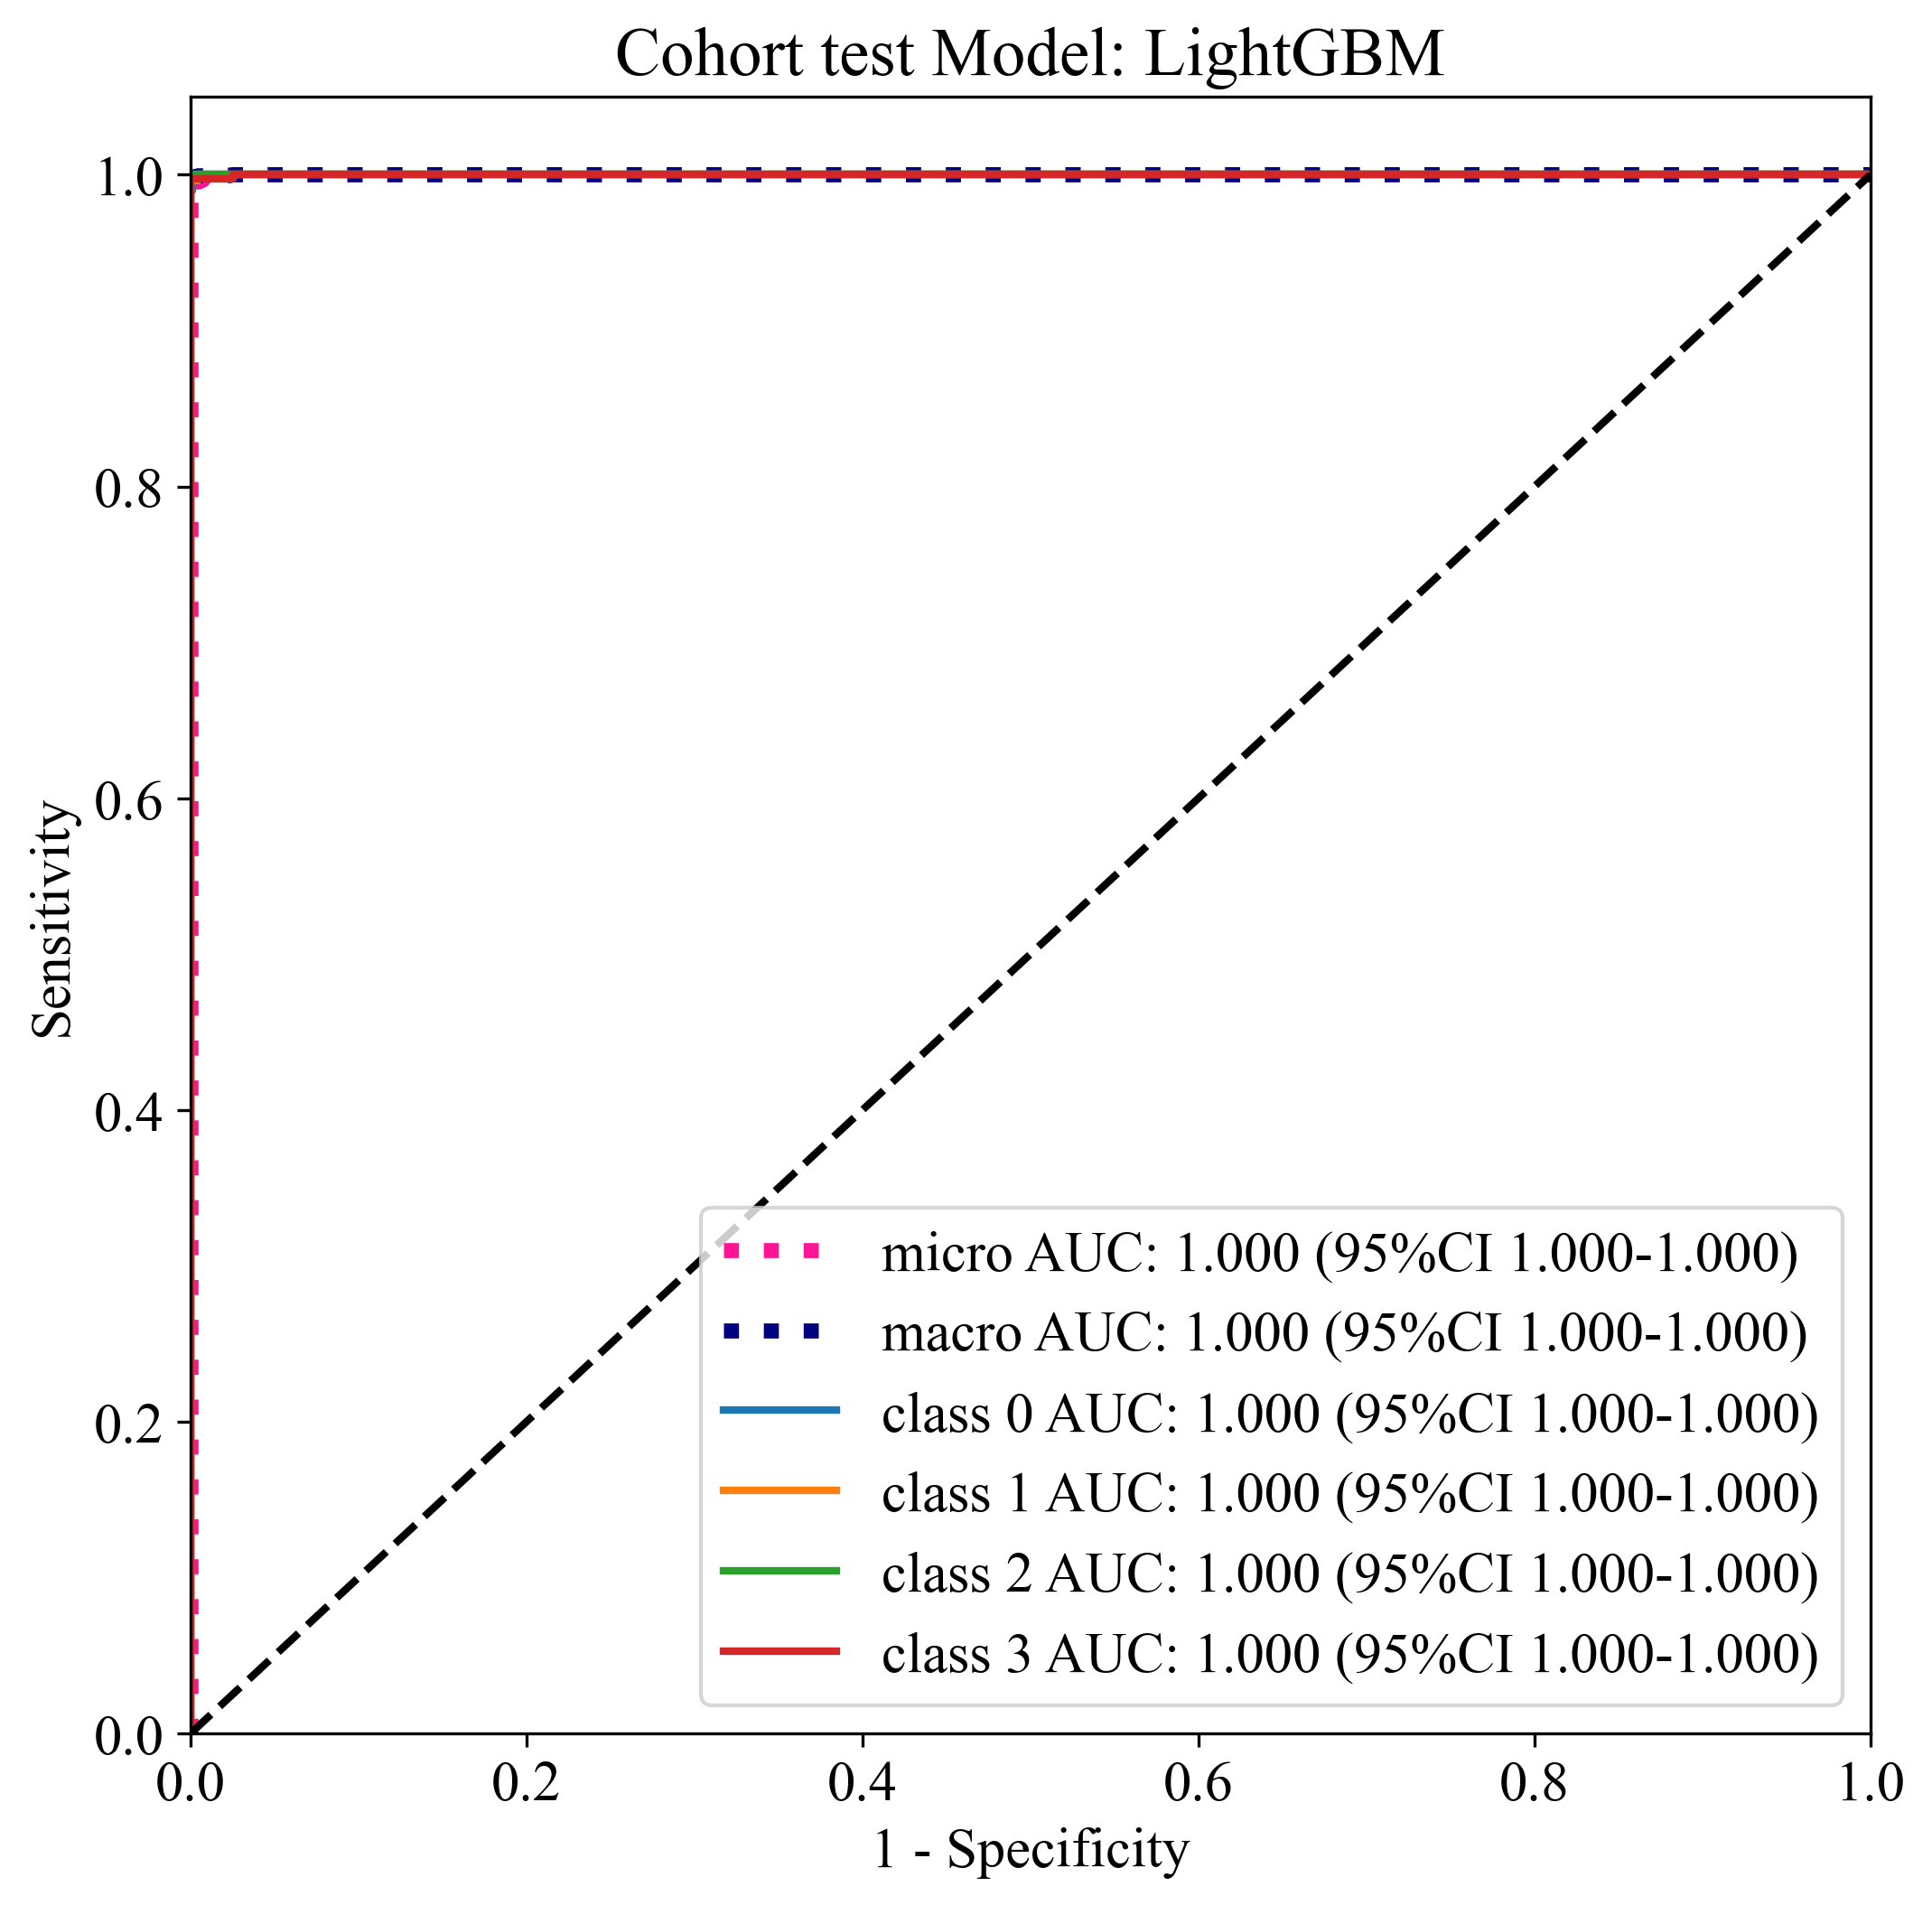

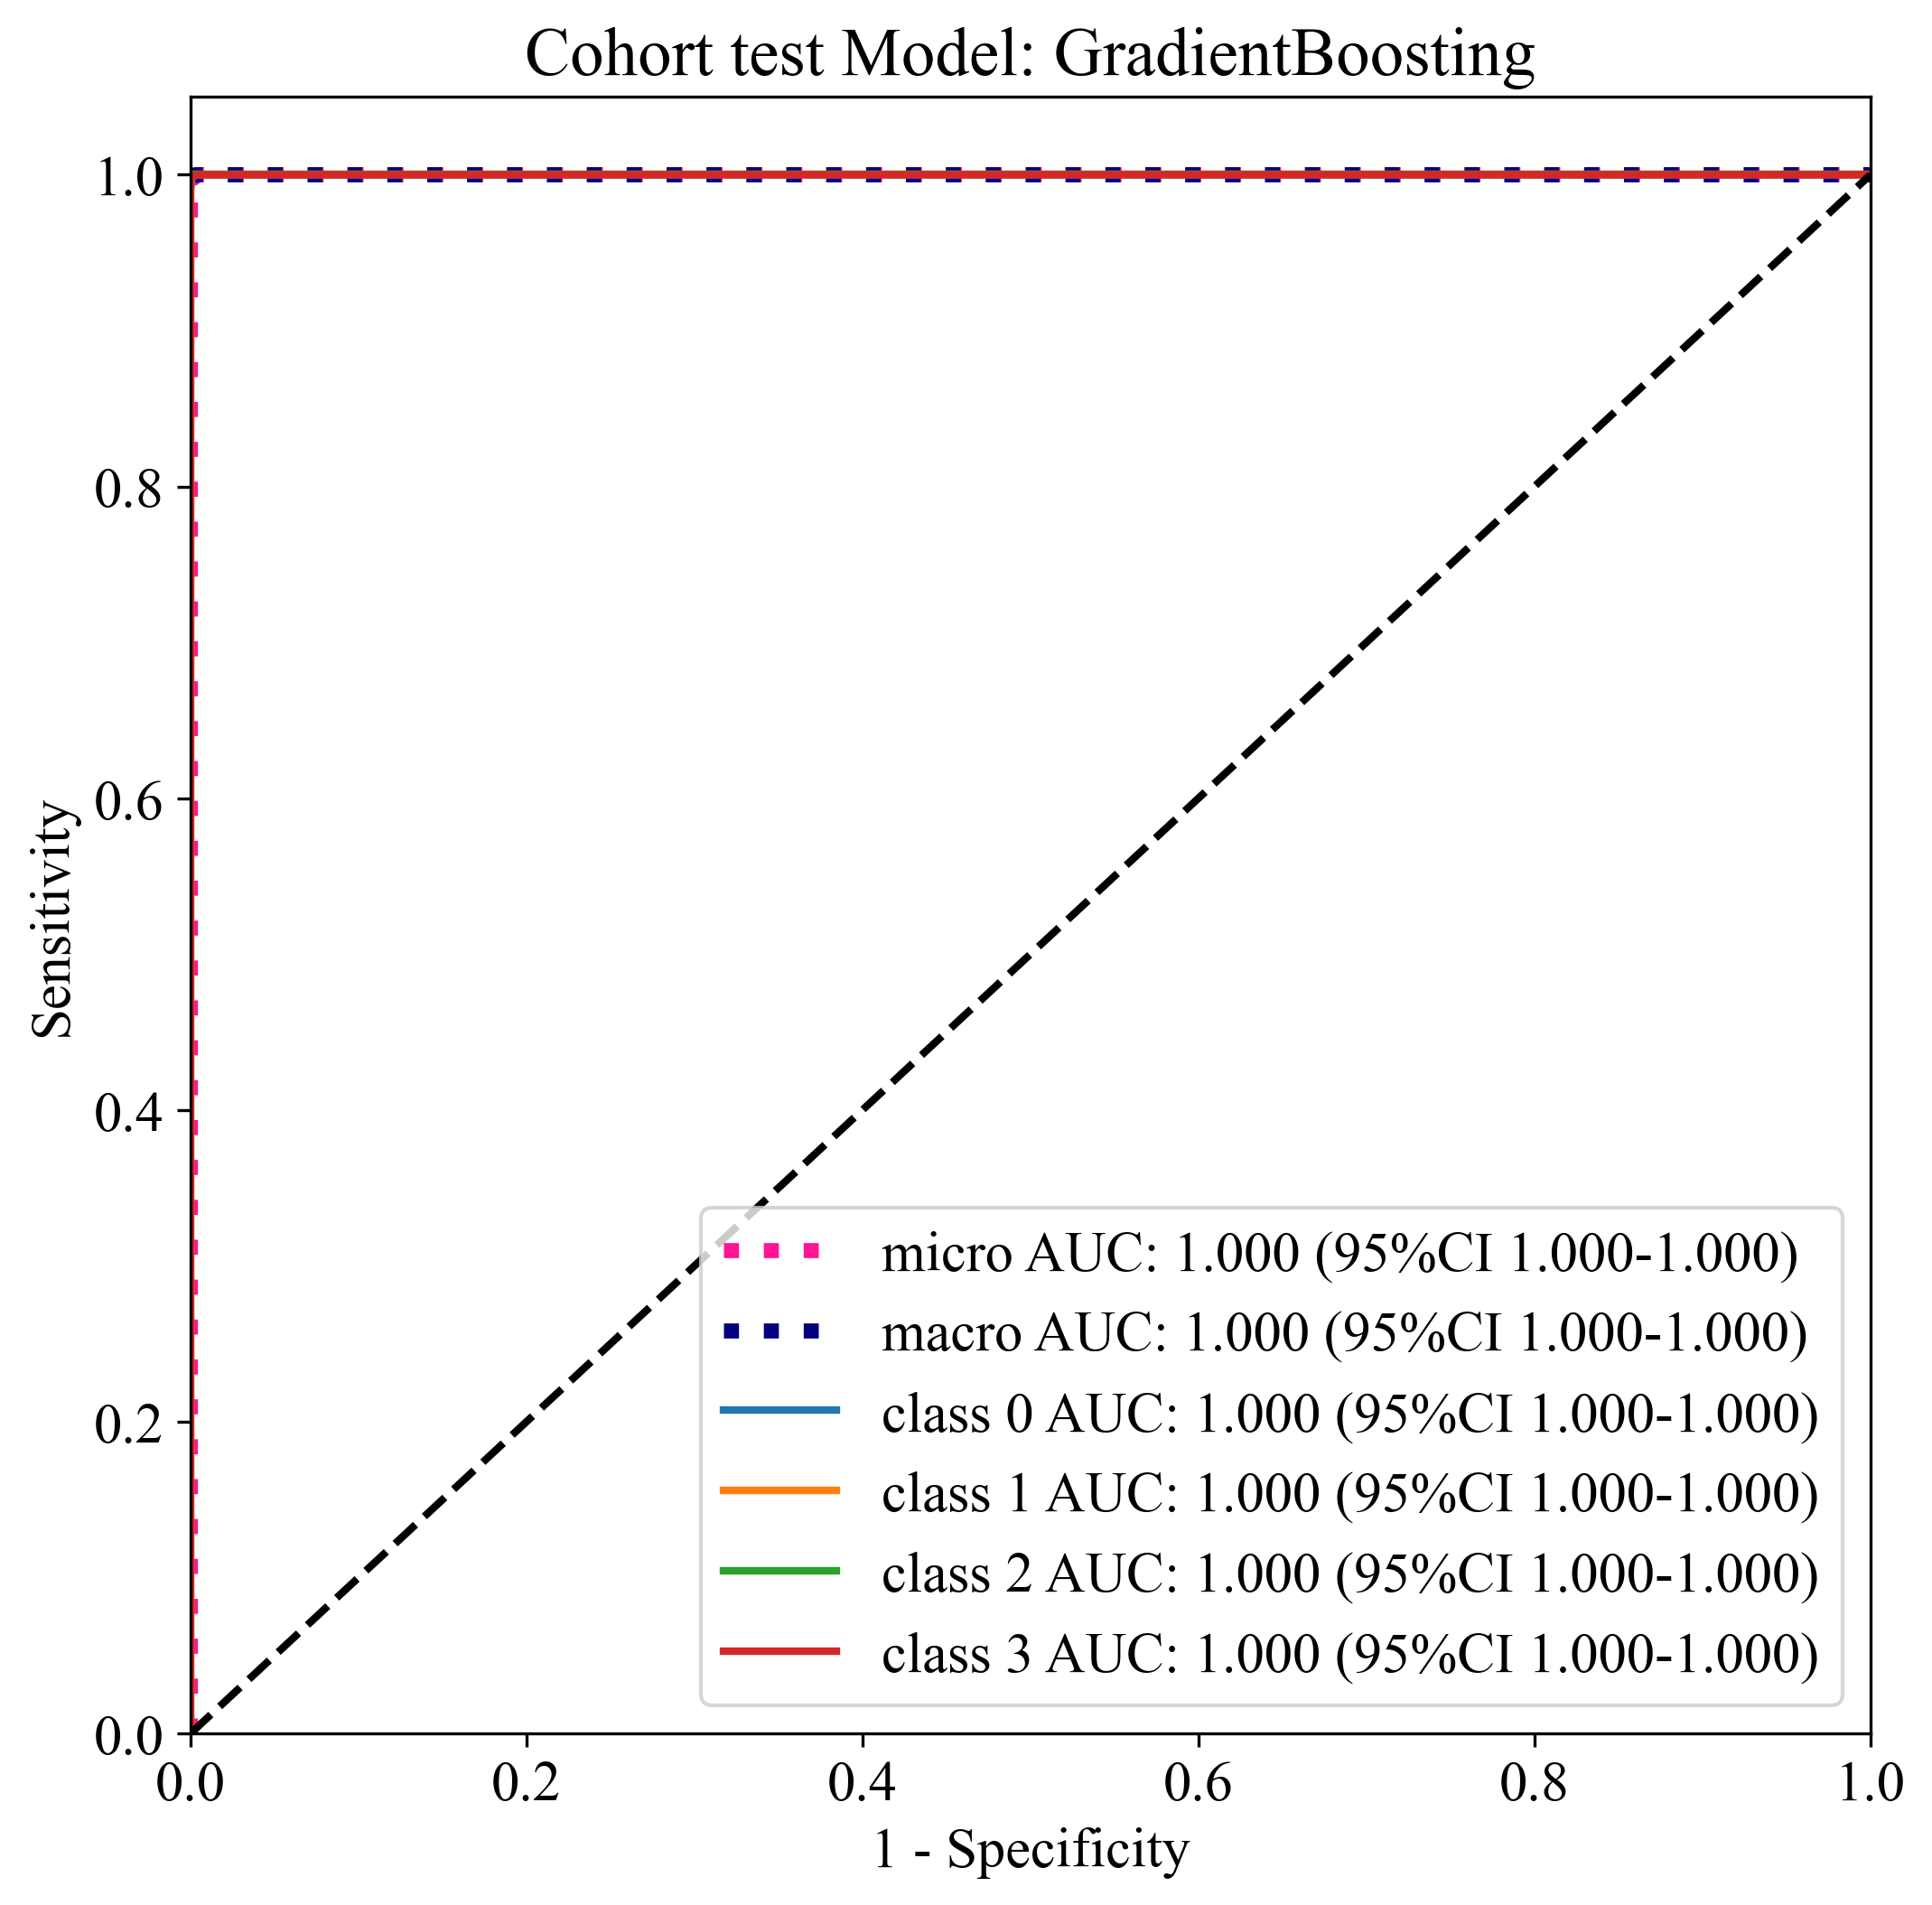

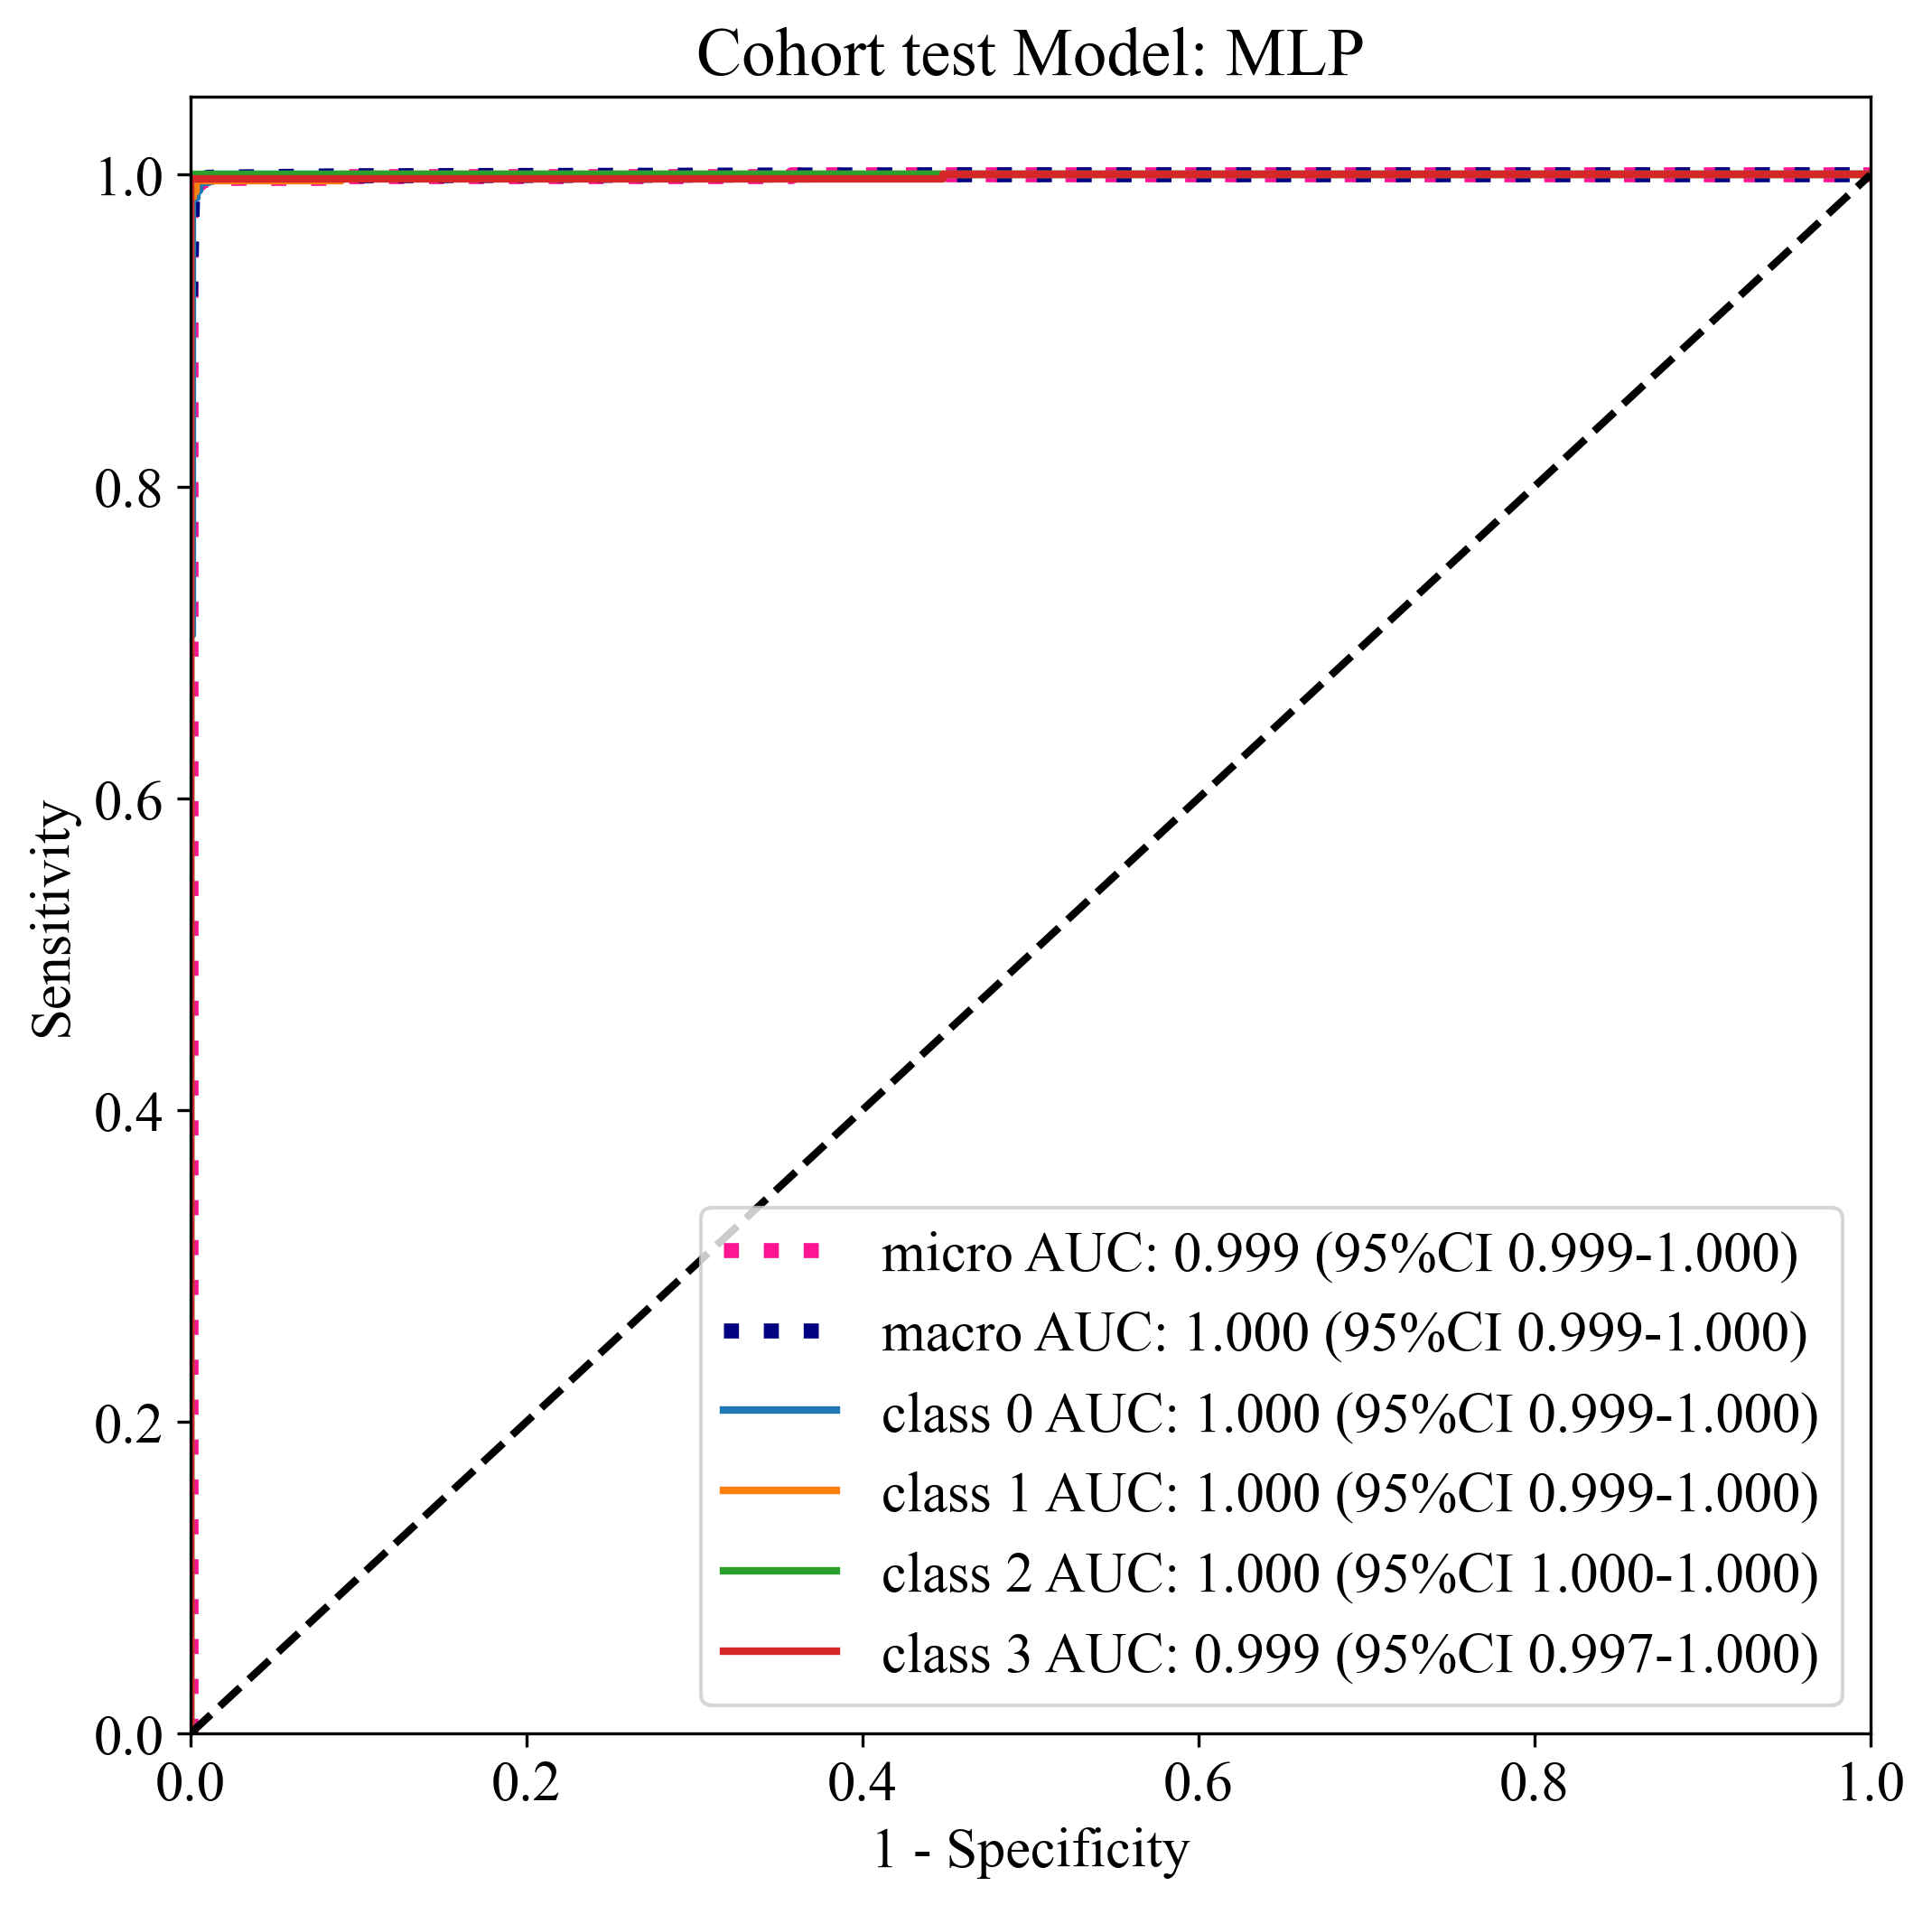

In [27]:
sel_model = model_names
# sel_model = ['SVM', 'KNN']
for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        # Plot all ROC curves
        plt.figure(figsize=(8, 8))
        for pred_score, label in zip(pred_scores, labels):
            okcomp.comp1.draw_roc_per_class(np.array(y_train_sel[label]), pred_score[sel_model_idx][0], n_classes=n_classes,
                                            include_spec_class=True, title=f"Cohort train Model: {sm}")
            plt.savefig(f'img/model_{sm}_train_roc.svg', bbox_inches = 'tight')
            
for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        # Plot all ROC curves
        plt.figure(figsize=(8, 8))
        for pred_score, label in zip(pred_scores, labels):
            okcomp.comp1.draw_roc_per_class(np.array(y_test_sel[label]), pred_score[sel_model_idx][1], n_classes=n_classes,
                                            include_spec_class=True, title=f"Cohort test Model: {sm}")
            plt.savefig(f'img/model_{sm}_test_roc.svg', bbox_inches = 'tight')

### 绘制混淆矩阵

绘制混淆矩阵，[混淆矩阵解释](https://baike.baidu.com/item/%E6%B7%B7%E6%B7%86%E7%9F%A9%E9%98%B5/10087822?fr=aladdin)
`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

如果需要修改标签到名称的映射，修改`class_mapping={1:'1', 0:'0'}`

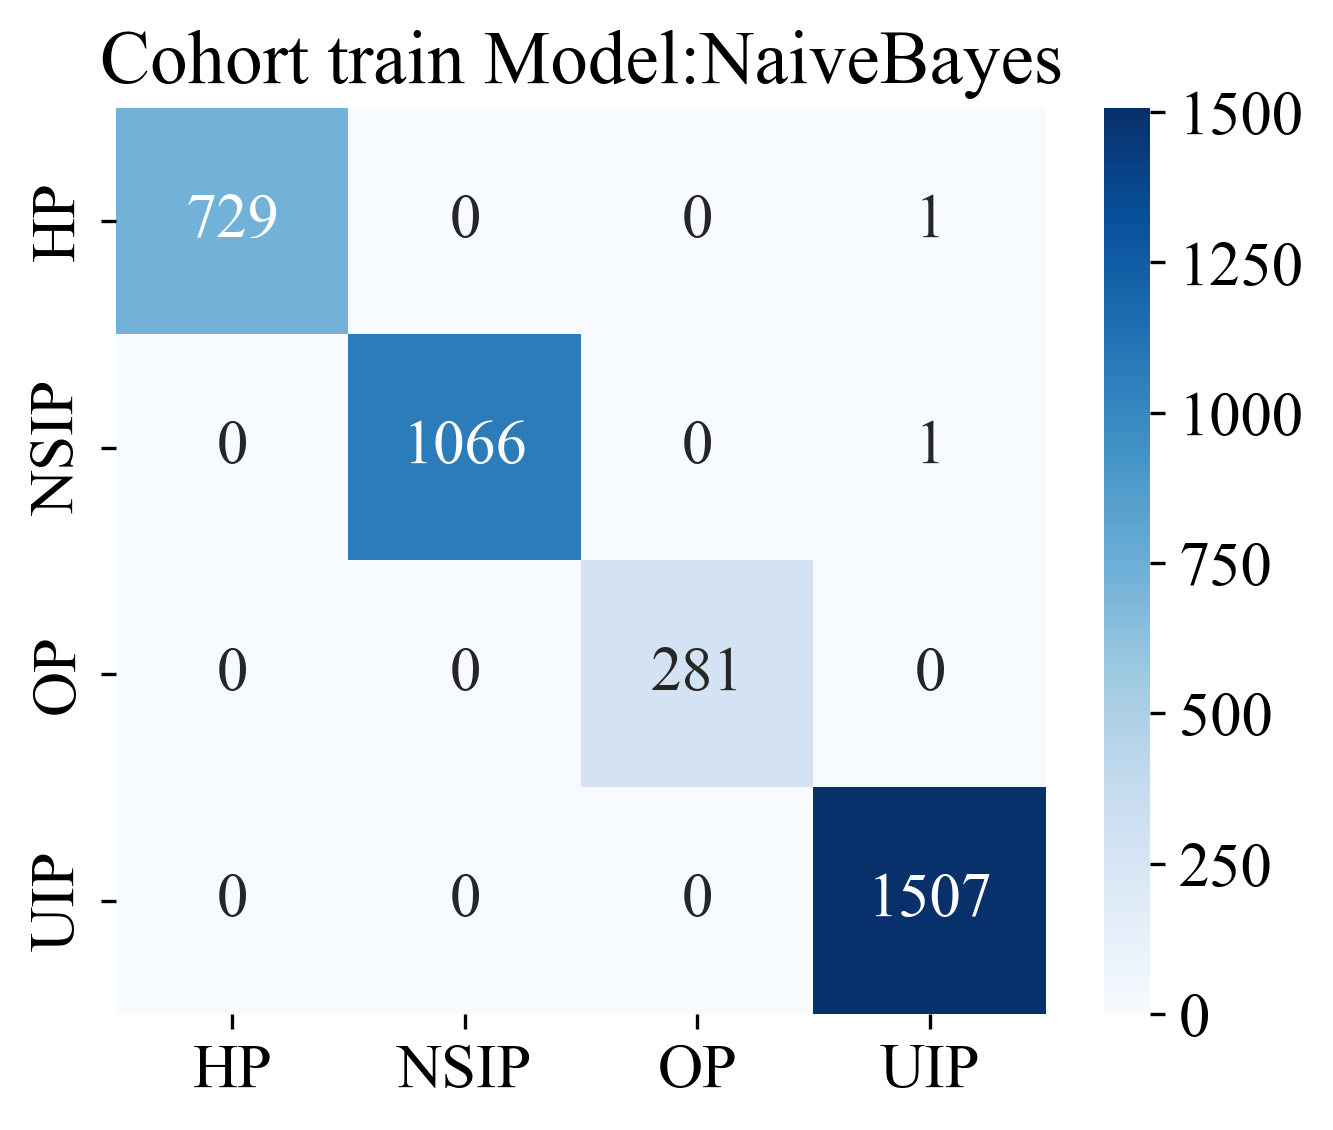

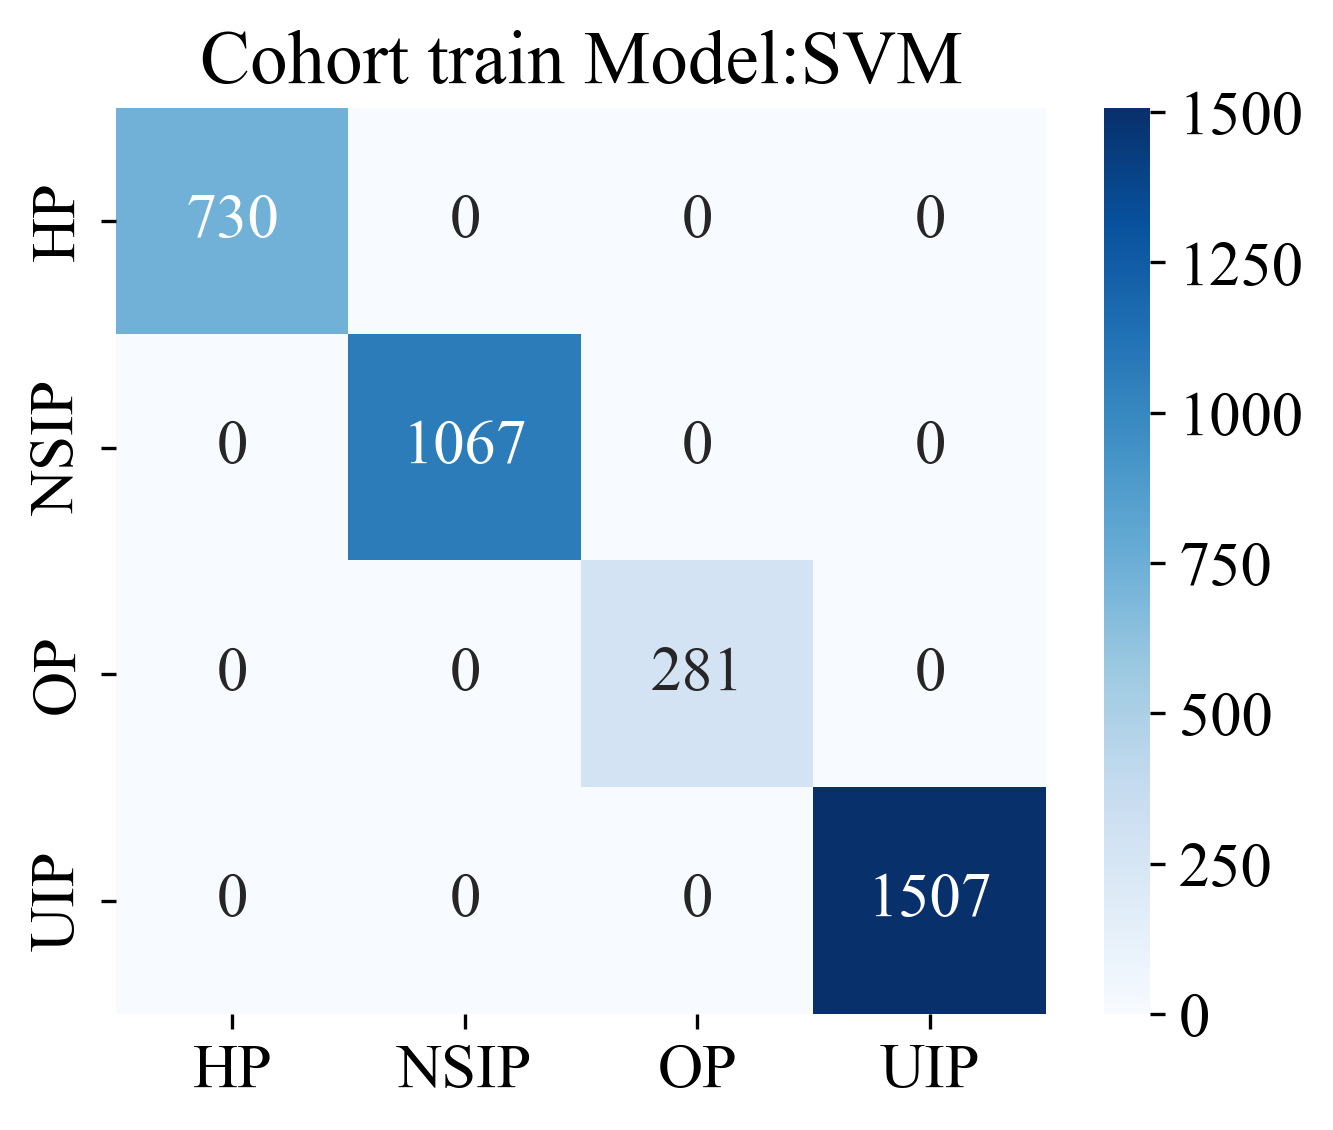

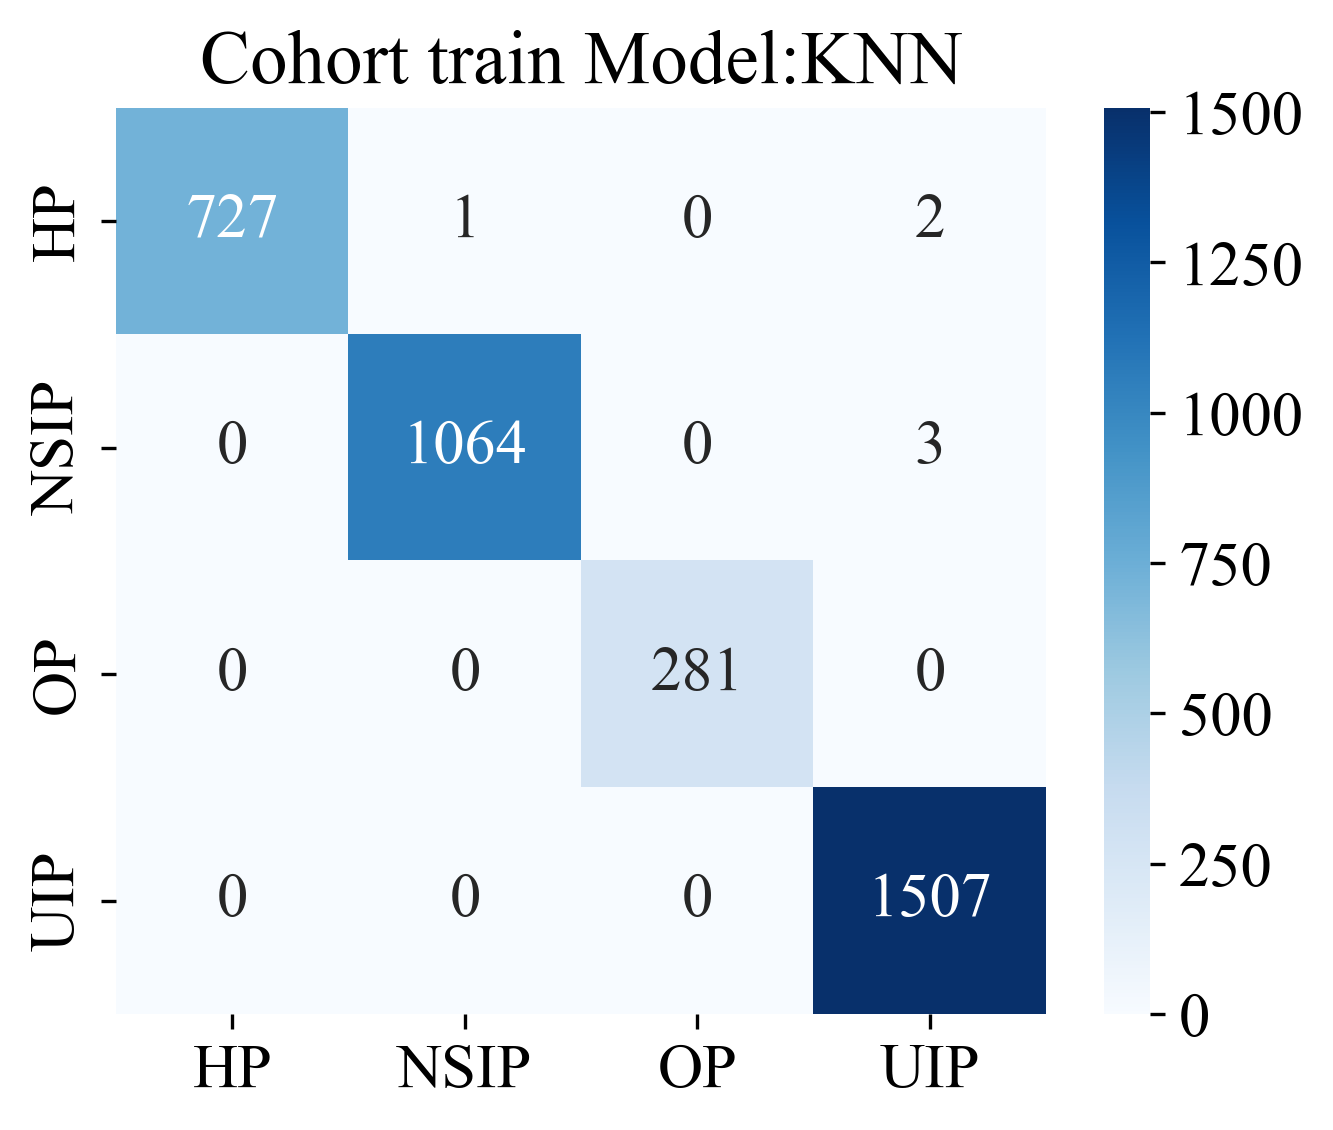

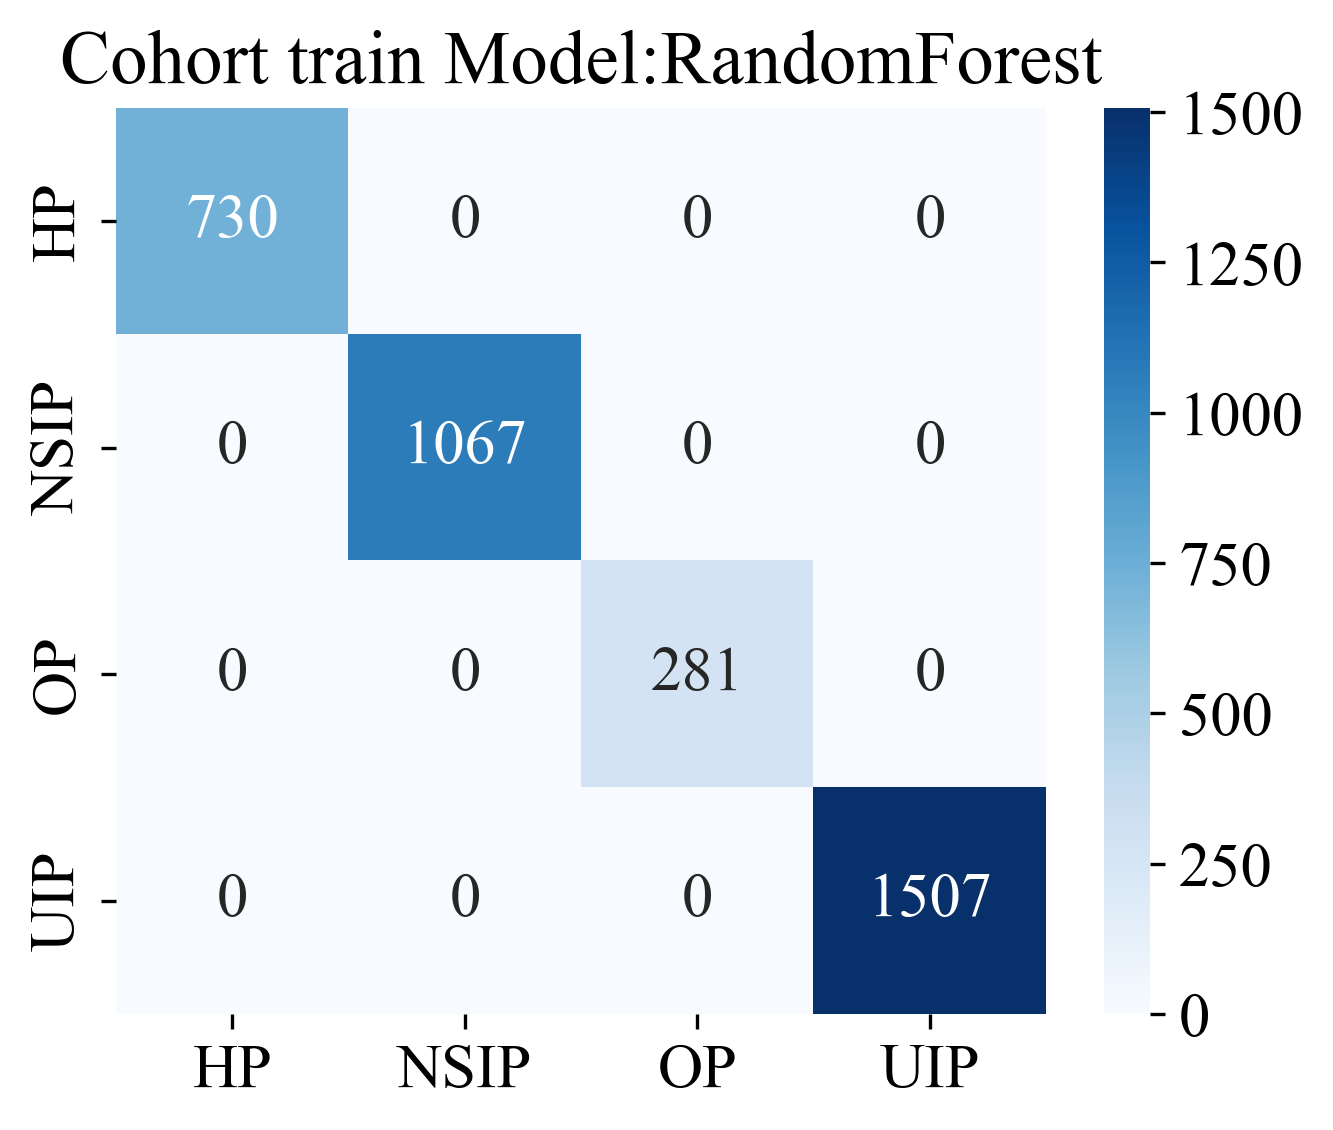

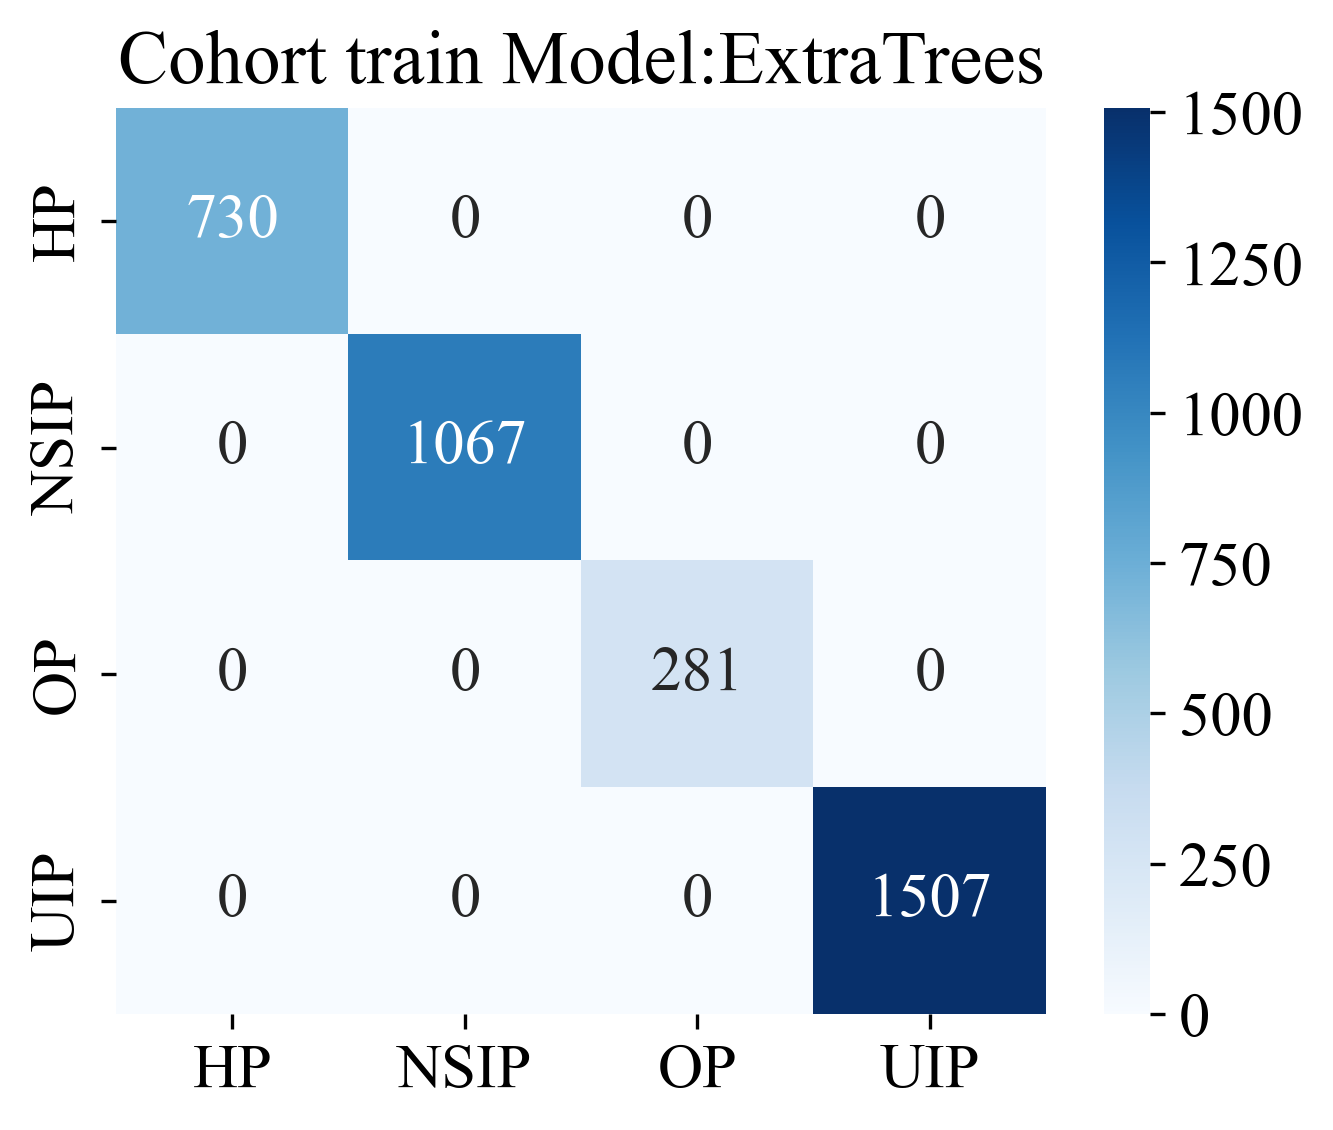

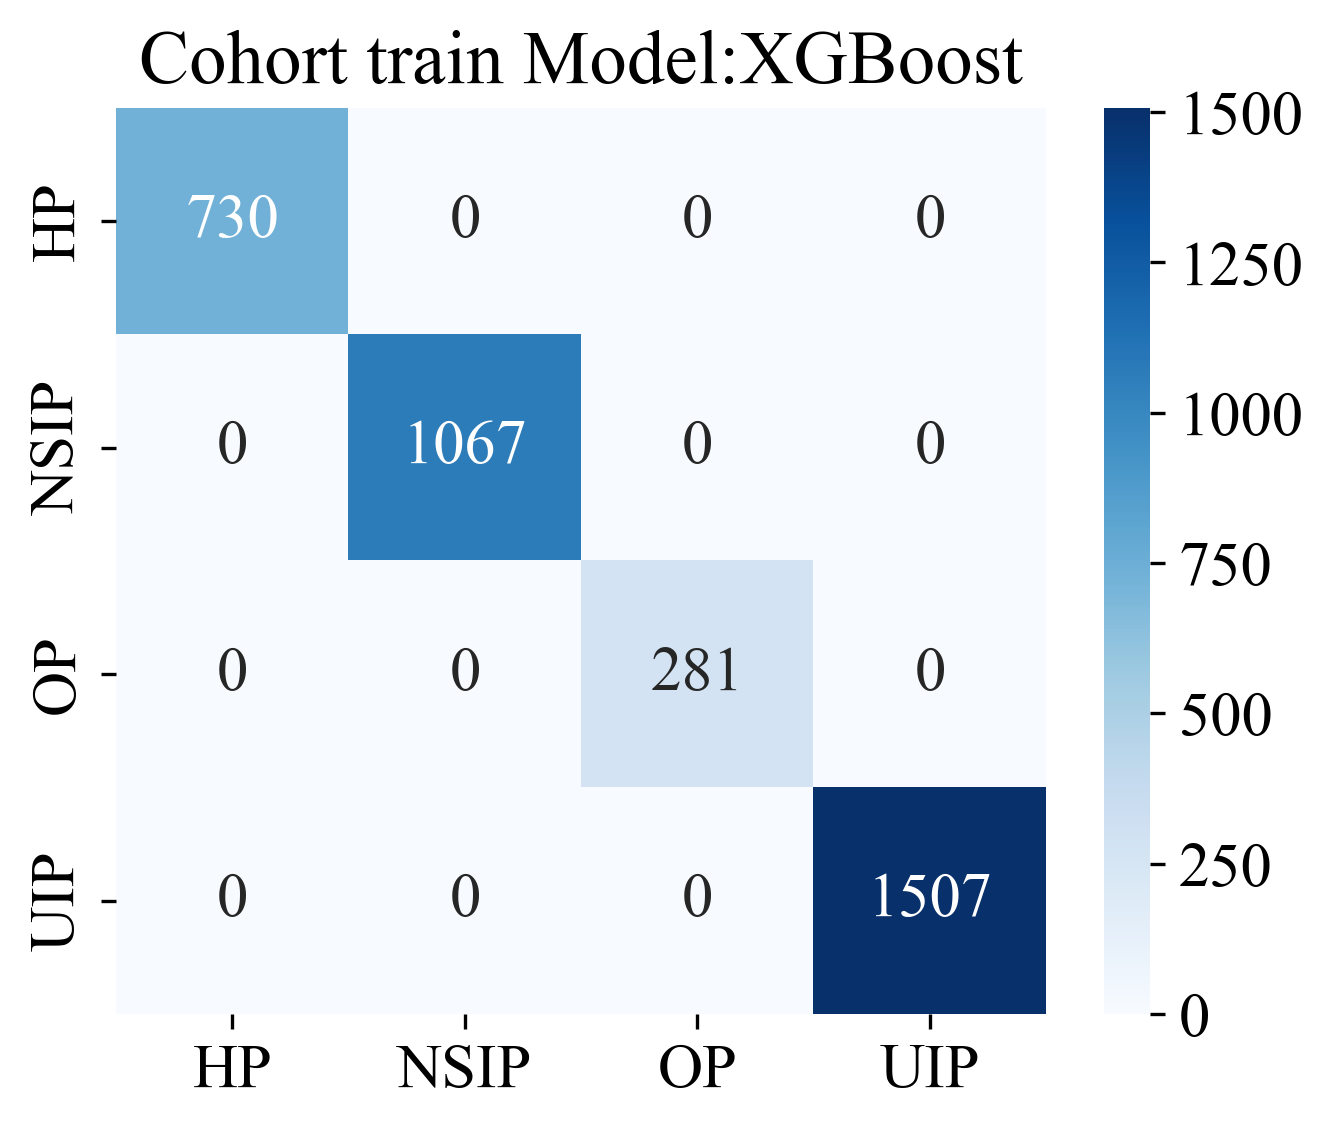

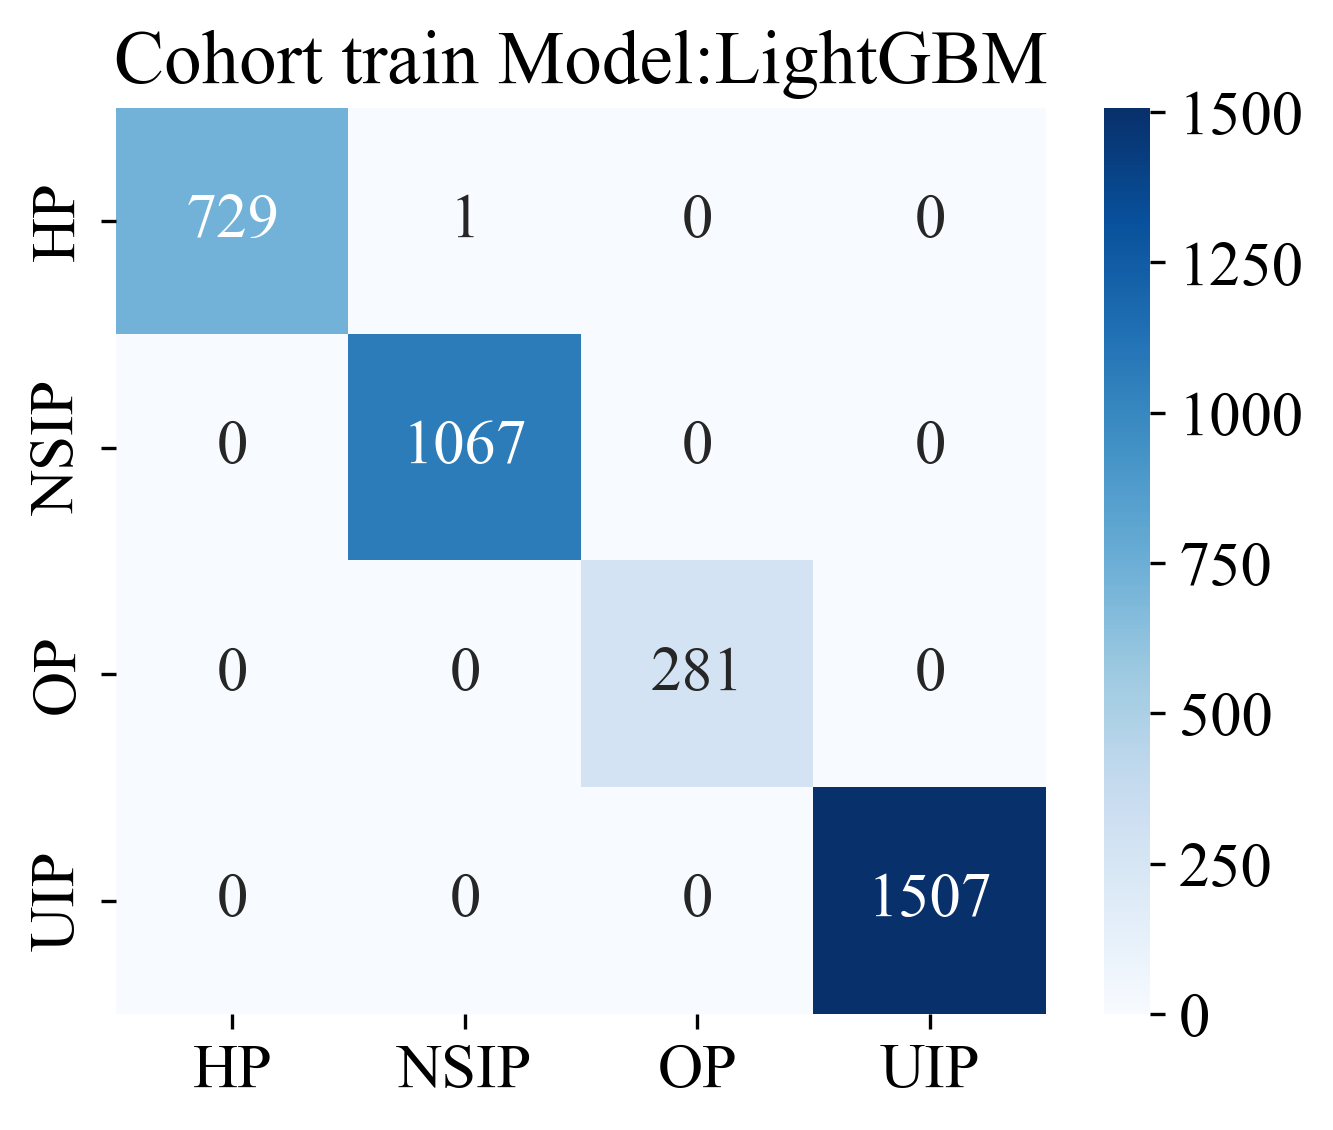

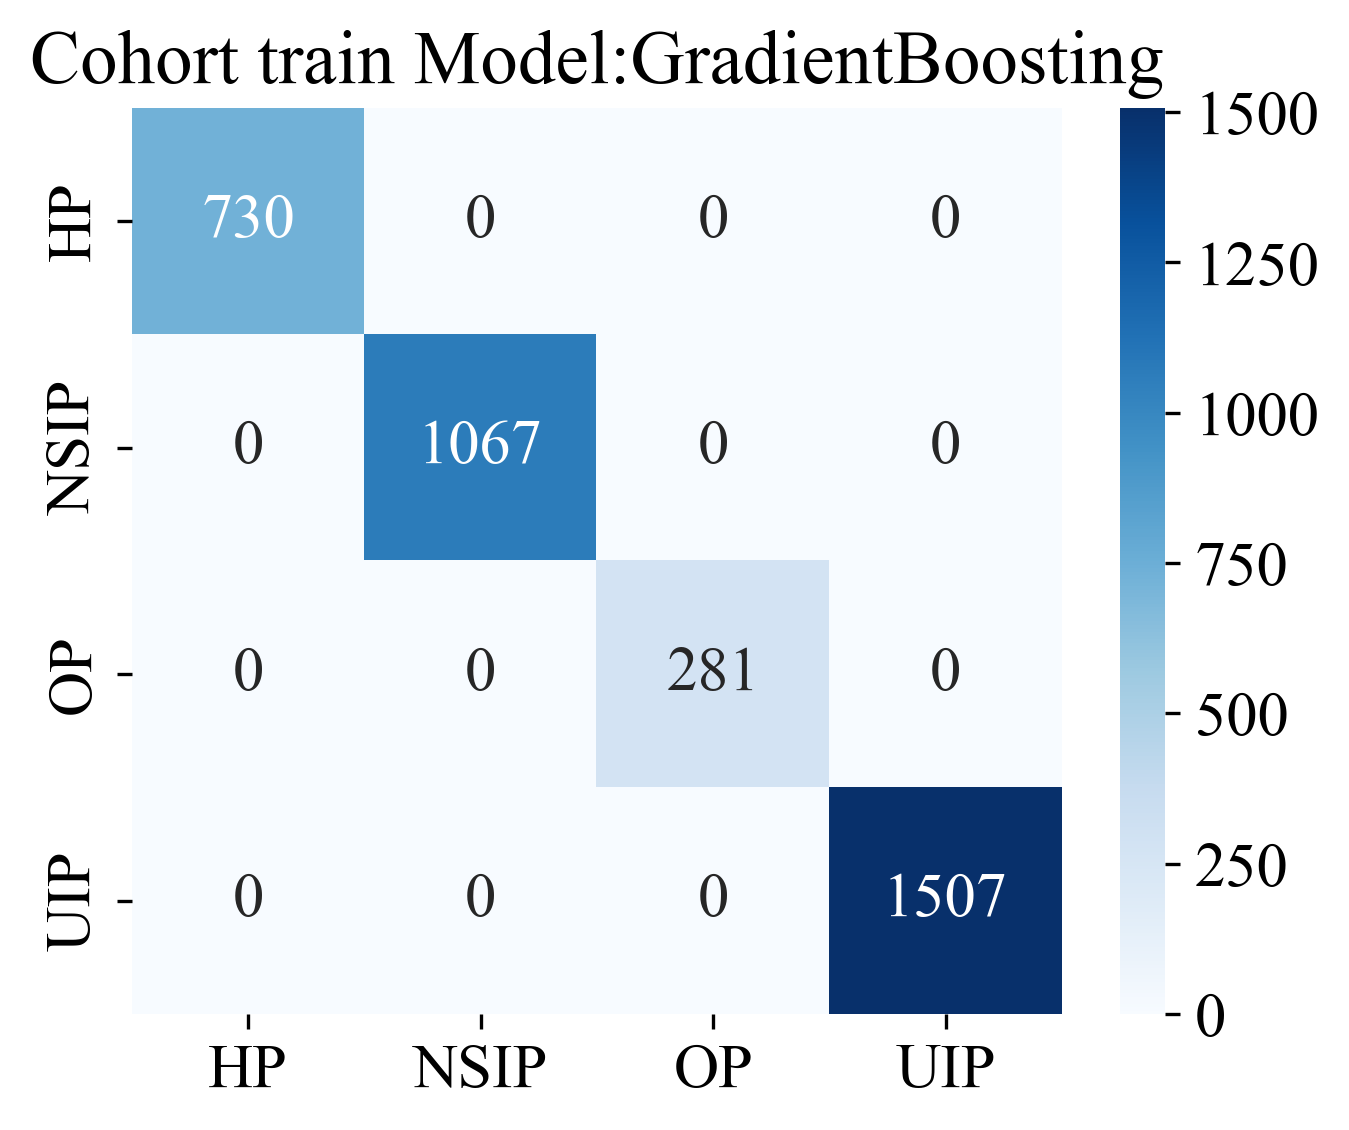

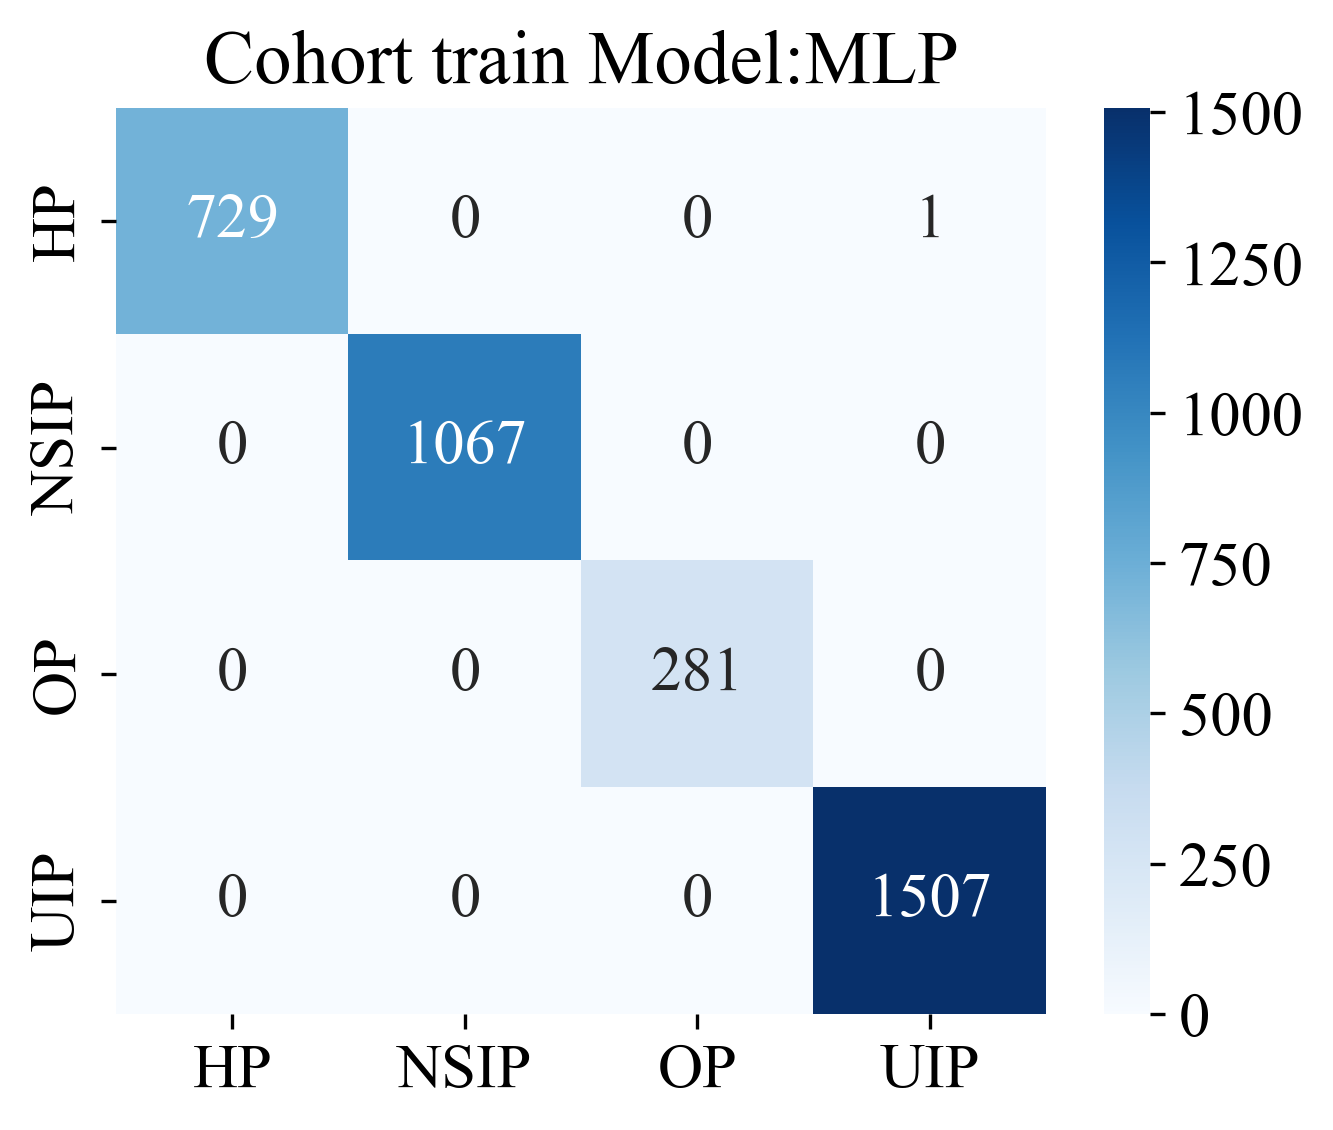

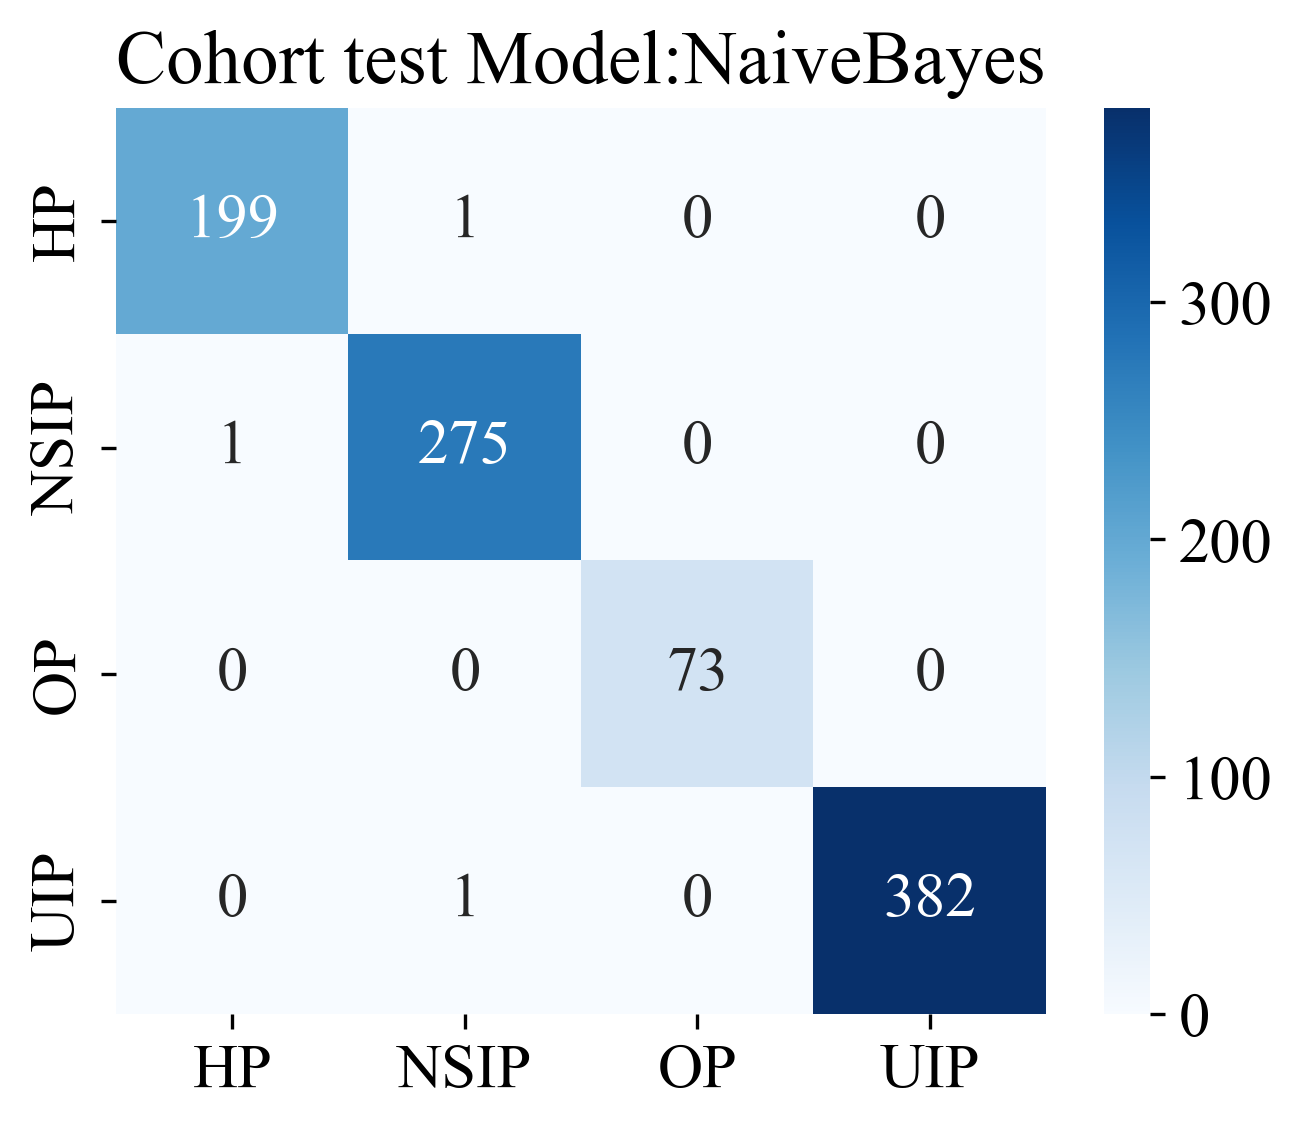

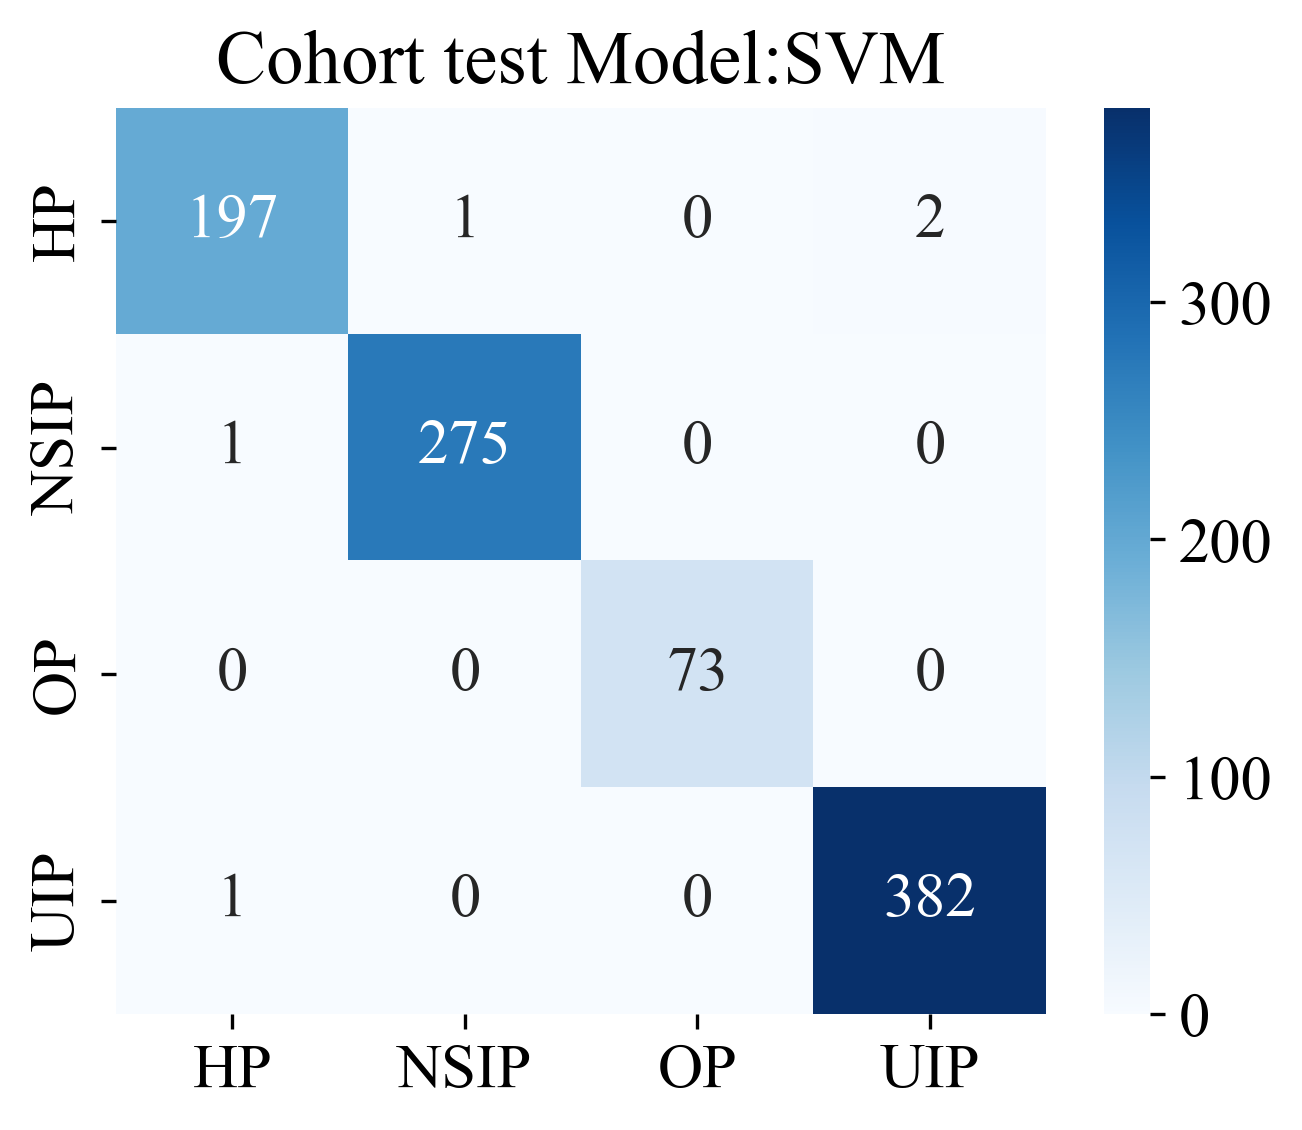

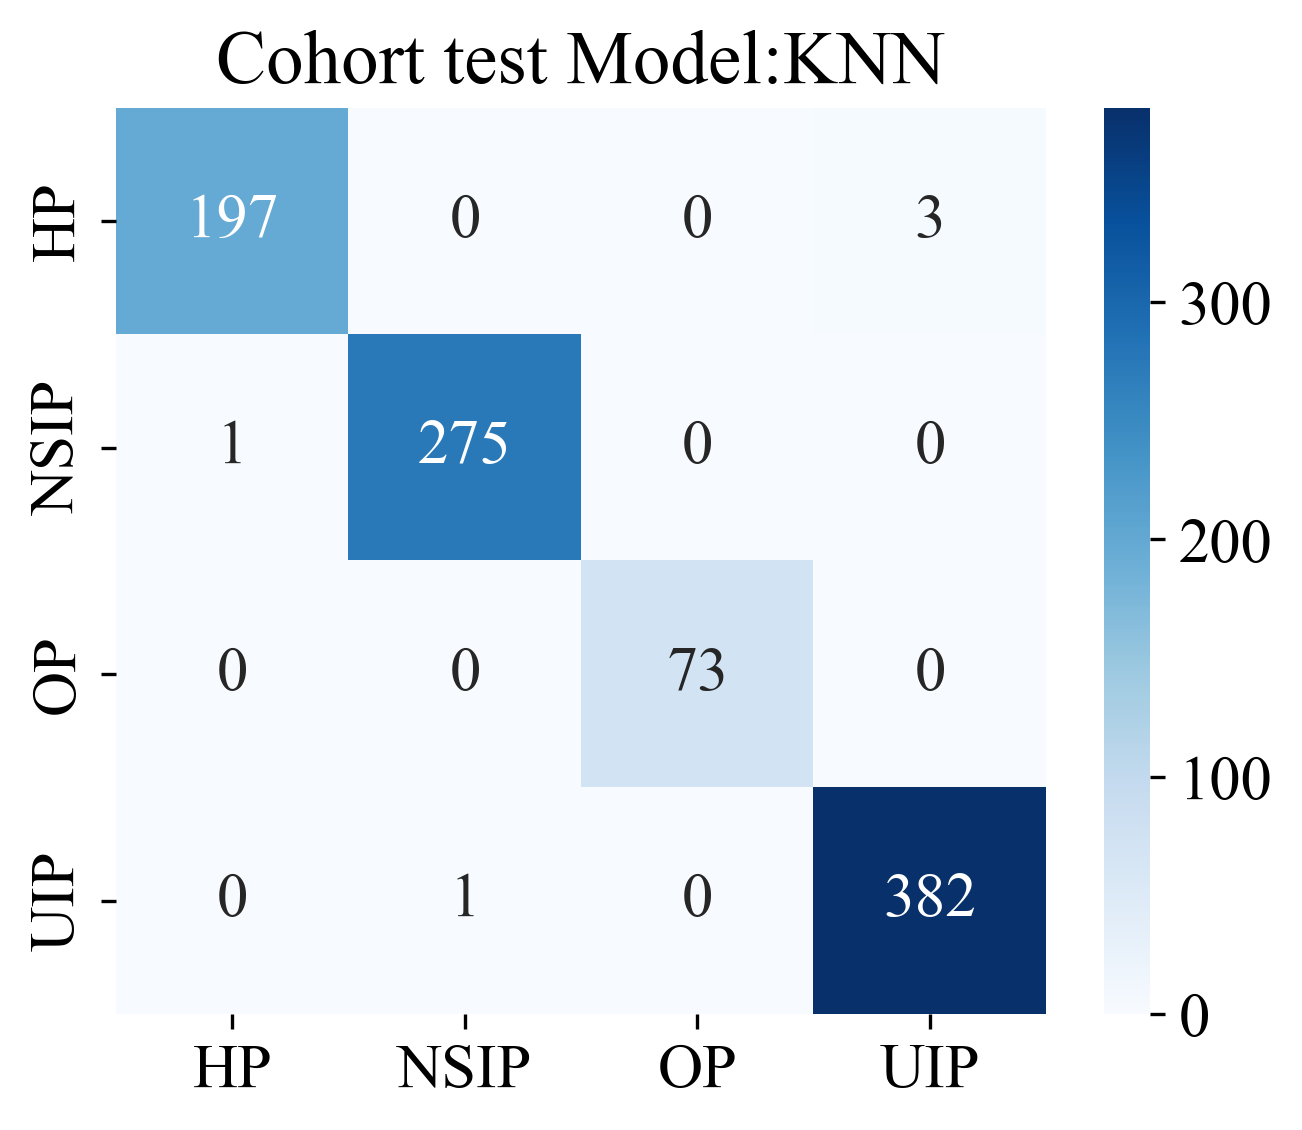

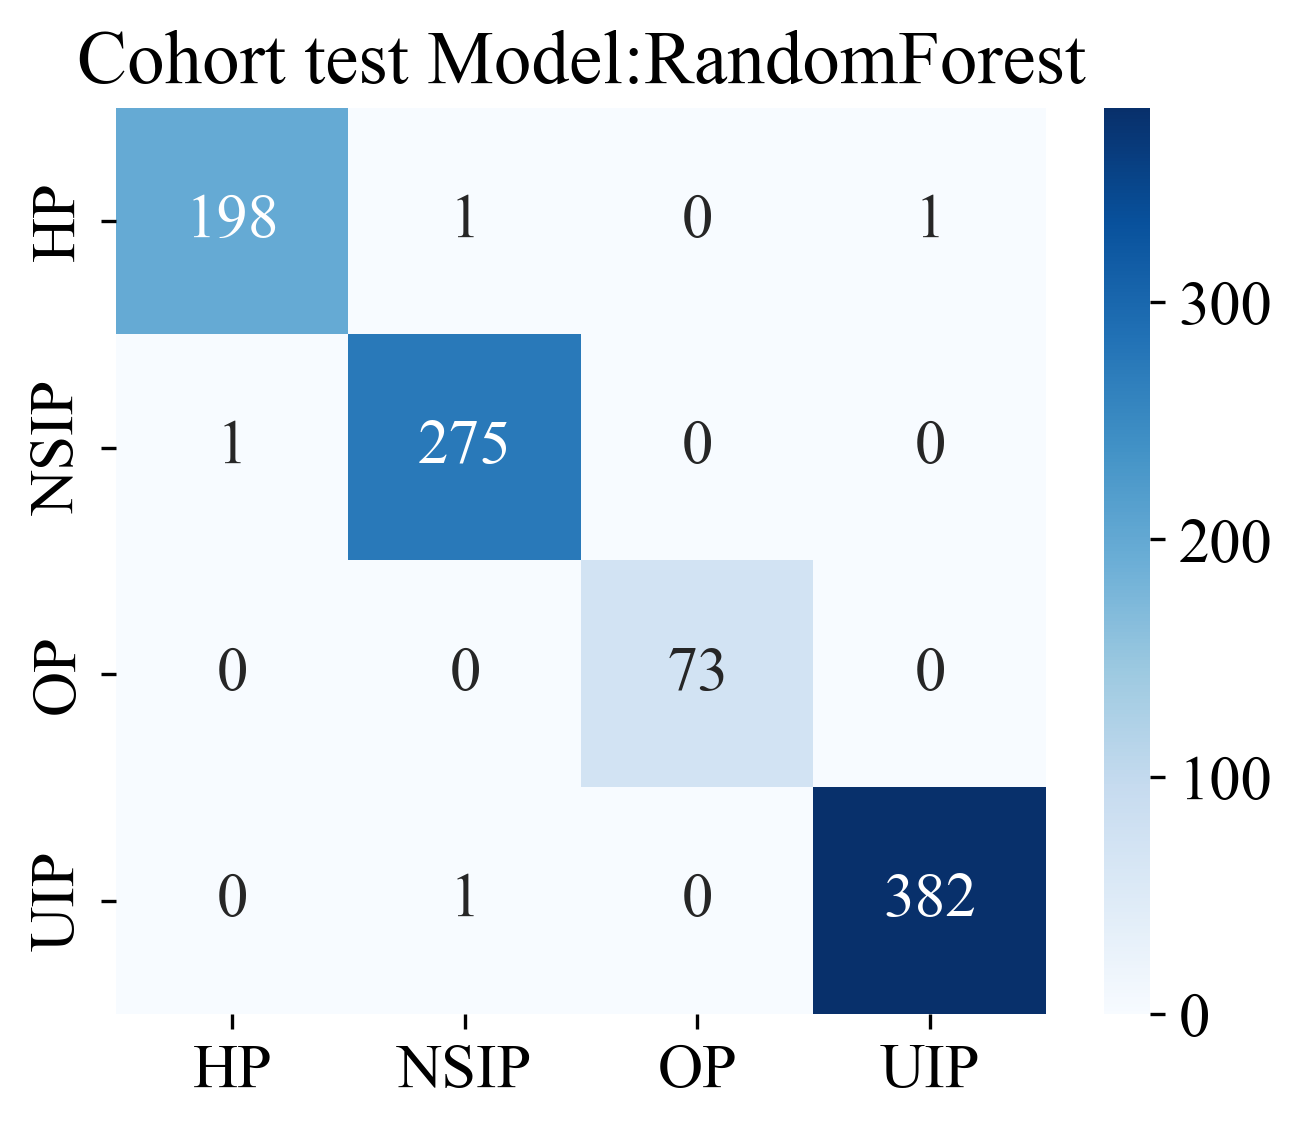

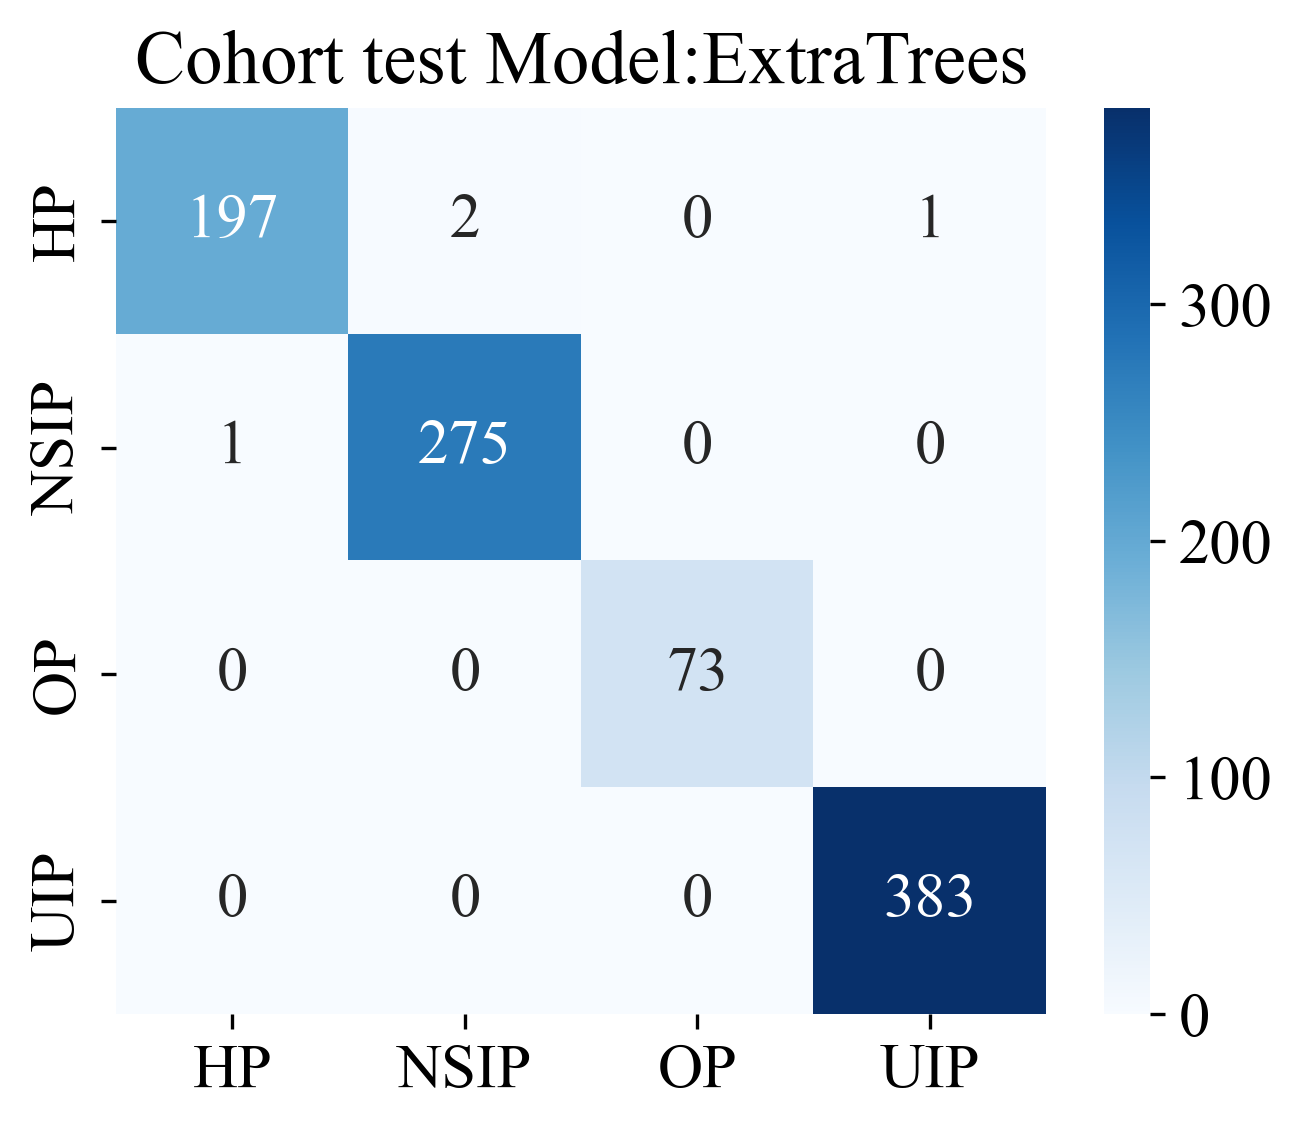

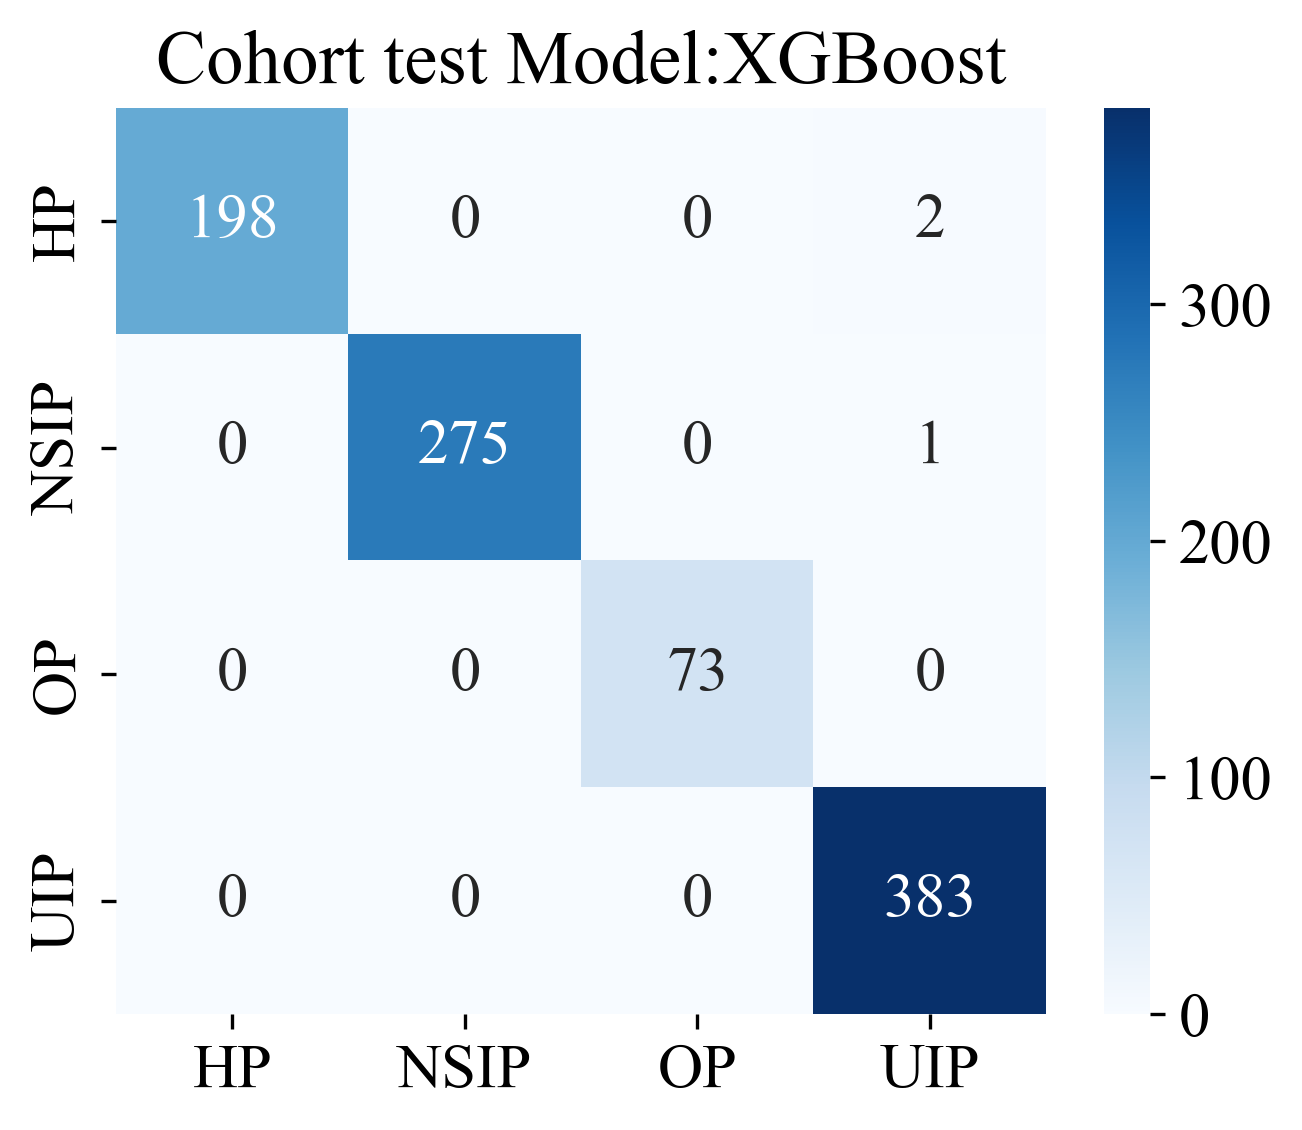

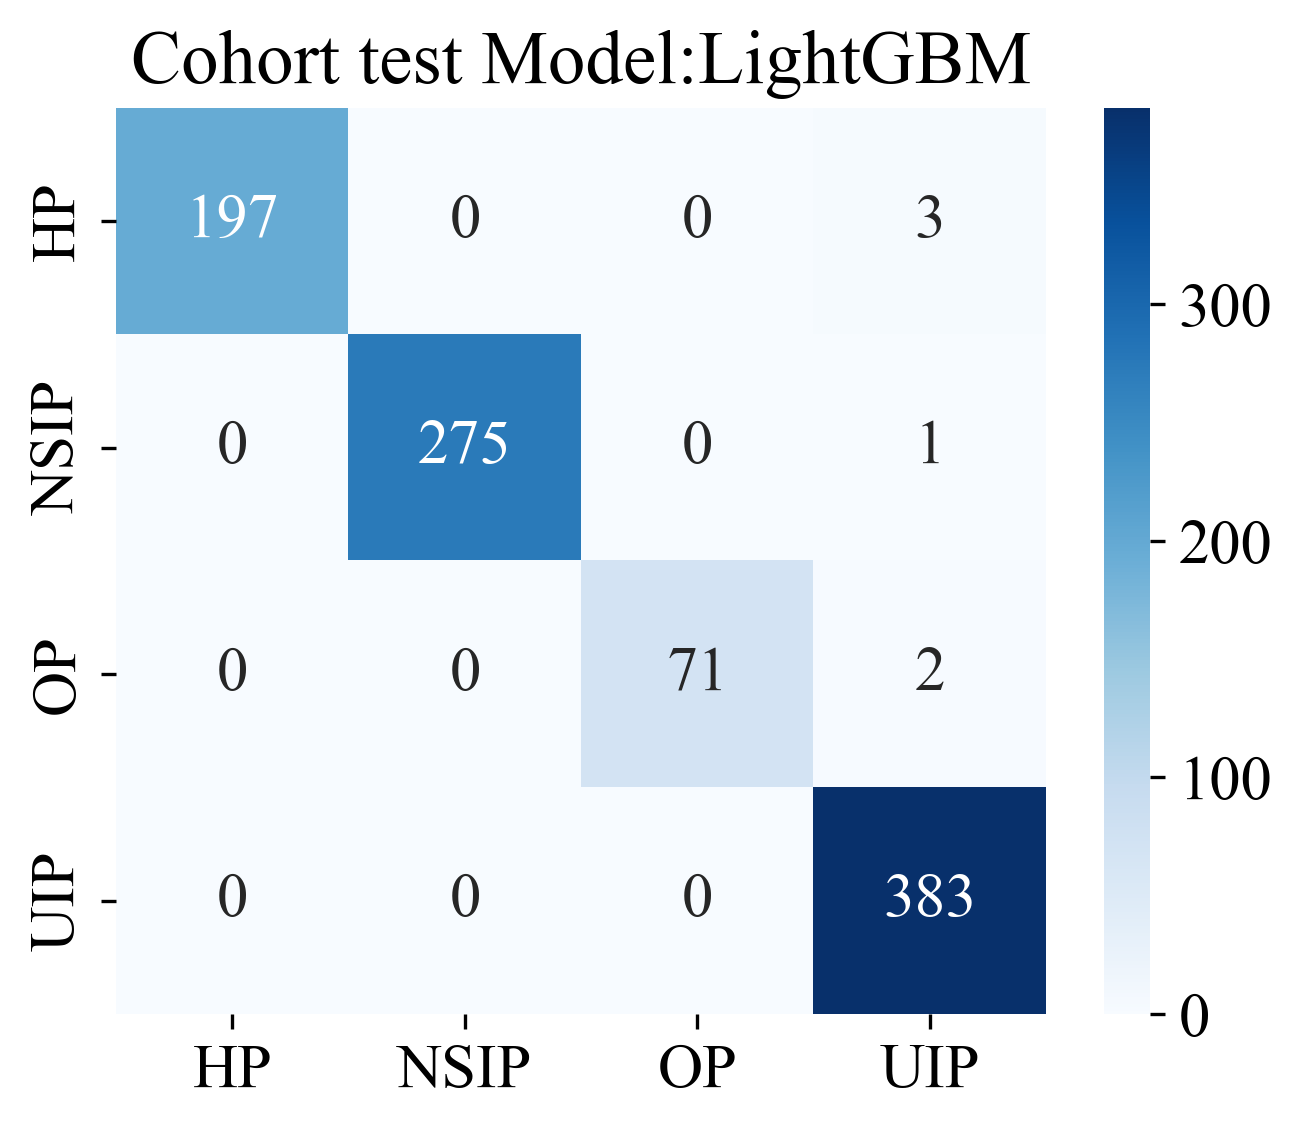

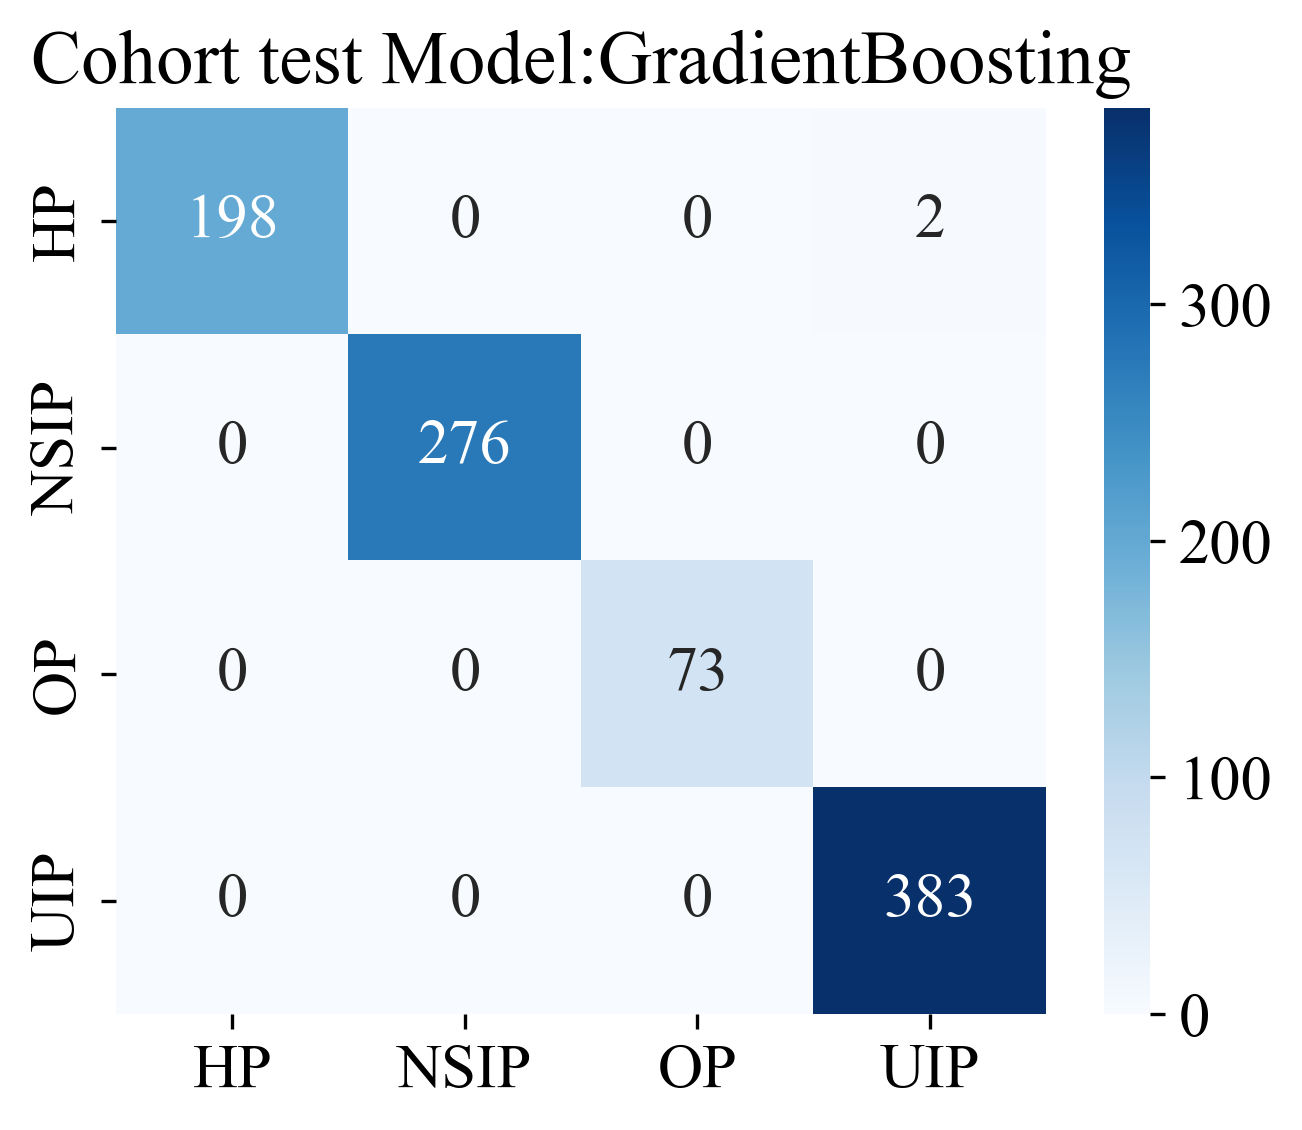

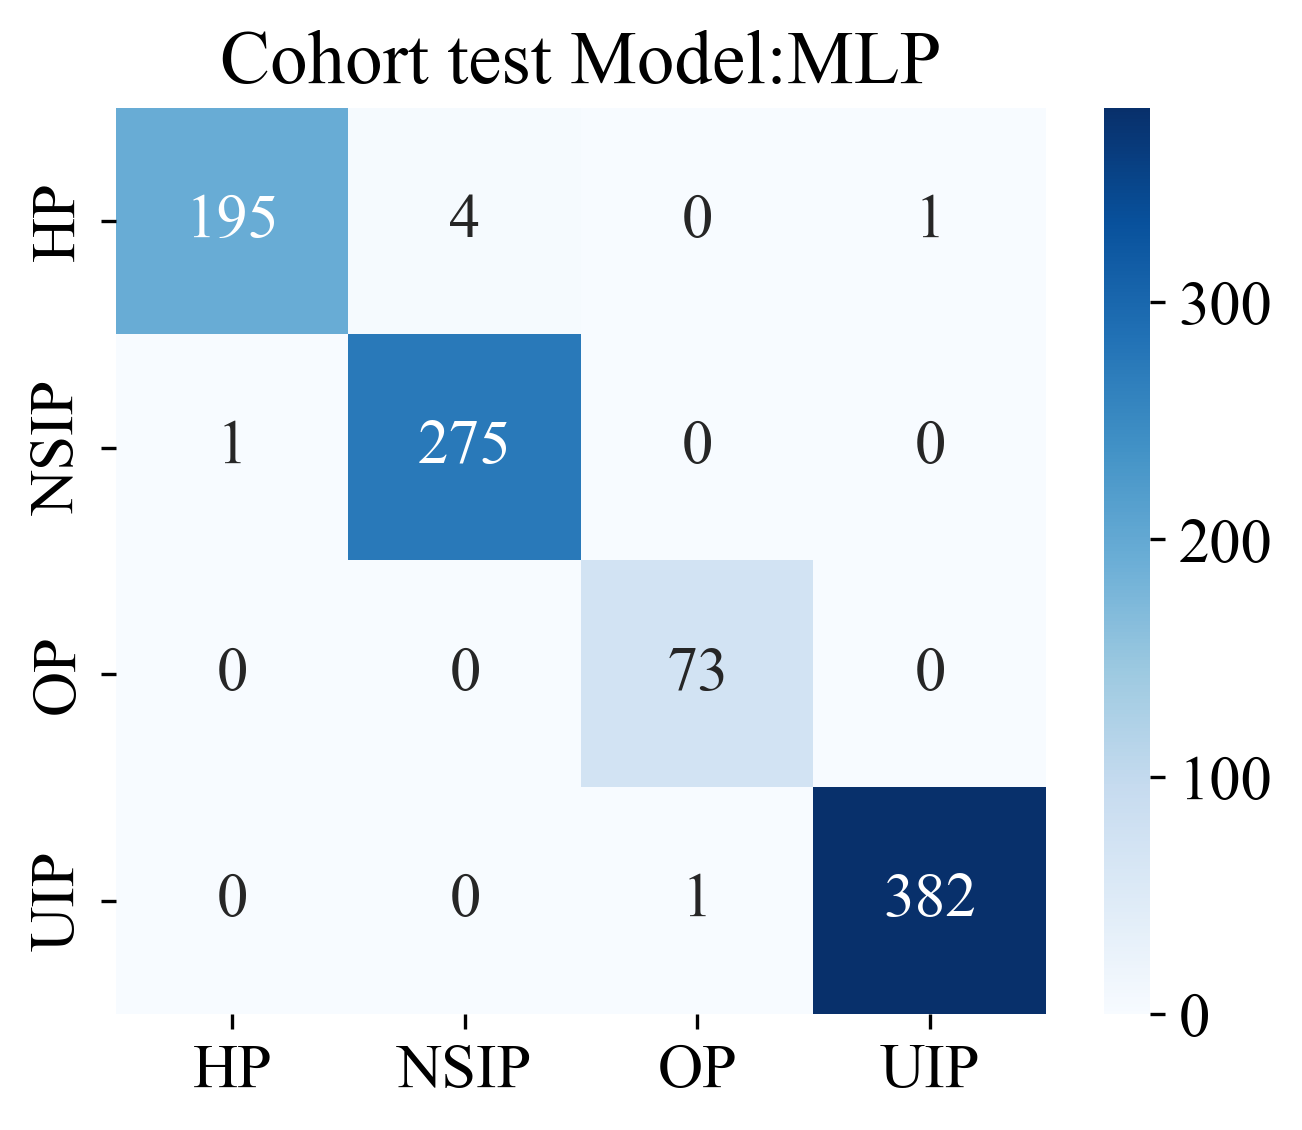

In [28]:
# 设置绘制参数
# sel_model = ['SVM', 'KNN']
sel_model = model_names
c_matrix = {}

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):
            cm = okcomp.comp1.calc_confusion_matrix(predictions[idx][sel_model_idx][0], y_train_sel[label], num_classes=n_classes,
                                                   class_mapping={0:"HP",1:"NSIP",2:"OP",3:"UIP"})
            c_matrix[label] = cm
            plt.figure(figsize=(5, 4))
            plt.title(f'Cohort train Model:{sm}')
            okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues', fmt='.4g')
            plt.savefig(f'img/model_{sm}_train_cm.svg', bbox_inches = 'tight')

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):
            cm = okcomp.comp1.calc_confusion_matrix(predictions[idx][sel_model_idx][-1], y_test_sel[label], num_classes=n_classes,
                                                   class_mapping={0:"HP",1:"NSIP",2:"OP",3:"UIP"})
            c_matrix[label] = cm
            plt.figure(figsize=(5, 4))
            plt.title(f'Cohort test Model:{sm}')
            okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues', fmt='.4g')
            plt.savefig(f'img/model_{sm}_test_cm.svg', bbox_inches = 'tight')

## 保存模型结果

可以把模型预测的标签结果以及每个类别的概率都保存下来。

In [29]:
import numpy as np
import os

sel_model = model_names
os.makedirs('results', exist_ok=True)
for idx, label in enumerate(labels):
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            target = targets[idx][sel_model_idx]
            # 预测训练集和测试集数据。
            train_indexes = np.reshape(np.array(train_ids), (-1, 1)).astype(str)
            test_indexes = np.reshape(np.array(test_ids), (-1, 1)).astype(str)
            y_train_pred_scores = target.predict_proba(X_train_sel)
            y_test_pred_scores = target.predict_proba(X_test_sel)
            columns = ['ID'] + [f"{label}-{i}"for i in range(y_test_pred_scores.shape[1])]
            # 保存预测的训练集和测试集结果
            result_train = pd.DataFrame(np.concatenate([train_indexes, y_train_pred_scores], axis=1), columns=columns)
            result_train.to_csv(f'./results/{sm}_train.csv', index=False)
            result_test = pd.DataFrame(np.concatenate([test_indexes, y_test_pred_scores], axis=1), columns=columns)
            result_test.to_csv(f'./results/{sm}_test.csv', index=False)